In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from datetime import datetime, timedelta
from netCDF4 import num2date
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
#from __future__ import print_function
from metpy.units import units
from metpy.calc import wind_speed, wind_direction
import numpy.ma as ma
import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import os
from shapely.geometry import polygon as sp
import pyproj 
import shapely.ops as ops
from shapely.ops import transform
from shapely.geometry.polygon import Polygon
from functools import partial
from shapely import geometry
import nexradaws
import pyart
import pandas as pd
from scipy import stats
from matplotlib.patches import PathPatch
import geopandas
from scipy import ndimage as ndi
from kdp_section import kdp_genesis
from pyproj import Geod


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\graph\cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\graph\cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
#Bring in Homeyer rainbow colormap. This line will not be needed once the next version of PyART comes out, 
#but is commented out here since I'm defaulting it to run without it at the moment.
#%run code_colormaps_CVD/colormap_generator.py

In [3]:
arc_outlines = pd.read_pickle('ZDRoutlines2016331KINX.pkl')
arc_outlines2 = pd.read_pickle('ZDRoutlines3502016331KINX.pkl')
arc_outlines3 = pd.read_pickle('ZDRoutlines3502016330KINX.pkl')
arc_outlines4 = pd.read_pickle('ZDRoutlines2016330KINX.pkl')

foot_outlines1 = pd.read_pickle('KDPoutlines2016330KINX.pkl')

In [4]:
#Create a projection for use in area calculations
#Set up projection for area calculations
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
           pyproj.Proj(init='epsg:3857'))

In [5]:
#print(foot_outlines1[0][0].to_polygons())

foot_out1 = foot_outlines1[0][0].vertices
#print(foot_out1)

print(sp.asPolygon(foot_out1).centroid.bounds)
print(sp.asPolygon(foot_out1).area)
print(transform(proj, sp.asPolygon(foot_out1)).area/(1000*1000))


(-96.34823164351698, 36.26530685435467, -96.34823164351698, 36.26530685435467)
0.006956483093377615
106.91602796070006


In [6]:
#Get all kdp foot and zdr arc algorithm centroids

foot_alg_cenlons = []
foot_alg_cenlats = []
foot_alg_areas = []
for i in range(len(foot_outlines1)):
    print(i)
    foot_alg_ilons = []
    foot_alg_ilats = []
    foot_alg_iareas = []
    for k in range(len(foot_outlines1[i])):
        foot_out1 = foot_outlines1[i][k].vertices
        foot_cent1 = sp.asPolygon(foot_out1).centroid.bounds
        foot_alg_iareas.append(transform(proj, sp.asPolygon(foot_out1)).area/(1000*1000))
        foot_alg_ilons.append(foot_cent1[0])
        foot_alg_ilats.append(foot_cent1[1])
    foot_cenloni = np.sum(np.asarray(foot_alg_ilons) * np.asarray(foot_alg_iareas)) / np.sum(np.asarray(foot_alg_iareas))
    foot_cenlati = np.sum(np.asarray(foot_alg_ilats) * np.asarray(foot_alg_iareas)) / np.sum(np.asarray(foot_alg_iareas))
    foot_areat = np.sum(np.asarray(foot_alg_iareas))
    foot_alg_areas.append(foot_areat)
    foot_alg_cenlons.append(foot_cenloni)
    foot_alg_cenlats.append(foot_cenlati)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [7]:
print(foot_alg_cenlons)

[-96.34823164351698, -96.33814761667423, -96.32126814022133, -96.31002310046797, -96.29127546774362, -96.28455020431485, -96.28121243165256, -96.26661782380866, -96.25424172886846, -96.23481722947959, -96.2215513010018, -96.21334277443349, -96.18577235695388, -96.177916743581, -96.16491370538311, -96.14499108507268, -96.13288802337493, -96.11098124911577, -96.10379106225537, -96.08657949982538, -96.07423856416172, -96.05486468597799, -96.0499014295253, -96.04220229710765, -96.0263192986361, -96.0229840762463, -96.01398086336147, -95.99381270343599, -95.97321518203698, -95.95688178247268, -95.92975550819608, -95.90639774817532, -95.89453218902123, -95.88078022460381, -95.87982739365295, -95.8707009999979, -95.86021022516421, -95.85036025688814, -95.84545173195713, -95.8303716874536]


In [8]:
#Get all kdp foot and zdr arc algorithm centroids

arc_alg_cenlons = []
arc_alg_cenlats = []

for i in range(len(arc_outlines4)):
    print(i)
    arc_alg_ilons = []
    arc_alg_ilats = []
    arc_alg_iareas = []
    for k in range(len(arc_outlines4[i])):
        arc_out1 = arc_outlines4[i][k].vertices
        arc_cent1 = sp.asPolygon(arc_out1).centroid.bounds
        arc_alg_iareas.append(transform(proj, sp.asPolygon(arc_out1)).area/(1000*1000))
        arc_alg_ilons.append(arc_cent1[0])
        arc_alg_ilats.append(arc_cent1[1])
    arc_cenloni = np.sum(np.asarray(arc_alg_ilons) * np.asarray(arc_alg_iareas)) / np.sum(np.asarray(arc_alg_iareas))
    arc_cenlati = np.sum(np.asarray(arc_alg_ilats) * np.asarray(arc_alg_iareas)) / np.sum(np.asarray(arc_alg_iareas))
    arc_alg_cenlons.append(arc_cenloni)
    arc_alg_cenlats.append(arc_cenlati)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars



16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [9]:
print(arc_alg_cenlons)

[-96.36051082545549, nan, -96.32129882635375, -96.24611334530141, -96.25788793436534, -96.21946348258254, -96.19667949004587, nan, -96.23375758010938, -96.16203136554073, -96.13988273596034, -96.1146431331799, nan, -96.1439394256801, -96.1262629592455, -96.11264346517453, -96.08554140682138, -96.05497377736391, -96.04609352571563, -96.04563775345684, -96.01913210345025, -96.01061602423684, -95.99331267510972, -95.97754611313576, -95.96630763410691, -95.96104671812489, -95.94391858413267, -95.94276702111479, -95.93344482648483, -95.91374777050768, -95.89246249832603, -95.86560111952832, -95.8421547032369, -95.821563741211, -95.8073984645195, -95.7804864341076, -95.76683980168576, -95.78226856231554, -95.79352065744554, -95.76992540129895]


In [10]:
print(arc_outlines4[3])

[Path(array([[-96.29230558,  36.21779827],
       [-96.28680509,  36.21725938],
       [-96.2813089 ,  36.21718194],
       [-96.27581331,  36.21716793],
       [-96.27031844,  36.21723478],
       [-96.26482531,  36.21749549],
       [-96.25933214,  36.21775569],
       [-96.25383745,  36.21784789],
       [-96.24835344,  36.2191628 ],
       [-96.24286304,  36.21976151],
       [-96.24285735,  36.21976617],
       [-96.24286442,  36.21992015],
       [-96.24593584,  36.2241823 ],
       [-96.24559413,  36.22861781],
       [-96.24683976,  36.23304433],
       [-96.24850818,  36.23685469],
       [-96.24930048,  36.23746392],
       [-96.25403091,  36.2397896 ],
       [-96.25953253,  36.24030353],
       [-96.26503603,  36.24101958],
       [-96.27053542,  36.24126919],
       [-96.27453087,  36.24175113],
       [-96.27603898,  36.2419725 ],
       [-96.28154449,  36.24287692],
       [-96.28704442,  36.24316394],
       [-96.29254715,  36.24374736],
       [-96.29804537,  36.243841

In [11]:
#Create a projection for use in area calculations
#Set up projection for area calculations
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
           pyproj.Proj(init='epsg:3857'))

In [12]:
arcshapefiles = []
areas = []
arctext = []
arc_clats = []
arc_clons = []
for file in os.listdir('ZDRarcshapefiles'):
    if file.endswith('.shp'):
        print(file)
        arctext.append(file)
        arc0001 = 'ZDRarcshapefiles/'+file
        Arc0001 = ShapelyFeature(Reader(arc0001).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'red')
        arcshapefiles.append(Arc0001)
        
        file1 = geopandas.read_file('ZDRarcshapefiles/'+file)  
        filematrix = file1['geometry']
        pr_area1 = (transform(proj, filematrix[0]).area * units('m^2')).to('km^2')
        centroid = filematrix[0].centroid
        arc_clons.append(centroid.bounds[0])
        arc_clats.append(centroid.bounds[1])
        #print(centroid)
        areas.append(pr_area1.magnitude)

ARCKINX0000.shp
ARCKINX0001.shp
ARCKINX0003.shp
ARCKINX0005.shp
ARCKINX0006.shp
ARCKINX0008.shp
ARCKINX0010.shp
ARCKINX0011.shp
ARCKINX0013.shp
ARCKINX0014.shp
ARCKINX0016A.shp
ARCKINX0018.shp
ARCKINX0019.shp
ARCKINX0021.shp
ARCKINX0023.shp
ARCKINX0024.shp
ARCKINX0026.shp
ARCKINX0027.shp
ARCKINX0029.shp
ARCKINX0031.shp
ARCKINX0032.shp
ARCKINX2329.shp
ARCKINX2330.shp
ARCKINX2332.shp
ARCKINX2333.shp
ARCKINX2335.shp
ARCKINX2337.shp
ARCKINX2339.shp
ARCKINX2340.shp
ARCKINX2342.shp
ARCKINX2344.shp
ARCKINX2345.shp
ARCKINX2347.shp
ARCKINX2348.shp
ARCKINX2350.shp
ARCKINX2351.shp
ARCKINX2353.shp
ARCKINX2355.shp
ARCKINX2357.shp
ARCKINX2358.shp


In [13]:
print(centroid.bounds[0])
print(centroid.bounds[1])
print(centroid.bounds)


-96.05697208201303
36.281284481746106
(-96.05697208201303, 36.281284481746106, -96.05697208201303, 36.281284481746106)


In [14]:
footshapefiles = []
footareas = []
foottext = []
foot_clats = []
foot_clons = []
for file in os.listdir('KDPshapefiles'):
    if file.endswith('.shp'):
        print(file)
        foottext.append(file)
        foot0001 = 'KDPshapefiles/'+file
        Foot0001 = ShapelyFeature(Reader(foot0001).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'green')
        footshapefiles.append(Foot0001)
        
        file1 = geopandas.read_file('KDPshapefiles/'+file)  
        filematrix = file1['geometry']
        pr_area1 = (transform(proj, filematrix[0]).area * units('m^2')).to('km^2')
        centroid = filematrix[0].centroid
        foot_clons.append(centroid.bounds[0])
        foot_clats.append(centroid.bounds[1])
        footareas.append(pr_area1.magnitude)

KDPfoot0001.shp
KDPfoot0003.shp
KDPfoot0004.shp
KDPfoot0006.shp
KDPfoot0008.shp
KDPfoot0009.shp
KDPfoot0011.shp
KDPfoot0012.shp
KDPfoot0013.shp
KDPfoot0016.shp
KDPfoot0018.shp
KDPfoot0019.shp
KDPfoot0021.shp
KDPfoot0022.shp
KDPfoot0024.shp
KDPfoot0026.shp
KDPfoot0027.shp
KDPfoot0030.shp
KDPfoot0032.shp
KDPfoot2329.shp
KDPfoot2330.shp
KDPfoot2332.shp
KDPfoot2333.shp
KDPfoot2337.shp
KDPfoot2339.shp
KDPfoot2340.shp
KDPfoot2342.shp
KDPfoot2344.shp
KDPfoot2345.shp
KDPfoot2347.shp
KDPfoot2348.shp
KDPfoot2350.shp
KDPfoot2351.shp
KDPfoot2353.shp
KDPfoot2355.shp
KDPfoot2356.shp
KDPfoot2358.shp
KDPfoot2359.shp


In [15]:
print(len(footshapefiles))
print(arctext[21])
print(foottext[18])

38
ARCKINX2329.shp
KDPfoot0032.shp


In [16]:
#print(arcshapefiles)
#Rearrange the manual shapefiles so they're in correct order
arcshapefilesc = []
areasc = []
arctextc = []
arc_clatsc = []
arc_clonsc = []
m = 21
for i in range(19):
    print(i)
    arcshapefilesc.append(arcshapefiles[m])
    areasc.append(areas[m])
    arctextc.append(arctext[m])
    arc_clatsc.append(arc_clats[m])
    arc_clonsc.append(arc_clons[m])
    m = m+1
for i in range(21):
    arcshapefilesc.append(arcshapefiles[i])
    areasc.append(areas[i])
    arctextc.append(arctext[i])
    arc_clatsc.append(arc_clats[i])
    arc_clonsc.append(arc_clons[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [17]:
#print(arcshapefiles)
#Rearrange the manual shapefiles so they're in correct order
footshapefilesc = []
footareasc = []
foottextc = []
foot_clatsc = []
foot_clonsc = []
m = 19
for i in range(17):
    print(i)
    footshapefilesc.append(footshapefiles[m])
    footareasc.append(footareas[m])
    foottextc.append(foottext[m])
    foot_clatsc.append(foot_clats[m])
    foot_clonsc.append(foot_clons[m])
    m = m+1
for i in range(19):
    footshapefilesc.append(footshapefiles[i])
    footareasc.append(footareas[i])
    foottextc.append(foottext[i])
    foot_clatsc.append(foot_clats[i])
    foot_clonsc.append(foot_clons[i])

footshapefilesc.insert(4,[np.nan])
footareasc.insert(4,np.nan)
foottextc.insert(4,[np.nan])
foot_clatsc.insert(4,np.nan)
foot_clonsc.insert(4,np.nan)

footshapefilesc.insert(18,[np.nan])
footareasc.insert(18,np.nan)
foottextc.insert(18,[np.nan])
foot_clatsc.insert(18,np.nan)
foot_clonsc.insert(18,np.nan)

footshapefilesc.insert(19,[np.nan])
footareasc.insert(19,np.nan)
foottextc.insert(19,[np.nan])
foot_clatsc.insert(19,np.nan)
foot_clonsc.insert(19,np.nan)

footshapefilesc.insert(37,[np.nan])
footareasc.insert(37,np.nan)
foottextc.insert(37,[np.nan])
foot_clatsc.insert(37,np.nan)
foot_clonsc.insert(37,np.nan)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [18]:
print(arctextc[11])
print(foottextc[11])

ARCKINX2347.shp
KDPfoot2347.shp


In [19]:
print(arctextc[37])
print(foottextc[34])

ARCKINX0029.shp
KDPfoot0024.shp


In [20]:
print(len(footshapefilesc))
print(len(arcshapefilesc))

#add the proper null items into the KDP list
#footshapefilesc.insert(4,[np.nan])
print(footshapefilesc[37])

40
40
[nan]


In [21]:
folder = 'KINX033016'

In [22]:
radarfiles = []
for radar_file in os.listdir(folder):
    radarfiles.append(radar_file)

In [23]:
print(radarfiles[0])
radar1 = pyart.io.nexrad_archive.read_nexrad_archive(folder+'/'+radarfiles[0])

KINX20160330_232900_V06.gz


In [24]:
radar = radar1.extract_sweeps([0])

In [25]:
refl_arrays = []
zdr_arrays = []
kdp_arrays = []
lon_arrays = []
lat_arrays = []
grids = []
s = 1
for radar_file in os.listdir(folder):
    radar1 = pyart.io.nexrad_archive.read_nexrad_archive(folder+'/'+radar_file)
    print('file number', s)
    s = s + 1
    for i in range(radar1.nsweeps):
        #print('in loop')
        radar = radar1.extract_sweeps([i])
        #print(((np.mean(radar.elevation['data']))))
        if ((np.mean(radar.elevation['data']) < .65) and (np.max(np.asarray(radar.fields['differential_reflectivity']['data'])) != np.min(np.asarray(radar.fields['differential_reflectivity']['data'])))):
            #print('yep')
            ref_ungridded = radar.fields['reflectivity']['data']
            #Mask out everything with reflectivity below Z=20 dBZ for Z and ZDR
            refl_c = np.copy(ref_ungridded)
            ref_c = ma.masked_where(refl_c < 20., refl_c)
            ungrid_lons = radar.gate_longitude['data']
            ungrid_lats = radar.gate_latitude['data']
            zdr_ungridded = radar.fields['differential_reflectivity']['data']
            zdrl_c = np.copy(zdr_ungridded)
            zdr_c = ma.masked_where(refl_c < 20, zdrl_c)
            zdr_arrays.append(zdr_c)
            refl_arrays.append(ref_c)
            lon_arrays.append(ungrid_lons)
            lat_arrays.append(ungrid_lats)
            #Calling kdp_section; Using NWS method, creating ungridded, smoothed KDP field
            kdp_nwsdict = kdp_genesis(radar)

            #Add field to radar
            radar.add_field('KDP', kdp_nwsdict)
            kdp_ungridded_nws = radar.fields['KDP']['data']
            kdp_arrays.append(kdp_ungridded_nws)
            grid = pyart.map.grid_from_radars(
                (radar,),
                grid_shape=(1, 500, 500),
                grid_limits=((200, 200), (-123000.0, 123000.0), (-123000.0, 123000.0)),
                fields=['differential_reflectivity','reflectivity','cross_correlation_ratio', 'KDP'])
            grids.append(grid)

file number 1
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 2
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 3
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 4
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 5
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 6
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 7
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 8
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 9
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


file number 10
KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


KDP Section


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\pyart\map\gates_to_grid.py:177: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  " Pauley and Wu 1990.", DeprecationWarning)


In [26]:
ref_ungridded = radar.fields['reflectivity']['data']
#Mask out everything with reflectivity below Z=20 dBZ for Z and ZDR
refl_c = np.copy(ref_ungridded)
ref_c = ma.masked_where(refl_c < 20., refl_c)
zdr_ungridded = radar.fields['differential_reflectivity']['data']
zdrl_c = np.copy(zdr_ungridded)
zdr_c = ma.masked_where(refl_c < 20, zdrl_c)
ungrid_lons = radar.gate_longitude['data']
ungrid_lats = radar.gate_latitude['data']


In [27]:
print(np.max(ref_c))
print(ungrid_lons)
print(ungrid_lats)

59.0
[[-95.54668308 -95.54462712 -95.54257126 ... -91.96312334 -91.96125755
  -91.95939234]
 [-95.54693965 -95.54491387 -95.5428882  ... -92.01830757 -92.01647179
  -92.01463556]
 [-95.54719138 -95.54519522 -95.54319916 ... -92.07228344 -92.07047665
  -92.06866943]
 ...
 [-95.54599504 -95.54385812 -95.54172132 ... -91.81471665 -91.81277108
  -91.81082504]
 [-95.54622461 -95.5441147  -95.54200491 ... -91.86443107 -91.86251244
  -91.86059335]
 [-95.54645837 -95.54437596 -95.54229367 ... -91.91490079 -91.91300945
  -91.91111764]]
[[36.16390714 36.16258689 36.16126662 ... 33.73952294 33.73819533
  33.73686805]
 [36.1636635  36.16231458 36.16096566 ... 33.68960092 33.6882478
  33.68689429]
 [36.16343036 36.16205403 36.16067769 ... 33.64182173 33.64044402
  33.6390659 ]
 ...
 [36.16466543 36.16343436 36.16220328 ... 33.89613087 33.8948848
  33.89363836]
 [36.16441044 36.16314938 36.16188831 ... 33.84356117 33.84228787
  33.84101419]
 [36.1641601  36.1628696  36.16157908 ... 33.79198171 33.79

In [28]:
print(len(lon_arrays))
print(grids[35])

40


In [29]:
#Get the data out of the grid object we need
#Get the data from the grid
ZDR = grids[35].fields['differential_reflectivity']['data'][0]
REF = grids[35].fields['reflectivity']['data'][0]
CC = grids[35].fields['cross_correlation_ratio']['data'][0]
KDP = grids[35].fields['KDP']['data'][0]
#Mask everything below 20dbz on the grid
ZDRmasked1 = ma.masked_where(REF < 20, ZDR)
REFmasked = ma.masked_where(REF < 20, REF)
CCmasked = ma.masked_where(REF < 20, CC)
KDPmasked = ma.masked_where(REF < 35, KDP)
KDPmasked = ma.filled(KDPmasked, fill_value=-2)

In [30]:
#Extract the gridded lats and lons
rlons = grid.point_longitude['data']
rlats = grid.point_latitude['data']
rlons_2d = rlons[0,:,:]
rlats_2d = rlats[0,:,:]

In [31]:
lat = 36.30
lon = -95.9
cenlat = float(lat)
cenlon = float(lon)

#Let's set up the map projection!
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
# Limit the extent of the map area, must convert to proper coords.
LL = crs.transform_point(cenlon-0.55,cenlat-0.12,ccrs.PlateCarree())
UR = crs.transform_point(cenlon+0.25,cenlat+0.12,ccrs.PlateCarree())

fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'

counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')

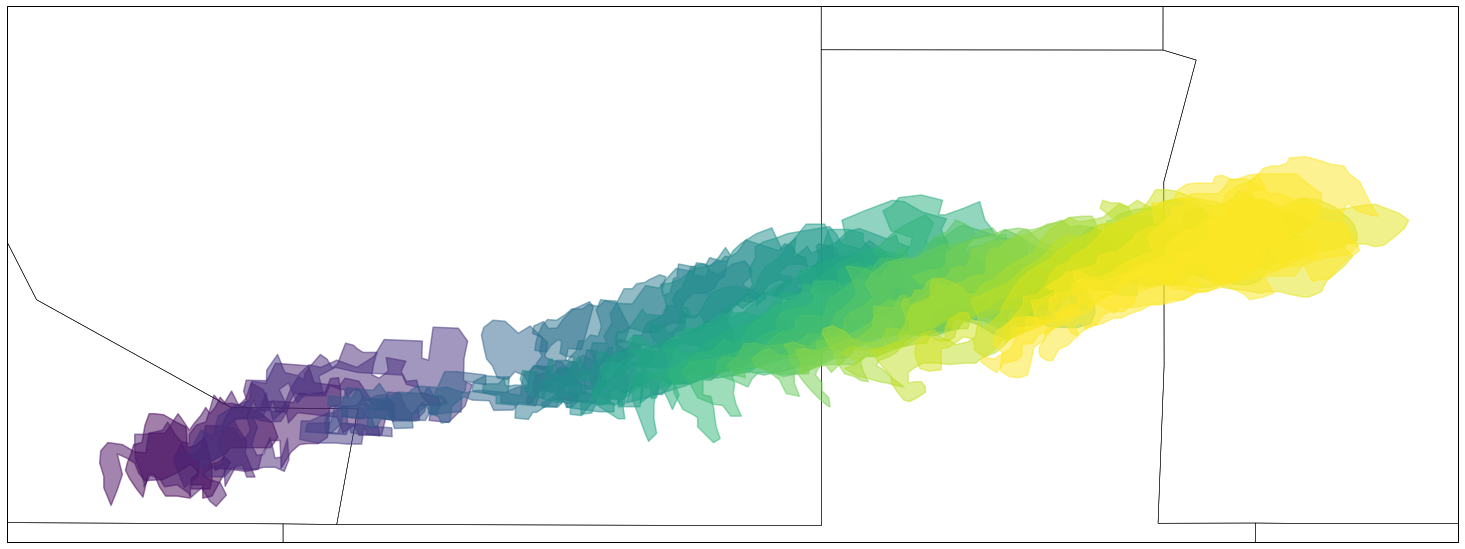

In [32]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
polygons = []
for i in range(len(arcshapefiles)):
    arc = ax.add_feature(arcshapefilesc[i], edgecolor = plt.cm.viridis(i*7), facecolor = plt.cm.viridis(i*7), linewidth=1.5, alpha=0.5)
    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [33]:
LL1 = crs.transform_point(cenlon-0.15,cenlat-0.10,ccrs.PlateCarree())
UR1 = crs.transform_point(cenlon+0.33,cenlat+0.16,ccrs.PlateCarree())

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


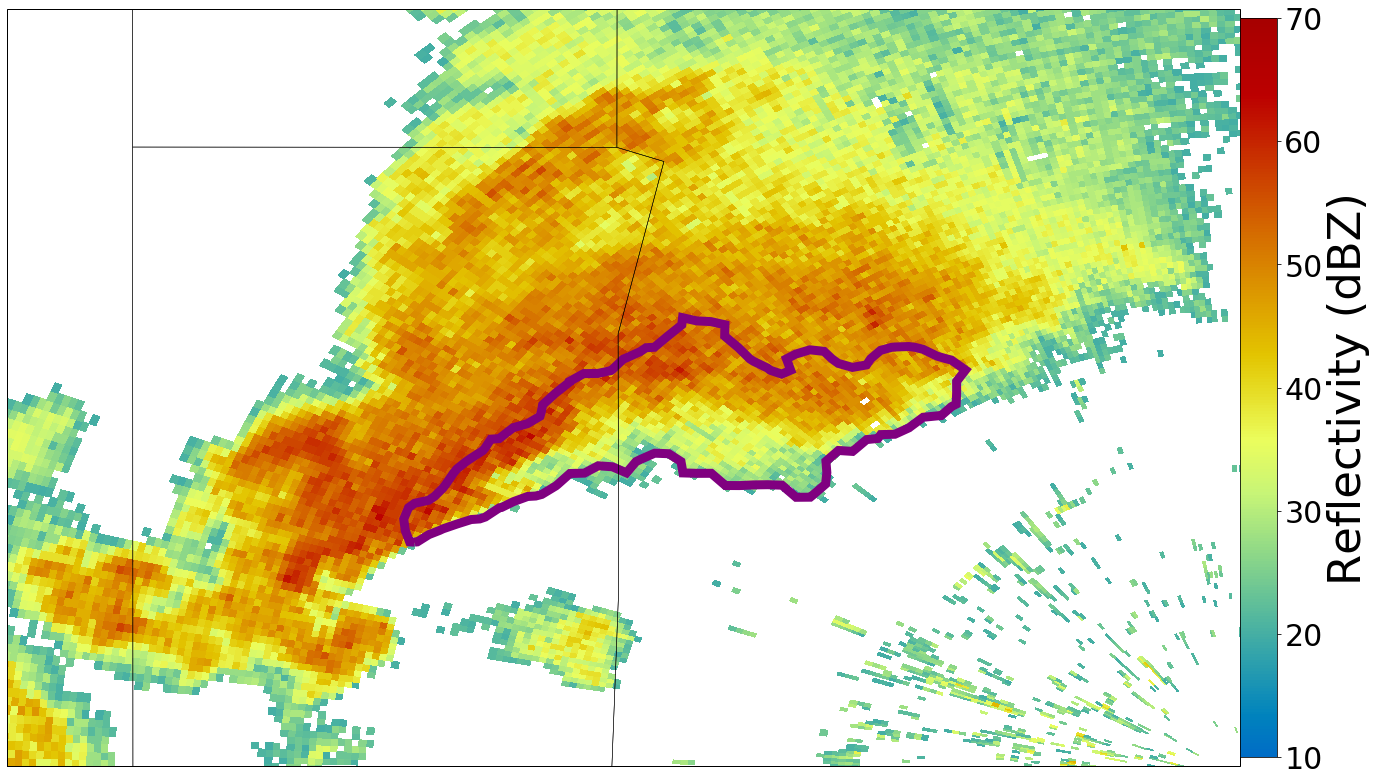

In [34]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
refp = ax.pcolormesh(lon_arrays[35], lat_arrays[35], refl_arrays[35], cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin = 10, vmax = 70)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.viridis, vmin = 1, vmax = 7)
cg1 = plt.colorbar(refp, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)

#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefiles[8], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 3)
patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=9)
ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PaperRefl.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [35]:
print(polygons[0])

0
1
0


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


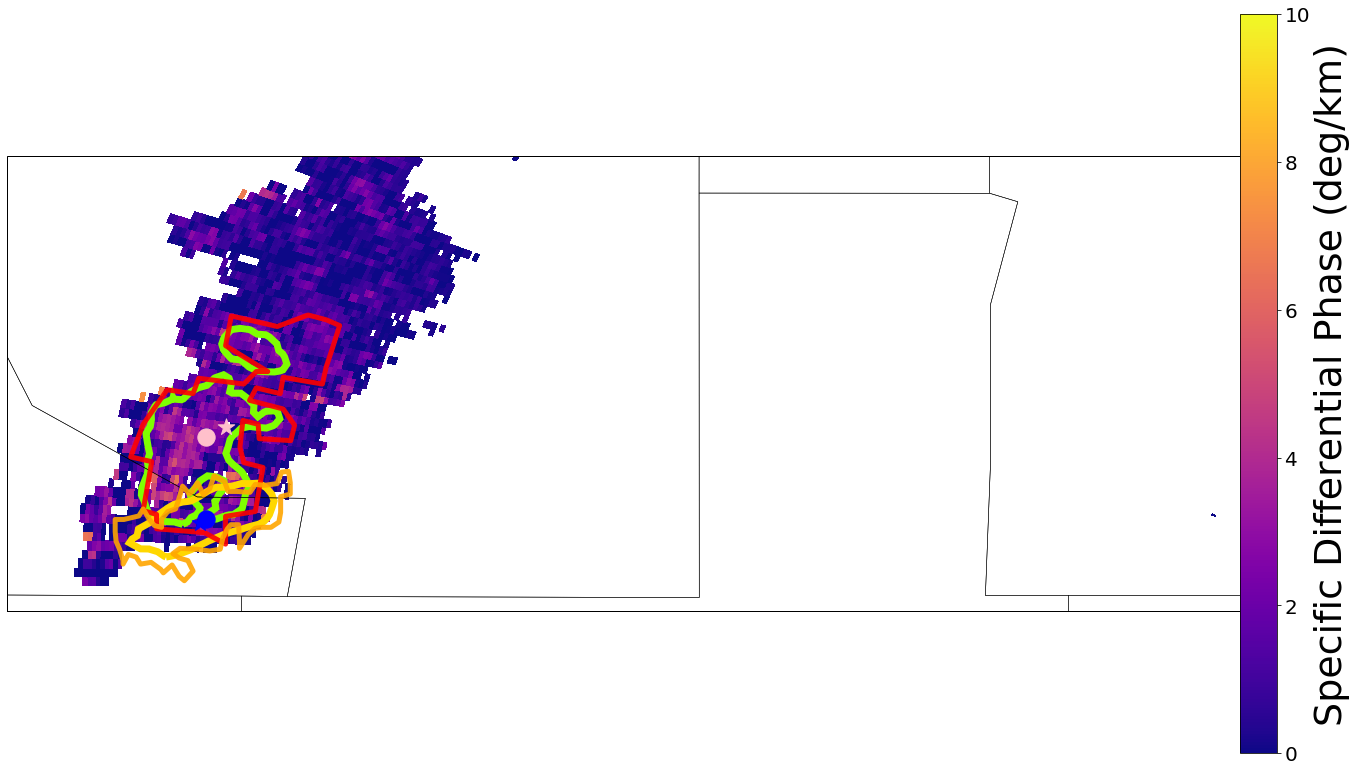

In [36]:
#Let's figure out which times don't have overlap
#Missing index 1 but should be able to recreate it
#Actually missing index 4 (2335), 18 (2358), 19 (0000), 37 (0029) 
LL = crs.transform_point(cenlon-0.55,cenlat-0.12,ccrs.PlateCarree())
UR = crs.transform_point(cenlon+0.25,cenlat+0.12,ccrs.PlateCarree())
ind_kdp = 2
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
refp = ax.pcolormesh(lon_arrays[ind_kdp], lat_arrays[ind_kdp], kdp_arrays[ind_kdp], cmap=plt.cm.plasma, vmin = 0, vmax = 10)
cg = plt.colorbar(refp, shrink=0.80, pad=0)
cg.ax.tick_params(labelsize=20)
cg.set_label("Specific Differential Phase (deg/km)",size = 38)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
foot = ax.add_feature(footshapefilesc[ind_kdp], edgecolor = 'red', linewidth=5, alpha=0.9)
arc = ax.add_feature(arcshapefilesc[ind_kdp], edgecolor = 'orange', linewidth=5, alpha=0.9)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
for i in range(len(foot_outlines1[ind_kdp])):
    print(i)
    patch = PathPatch(foot_outlines1[ind_kdp][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
    ax.add_patch(patch)
for k in range(len(arc_outlines4[ind_kdp])):
    print(k)
    patch = PathPatch(arc_outlines4[ind_kdp][k], facecolor = 'none', edgecolor='gold', linewidth=7)
    ax.add_patch(patch)
plt.scatter(arc_clonsc[ind_kdp], arc_clatsc[ind_kdp], s=300, marker='*', color='blue', zorder=13)
plt.scatter(foot_clonsc[ind_kdp], foot_clatsc[ind_kdp], s=300, marker='*', color='pink', zorder=13)

plt.scatter(arc_alg_cenlons[ind_kdp], arc_alg_cenlats[ind_kdp], s=300, marker='o', color='blue', zorder=13)
plt.scatter(foot_alg_cenlons[ind_kdp], foot_alg_cenlats[ind_kdp], s=300, marker='o', color='pink', zorder=13)

plt.tight_layout()
#plt.savefig('TalkZDR.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


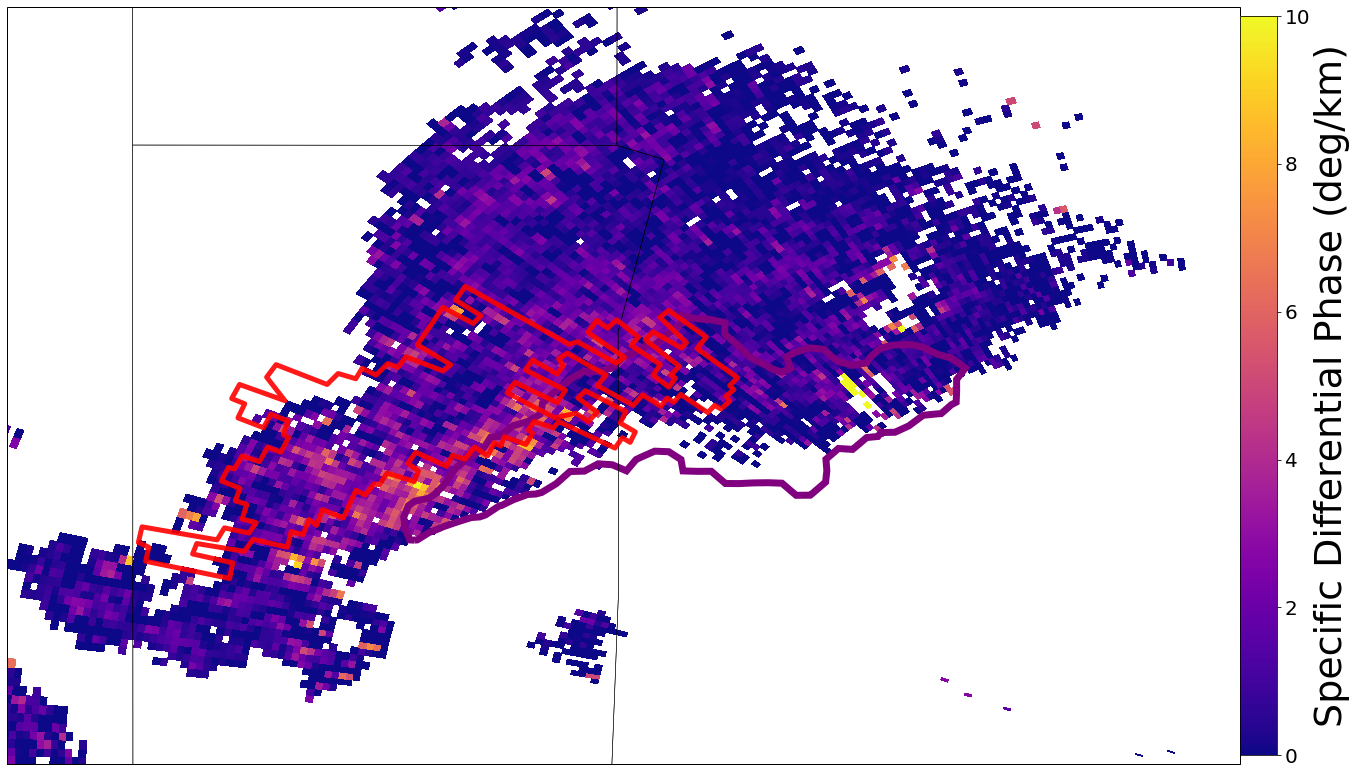

In [37]:
LL1 = crs.transform_point(cenlon-0.15,cenlat-0.10,ccrs.PlateCarree())
UR1 = crs.transform_point(cenlon+0.33,cenlat+0.16,ccrs.PlateCarree())
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
refp = ax.pcolormesh(lon_arrays[35], lat_arrays[35], kdp_arrays[35], cmap=plt.cm.plasma, vmin = 0, vmax = 10)
cg = plt.colorbar(refp, shrink=0.80, pad=0)
cg.ax.tick_params(labelsize=20)
cg.set_label("Specific Differential Phase (deg/km)",size = 38)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
arc = ax.add_feature(footshapefilesc[32], edgecolor = 'red', linewidth=5, alpha=0.9)
#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
ax.add_patch(patch)
plt.tight_layout()
#plt.savefig('TalkZDR.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


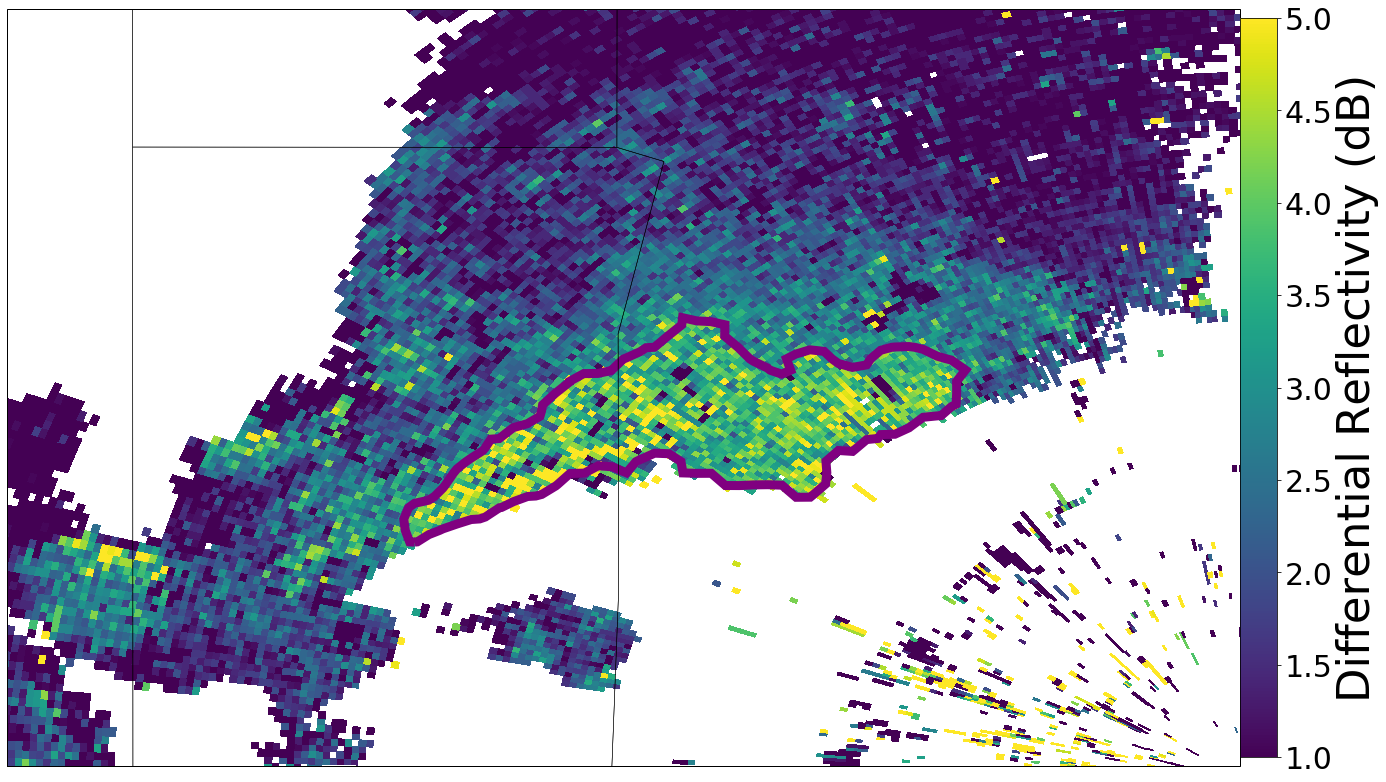

In [38]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
refp = ax.pcolormesh(lon_arrays[35], lat_arrays[35], zdr_arrays[35], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
cg = plt.colorbar(refp, shrink=0.80, pad=0)
cg.ax.tick_params(labelsize=30)
cg.set_label("Differential Reflectivity (dB)",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=9)
ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PaperZDR.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


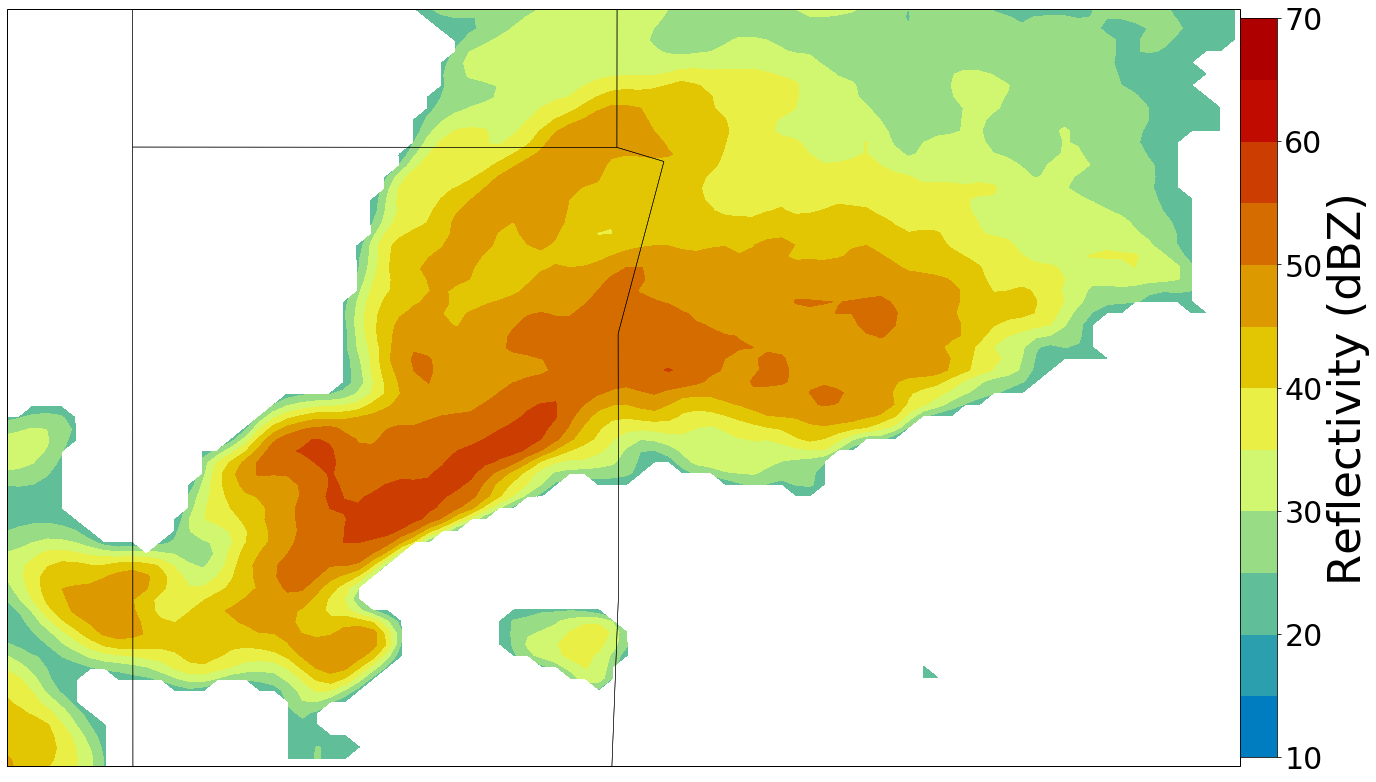

In [39]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
reflevs = np.arange(10, 75, 5)
refg = ax.contourf(rlons_2d, rlats_2d, REFmasked, reflevs, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridZ.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


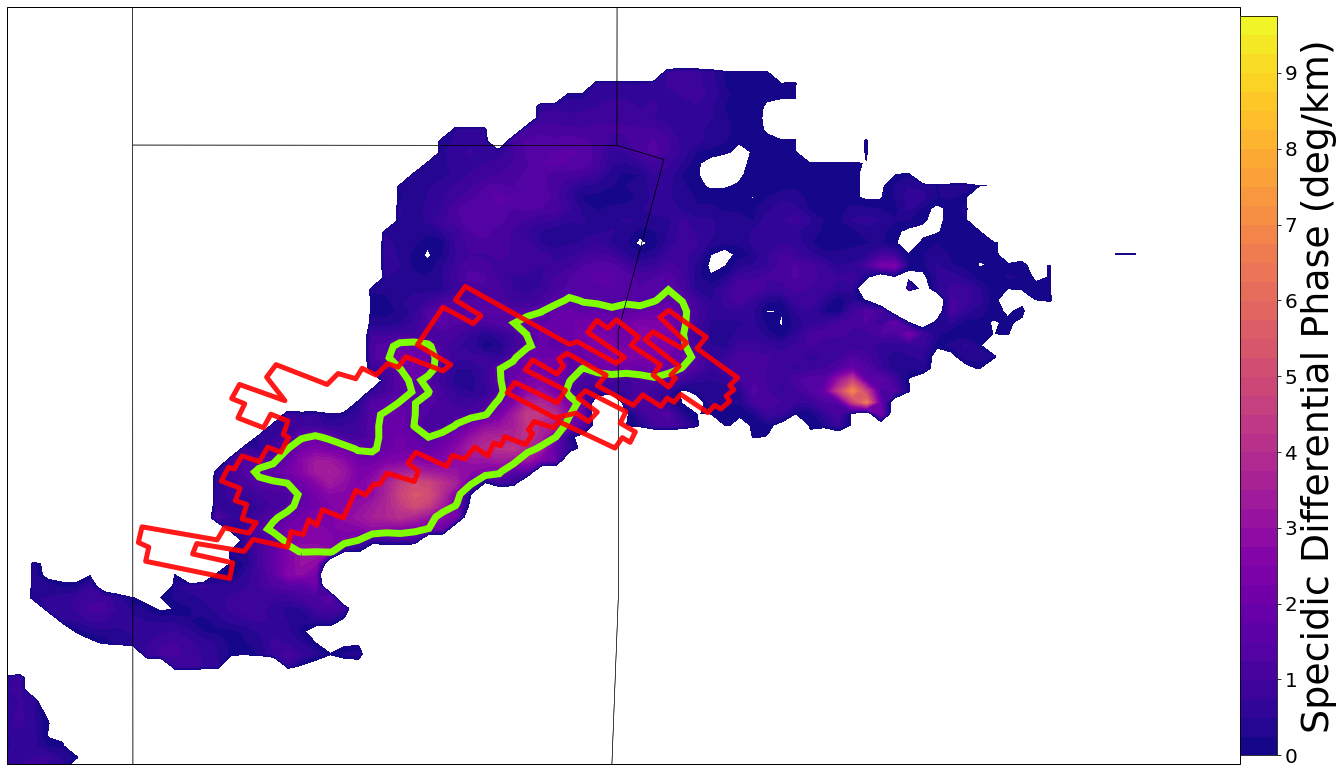

In [40]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
ind_kdp=35
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
kdplevs = np.arange(0, 10, 0.25)
kdp_clev = [1.5]
refg = ax.contourf(rlons_2d, rlats_2d, KDPmasked, kdplevs, cmap=plt.cm.plasma)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=20)
cg1.set_label("Specidic Differential Phase (deg/km)",size = 38)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
arc = ax.add_feature(footshapefilesc[ind_kdp-3], edgecolor = 'red', linewidth=5, alpha=0.9)
patch = PathPatch(foot_outlines1[ind_kdp][0], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
ax.add_patch(patch)
#ax.contour(rlons_2d, rlats_2d, KDPmasked, kdp_clev, colors='green', linewidths=5)
#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
#plt.savefig('TalkgridZDR.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


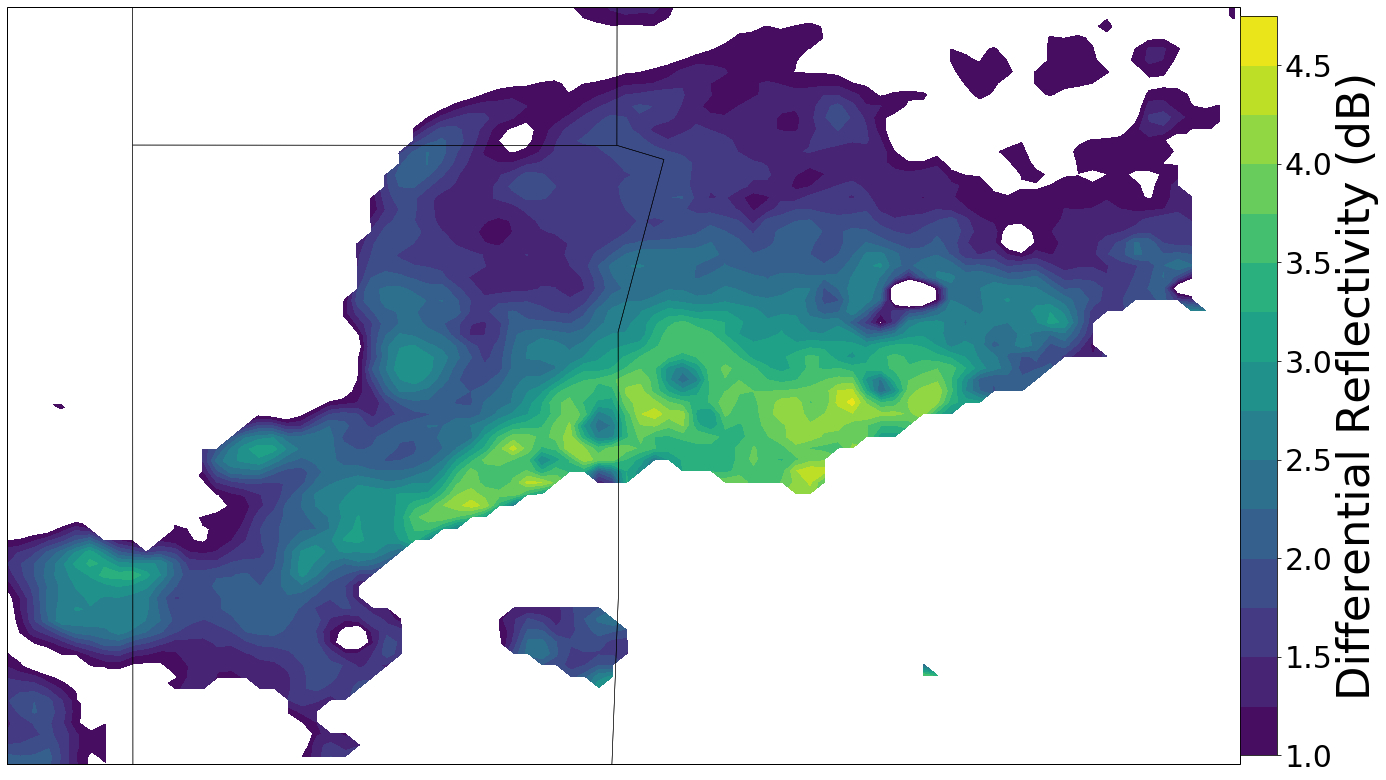

In [41]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
zdrlevs = np.arange(1, 5, 0.25)
refg = ax.contourf(rlons_2d, rlats_2d, ZDRmasked1, zdrlevs, cmap=plt.cm.viridis)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Differential Reflectivity (dB)",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridZDR.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


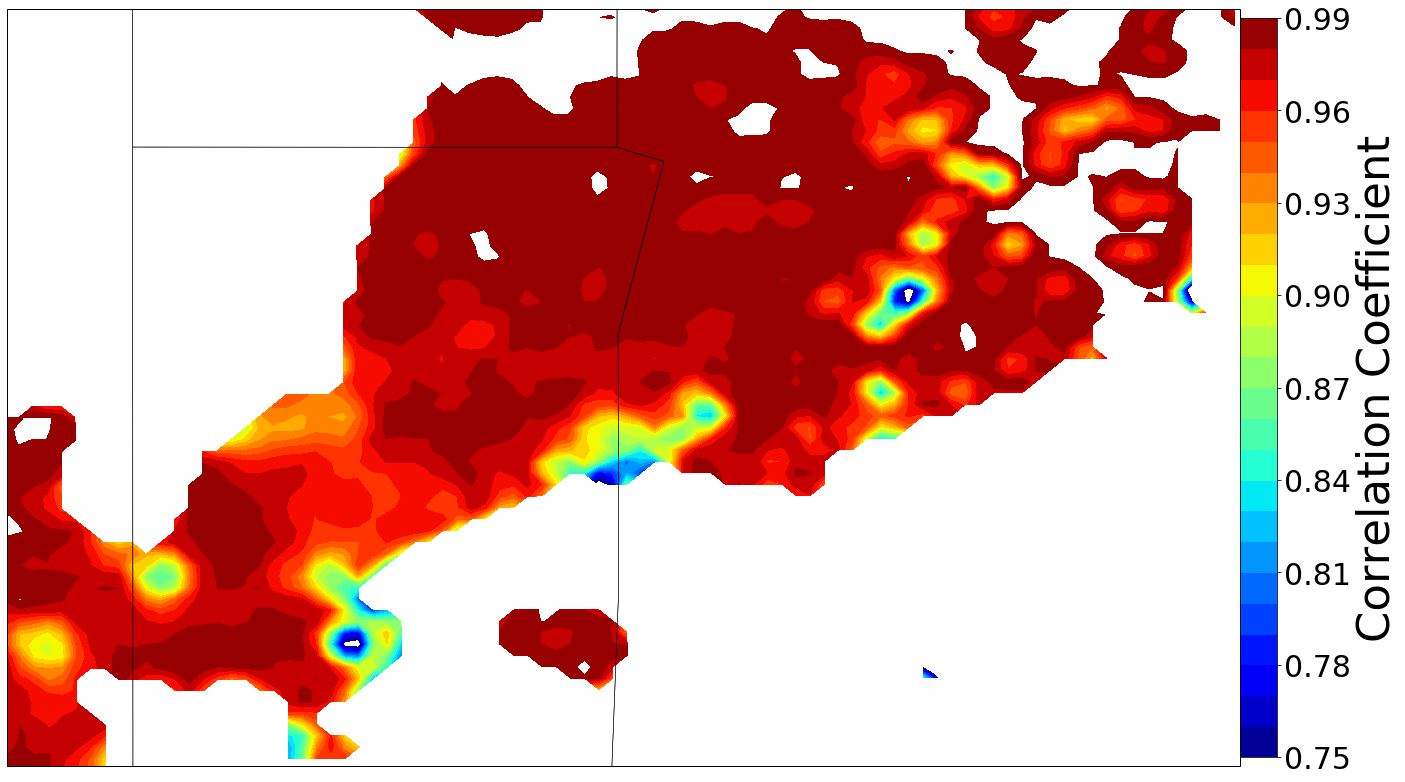

In [42]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
CClevs = np.arange(0.75, 1, 0.01)
refg = ax.contourf(rlons_2d, rlats_2d, CCmasked, CClevs, cmap=plt.cm.jet)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Correlation Coefficient",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
#plt.savefig('PapergridCC.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [43]:
smoothed_ref1 = ndi.gaussian_filter(REFmasked, sigma = 2, order = 0)
#      smoothed_ref1 = ndi.gaussian_filter(REF, sigma = 2, order = 0)
#     print ('smoothed')
REFgradient = np.asarray(np.gradient(smoothed_ref1))

# REFgradient = np.asarray(np.gradient(REF))
# REFgradient[0,:,:] = ma.masked_where(REF < 20., REFgradient[0,:,:])
#REFgradient[1,:,:] = ma.masked_where(REF < 20., REFgradient[1,:,:])
#    print('made it through gradient')
grad_dir1 = wind_direction(REFgradient[1,:,:] * units('m/s'), REFgradient[0,:,:] * units('m/s'))
grad_mag = wind_speed(REFgradient[1,:,:] * units('m/s'), REFgradient[0,:,:] * units('m/s'))
grad_dir = ma.masked_where(REF < 20, grad_dir1)
#Get difference between the gradient direction and the FFD gradient direction calculated earlier
srdir = 155
srirad = np.copy(srdir)*units('degrees').to('radian')
grad_dir = grad_dir*units('degrees').to('radian')
grad_ffd = np.abs(np.arctan2(np.sin(grad_dir-srirad), np.cos(grad_dir-srirad)))
#  print(grad_ffd)
#  print(np.max(grad_ffd))
#  print(np.min(grad_ffd))
grad_ffd = np.asarray(grad_ffd)*units('radian')
grad_ex = np.copy(grad_ffd)
grad_ffd = grad_ffd.to('degrees')
grad_ffd = ma.masked_where(REF < 20, grad_ffd)
grad_ffd = ma.filled(grad_ffd, fill_value=np.nan)

In [44]:
print(grad_ffd)

[[      nan       nan       nan ... 117.98365 119.42482 121.32227]
 [      nan       nan       nan ... 119.12686 121.14447 123.80256]
 [      nan       nan       nan ... 121.1336  124.20226 128.21967]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


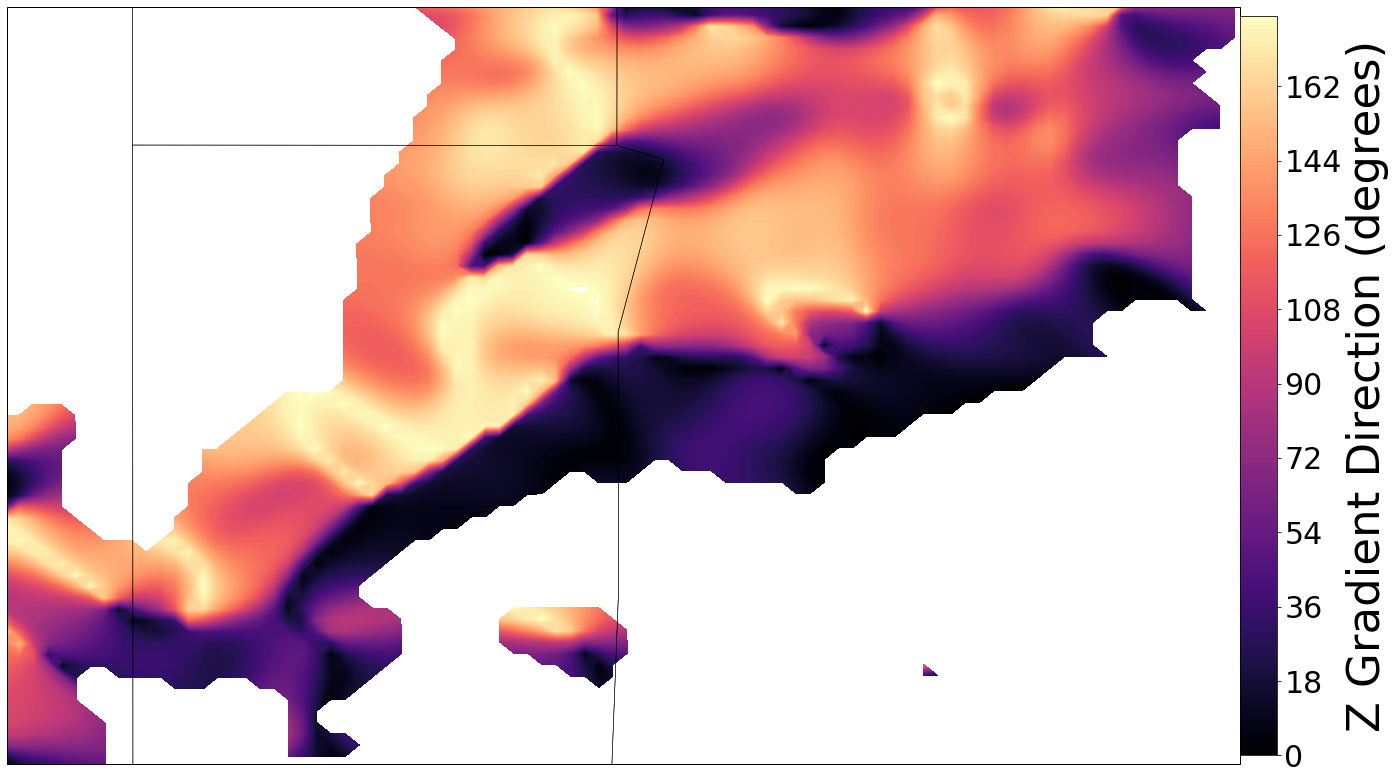

In [45]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
ffdlevs = np.arange(0, 180, 1)
refg = ax.contourf(rlons_2d, rlats_2d, grad_ffd, ffdlevs, cmap=plt.cm.magma)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Z Gradient Direction (degrees)",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refc = ax.contour(rlons_2d, rlats_2d, grad_ffd, [60], color='purple', linewidths=7)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridGrad.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\cartopy\mpl\geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


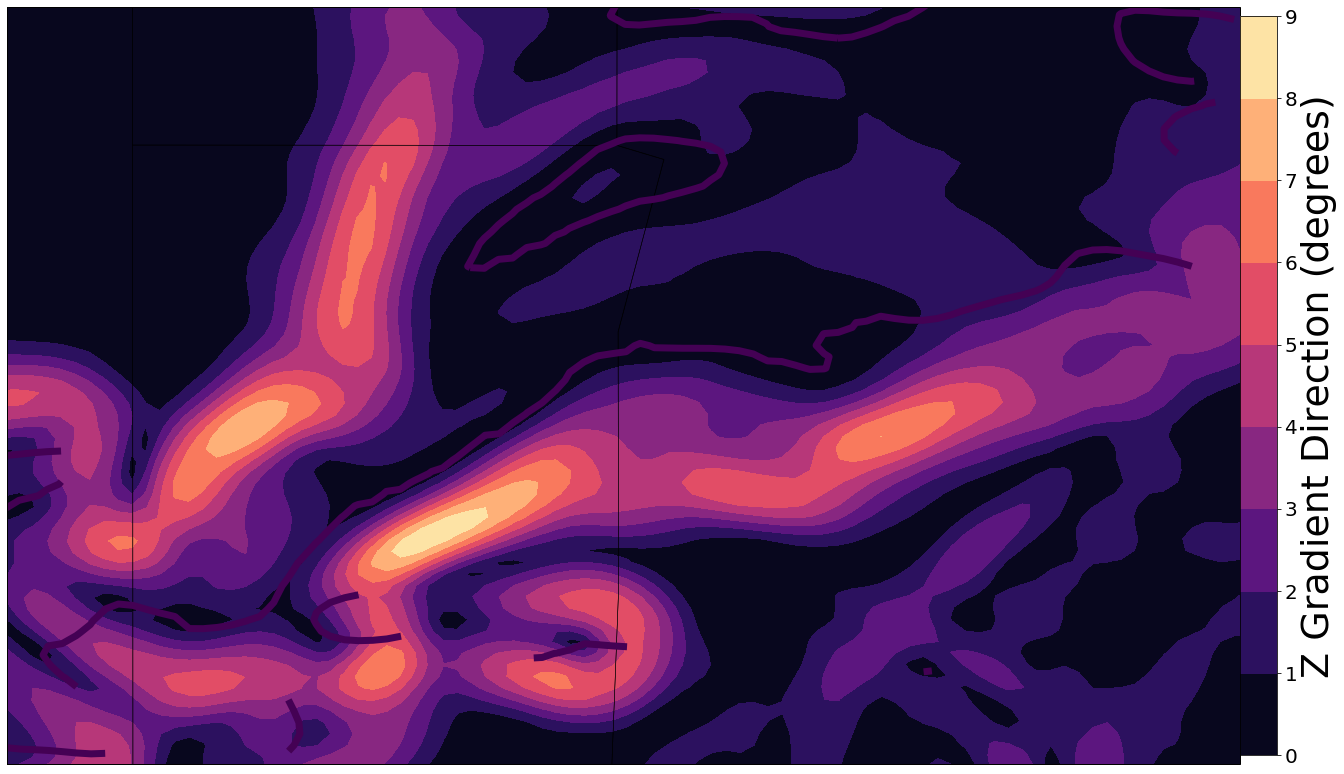

In [46]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
ffdlevs = np.arange(0, 10, 1)
refg = ax.contourf(rlons_2d, rlats_2d, grad_mag, ffdlevs, cmap=plt.cm.magma)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=20)
cg1.set_label("Z Gradient Direction (degrees)",size = 38)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
refc = ax.contour(rlons_2d, rlats_2d, grad_ffd, [60], color='purple', linewidths=7)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('TalkgridGrad.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [47]:
print(grad_ffd)

[[      nan       nan       nan ... 117.98365 119.42482 121.32227]
 [      nan       nan       nan ... 119.12686 121.14447 123.80256]
 [      nan       nan       nan ... 121.1336  124.20226 128.21967]
 ...
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]
 [      nan       nan       nan ...       nan       nan       nan]]


In [48]:
#Mask out areas where the difference between the two is too large and the ZDR is likely not in the forward flank
ZDRmasked2 = ma.masked_where(grad_ffd > 120, ZDRmasked1)
ZDRmasked = ma.masked_where(CC < .60, ZDRmasked2)
#Add a fill value for the ZDR mask so that contours will be closed
ZDRmasked3 = ma.filled(ZDRmasked, fill_value = -2)

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


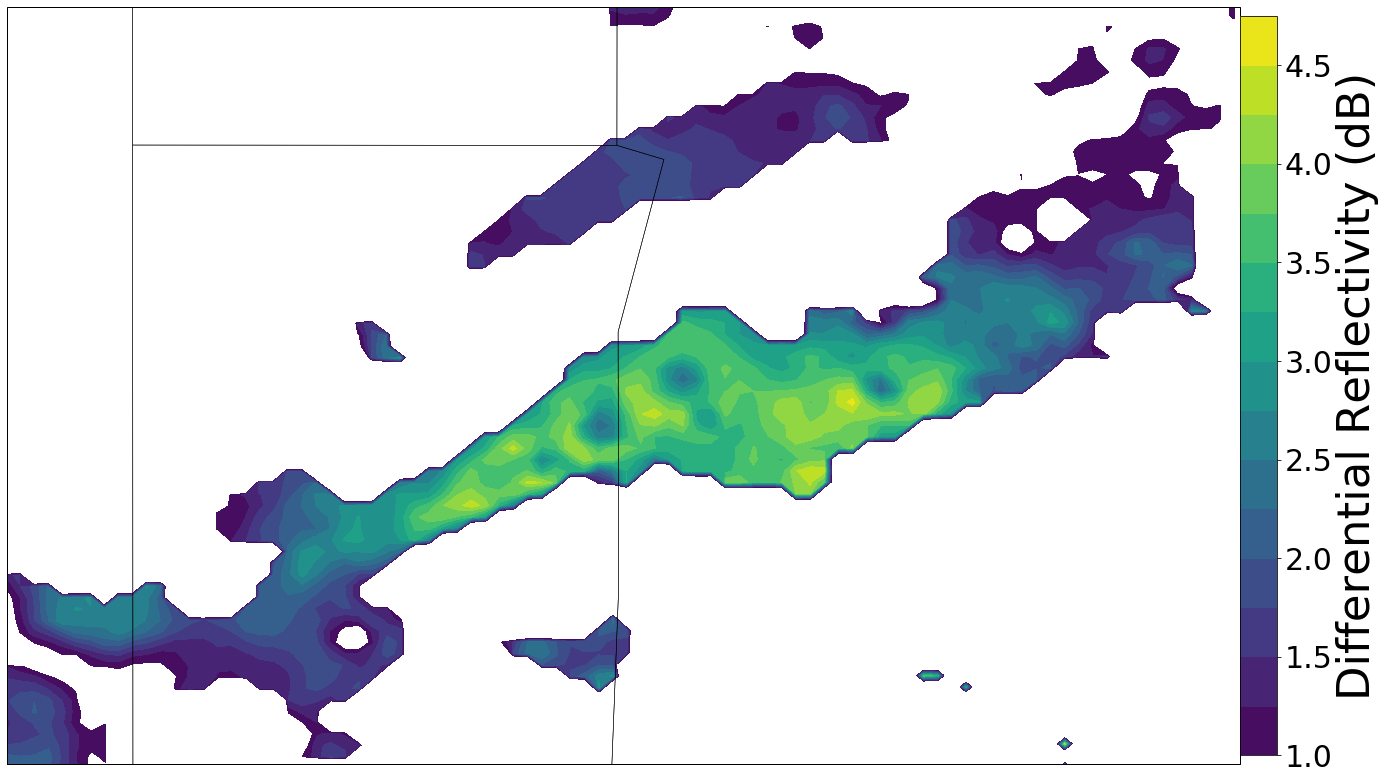

In [49]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
zdrlevs = np.arange(1, 5, 0.25)
refg = ax.contourf(rlons_2d, rlats_2d, ZDRmasked3, zdrlevs, cmap=plt.cm.viridis)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Differential Reflectivity (dB)",size = 45)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridZDRmask.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


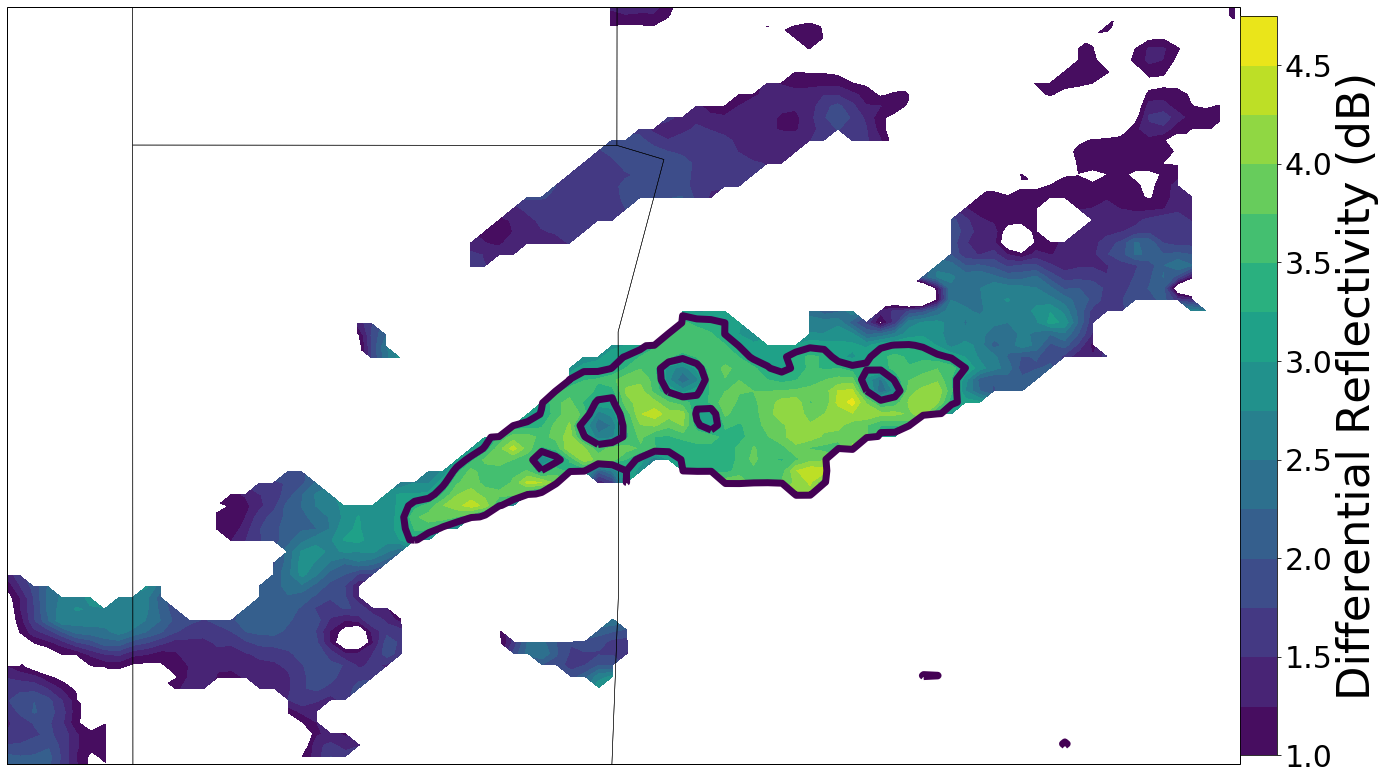

In [50]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
zdrlevs = np.arange(1, 5, 0.25)
refg = ax.contourf(rlons_2d, rlats_2d, ZDRmasked, zdrlevs, cmap=plt.cm.viridis)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Differential Reflectivity (dB)",size = 45)
refc = ax.contour(rlons_2d, rlats_2d, ZDRmasked3, [3.25], color='purple', linewidths=7)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridZDRmaskc.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [51]:
#pr_area1 = (transform(proj, arcshapefiles[1]).area * units('m^2')).to('km^2')

In [52]:
import geopandas
file1 = geopandas.read_file('ZDRarcshapefiles/ARCKINX0001.shp')

In [53]:
filematrix = file1['geometry']

In [54]:
print(filematrix[0])

POLYGON ((-96.00969805384136 36.3278398552242, -95.99947618252472 36.3278398552242, -95.99509538053188 36.31761798390756, -95.99436524686641 36.3081262462564, -95.99144471220451 36.29717424127429, -95.99144471220451 36.2854921026267, -96.00458711818304 36.27234969664817, -96.02065005882348 36.26504835999343, -96.03817326679486 36.25628675600774, -96.05715674209718 36.24752515202205, -96.07614021739953 36.23876354803636, -96.09731409369826 36.23219234504709, -96.10899623234585 36.22927181038519, -96.10534556401848 36.24022381536731, -96.09950449469468 36.24752515202205, -96.10388529668752 36.25044568668395, -96.11994823732796 36.24095394903278, -96.12359890565533 36.24679501835657, -96.10534556401848 36.25482648867679, -96.09293329170541 36.25993742433511, -96.08052101939235 36.26431822632795, -96.06591834608287 36.27307983031364, -96.05058553910791 36.28330170163028, -96.03890340046033 36.29206330561597, -96.03233219747106 36.30447557792903, -96.02503086081632 36.30885637992188, -96.00

In [55]:
pr_area1 = (transform(proj, filematrix[0]).area * units('m^2')).to('km^2')

In [56]:
print(pr_area1)

65.46454533525565 kilometer ** 2


In [57]:
#Read the pickle file from the algorithm for this case
alg_325 = pd.read_pickle('Shape_Comparison_Case2016331KINX.pkl')
storm1 = alg_325.xs(1, level = 1)
storm1_alg_f = np.asarray(storm1['zdr_area'].iloc[:])

#Read the pickle file from the algorithm for this case
alg_350 = pd.read_pickle('Shape_Comparison_Case3502016331KINX.pkl')
storm2 = alg_350.xs(1, level = 1)
storm2_alg_f = np.asarray(storm2['zdr_area'].iloc[:])

#Read the pickle file from the algorithm for this case
alg_3503 = pd.read_pickle('Shape_Comparison_Case3502016330KINX.pkl')
storm3 = alg_3503.xs(2, level = 1)
storm3_alg_f = np.asarray(storm3['zdr_area'].iloc[:])

#Read the pickle file from the algorithm for this case
alg_3253 = pd.read_pickle('Shape_Comparison_Case2016330KINX.pkl')
storm4 = alg_3253.xs(2, level = 1)
storm4_alg_f = np.asarray(storm4['zdr_area'].iloc[:])

#Read the pickle file from the algorithm for this case
alg_32590 = pd.read_pickle('CI_TOR902016330KINX.pkl')
storm5 = alg_32590.xs(2, level = 1)
storm5_alg_f = np.asarray(storm5['zdr_area'].iloc[:])

In [58]:
print(alg_3253.xs(35, level=0)['storm_lon'])
storm_lons = alg_3253.xs(35, level=0)['storm_lon']
storm_lats = alg_3253.xs(35, level=0)['storm_lat']

storm_id
2    -95.824665
26   -95.801351
11   -95.658850
25   -96.321912
21   -96.212078
6    -95.665000
23   -96.062670
23   -96.051166
24   -95.888923
14   -95.482947
5    -96.037217
Name: storm_lon, dtype: float64


In [59]:
print(storm_lons.index.values)
storm_ids = storm_lons.index.values

[ 2 26 11 25 21  6 23 23 24 14  5]


In [60]:
print(storm_lons.values[0])

-95.82466497908534


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


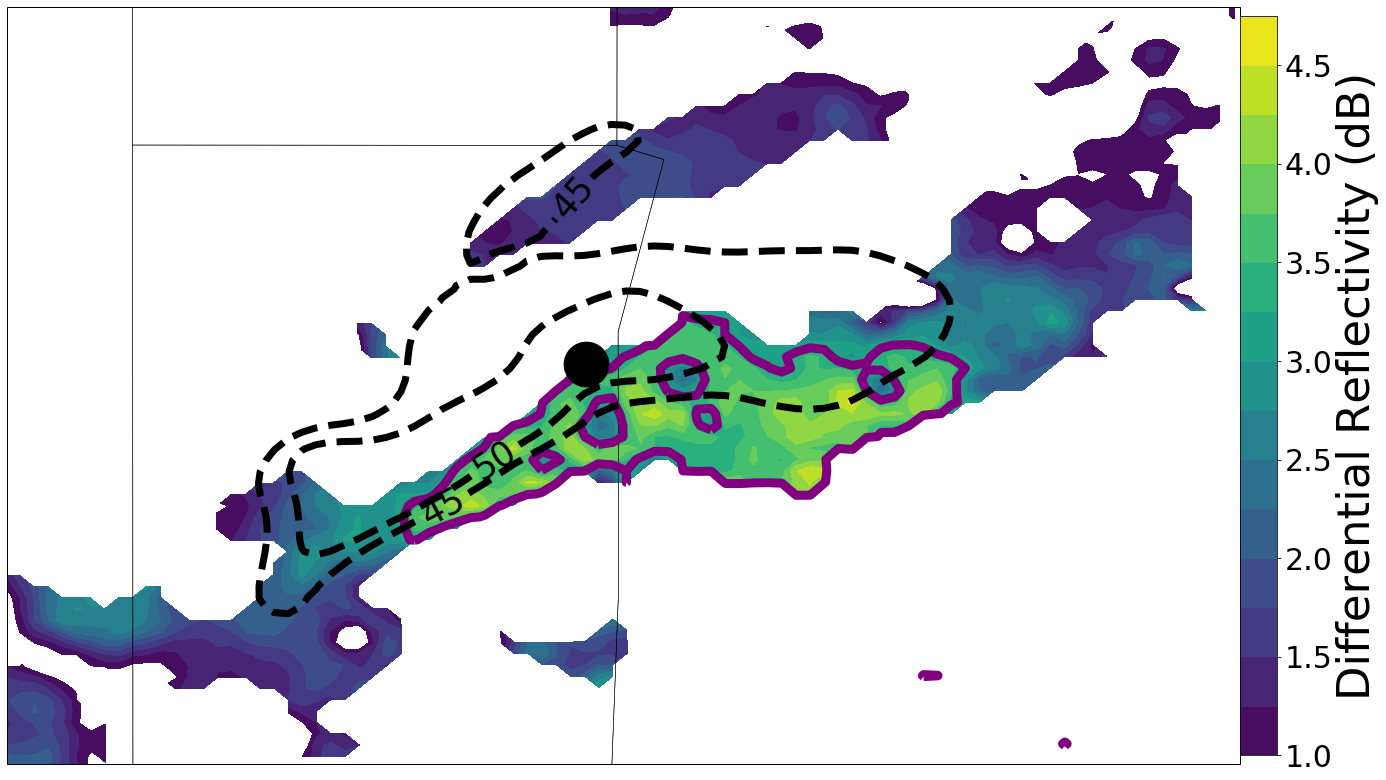

In [61]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL1[0],UR1[0],LL1[1],UR1[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.inferno(i*10), facecolor = plt.cm.inferno(i*10), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, zdr_c, cmap=plt.cm.magma, vmin = 1, vmax = 6)
#refp = ax.pcolormesh(lon_arrays[51], lat_arrays[51], zdr_arrays[51], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
zdrlevs = np.arange(1, 5, 0.25)
refg = ax.contourf(rlons_2d, rlats_2d, ZDRmasked, zdrlevs, cmap=plt.cm.viridis)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Differential Reflectivity (dB)",size = 45)
refc = ax.contour(rlons_2d, rlats_2d, ZDRmasked3, [3.25], colors='purple', linewidths=9)
z =  ax.contour(rlons_2d, rlats_2d, smoothed_ref1, [45, 50], colors='k', linewidths=7, linestyles = '--')
plt.clabel(z, fontsize=35, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.scatter(storm_lons, storm_lats, s=2000, color='k', zorder=10)
#ax.text(storm_lons.values[0]+0.0095, storm_lats.values[0]+0.0095, 'Storm '+str(storm_ids[0]), size = 40, color='red')
#ax.add_feature(arcshapefilesc[35], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
#patch = PathPatch(arc_outlines4[35][0], facecolor = 'none', edgecolor='purple', linewidth=7)
#ax.add_patch(patch)
plt.tight_layout()
plt.savefig('PapergridZDRmaskcstorms.png')
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [62]:
print(storm3_alg_f.shape)
print(storm3)

(40,)
      kdp_zdr_angle  kdp_zdr_sep  storm_id1  storm_lat  storm_lon  \
scan                                                                
0          0.000000     0.000000          2  36.273842 -96.330436   
1         32.470352     6.687935          2  36.278076 -96.317956   
2        -19.875502     5.659109          2  36.282260 -96.299022   
3        -68.036342     6.285633          2  36.290632 -96.279615   
4        -36.447610     4.373318          2  36.300293 -96.259575   
5        -52.601871     6.239279          2  36.304565 -96.244920   
6          0.000000     0.000000          2  36.307068 -96.235513   
7          0.000000     0.000000          2  36.304999 -96.229923   
8          0.000000     0.000000          2  36.298661 -96.221792   
9        -60.954116     7.136868          2  36.299098 -96.209316   
10       -63.194358     8.110257          2  36.299486 -96.201950   
11       -65.507861     9.426191          2  36.301148 -96.192103   
12         0.000000     0.00

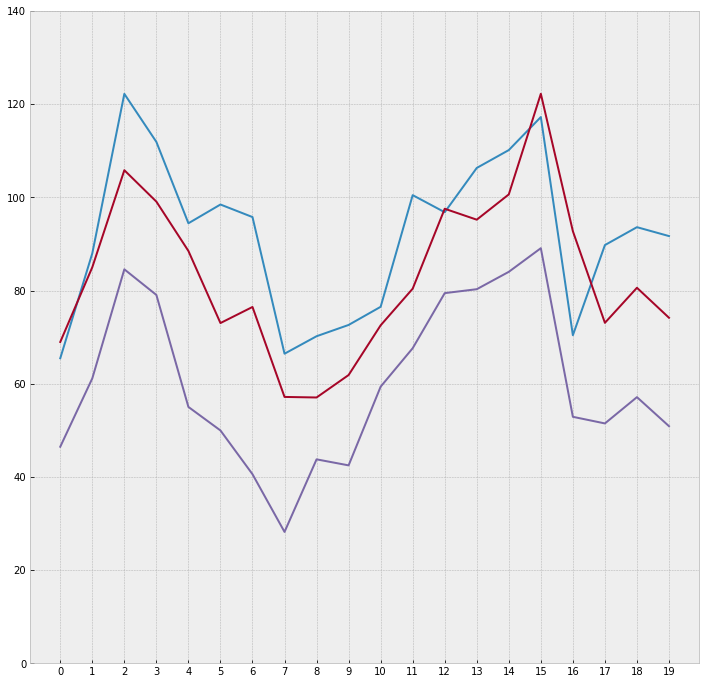

In [63]:
plt.style.use('bmh')
fig = plt.figure(1, (12, 12))
x = np.arange(0, len(arcshapefiles[1:21]), 1)
plt.plot(x, np.asarray(areas[1:21]))
plt.plot(x, storm1_alg_f[0:20])
plt.plot(x, storm2_alg_f[0:20])
#plt.plot(x, storm5_alg_f[0:20])


#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])

plt.ylim(0, 140)
plt.xticks(x)
plt.show()

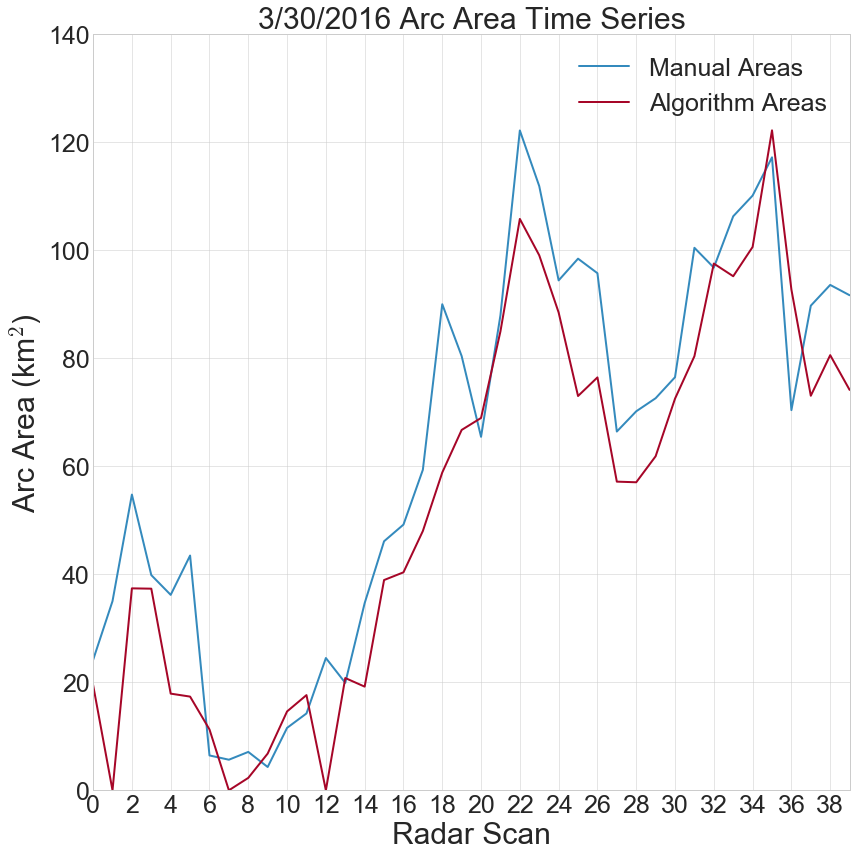

In [112]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
x = np.arange(0, len(arcshapefilesc), 1)
x1 = np.arange(0, len(arcshapefiles[0:21]), 1)
plt.plot(x, np.asarray(areasc), label='Manual Areas')
#plt.plot(x1+19, np.asarray(areas[0:21]))
#plt.plot(x1[1:21]+19, storm1_alg_f[0:20])
#plt.plot(x1[1:21]+19, storm2_alg_f[0:20])
#plt.plot(x, storm3_alg_f[0:40])
plt.plot(x, storm4_alg_f[0:40], label='Algorithm Areas')
#plt.plot(x, storm5_alg_f[0:40], label='Algorithm Areas')

plt.title('3/30/2016 Arc Area Time Series', size=30)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
plt.xlabel('Radar Scan', size=30)
plt.ylabel('Arc Area (km$^2$)', size=30)
plt.ylim(0, 140)
plt.xlim(0, 39)
plt.xticks(x[::2], size=25)
plt.yticks(size=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig('PaperArcTimeSeries.png')
plt.show()

In [65]:
print(arctextc)
print(len(arctextc))

['ARCKINX2329.shp', 'ARCKINX2330.shp', 'ARCKINX2332.shp', 'ARCKINX2333.shp', 'ARCKINX2335.shp', 'ARCKINX2337.shp', 'ARCKINX2339.shp', 'ARCKINX2340.shp', 'ARCKINX2342.shp', 'ARCKINX2344.shp', 'ARCKINX2345.shp', 'ARCKINX2347.shp', 'ARCKINX2348.shp', 'ARCKINX2350.shp', 'ARCKINX2351.shp', 'ARCKINX2353.shp', 'ARCKINX2355.shp', 'ARCKINX2357.shp', 'ARCKINX2358.shp', 'ARCKINX0000.shp', 'ARCKINX0001.shp', 'ARCKINX0003.shp', 'ARCKINX0005.shp', 'ARCKINX0006.shp', 'ARCKINX0008.shp', 'ARCKINX0010.shp', 'ARCKINX0011.shp', 'ARCKINX0013.shp', 'ARCKINX0014.shp', 'ARCKINX0016A.shp', 'ARCKINX0018.shp', 'ARCKINX0019.shp', 'ARCKINX0021.shp', 'ARCKINX0023.shp', 'ARCKINX0024.shp', 'ARCKINX0026.shp', 'ARCKINX0027.shp', 'ARCKINX0029.shp', 'ARCKINX0031.shp', 'ARCKINX0032.shp']
40


In [66]:
print(storm3['times'].iloc[:])

scan
0    2016-03-30 23:29:00.664
1    2016-03-30 23:30:22.717
2    2016-03-30 23:32:15.255
3    2016-03-30 23:33:53.287
4    2016-03-30 23:35:51.688
5    2016-03-30 23:37:40.281
6    2016-03-30 23:39:00.713
7    2016-03-30 23:40:33.013
8    2016-03-30 23:42:13.109
9    2016-03-30 23:44:06.118
10   2016-03-30 23:45:28.196
11   2016-03-30 23:47:04.379
12   2016-03-30 23:48:44.572
13   2016-03-30 23:50:33.159
14   2016-03-30 23:51:53.553
15   2016-03-30 23:53:26.341
16   2016-03-30 23:55:07.043
17   2016-03-30 23:57:05.075
18   2016-03-30 23:58:14.451
19   2016-03-31 00:00:05.646
20   2016-03-31 00:01:50.283
21   2016-03-31 00:03:43.475
22   2016-03-31 00:05:05.472
23   2016-03-31 00:06:39.348
24   2016-03-31 00:08:20.865
25   2016-03-31 00:10:14.024
26   2016-03-31 00:11:36.134
27   2016-03-31 00:13:11.593
28   2016-03-31 00:14:53.413
29   2016-03-31 00:16:41.832
30   2016-03-31 00:18:02.568
31   2016-03-31 00:19:36.634
32   2016-03-31 00:21:16.770
33   2016-03-31 00:23:14.778
34   2016

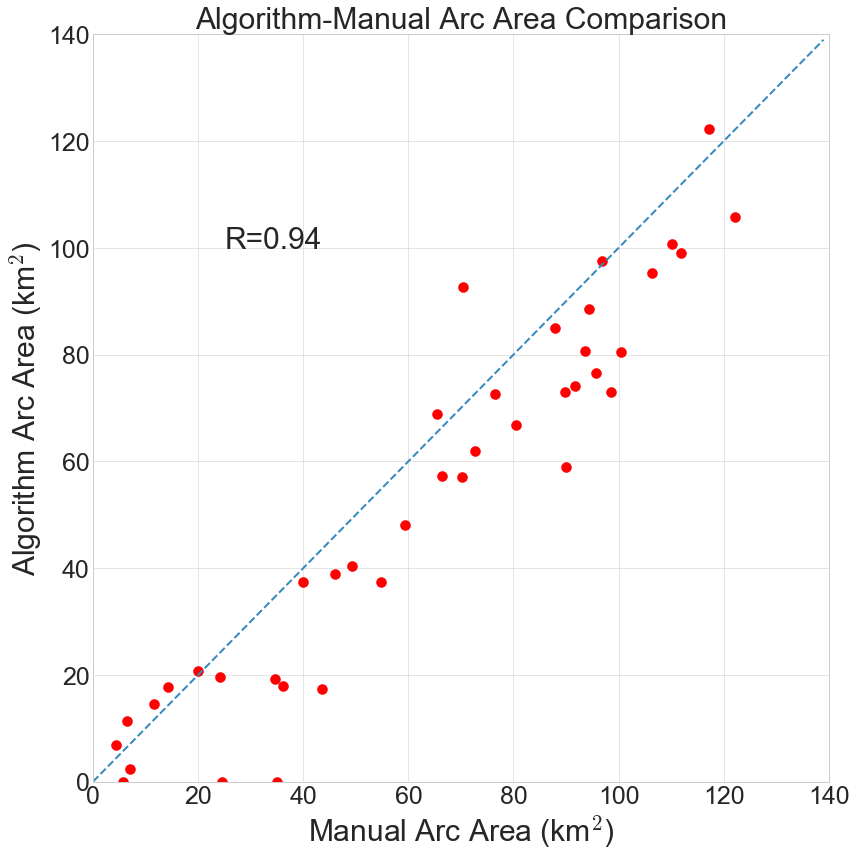

In [115]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
#x = np.arange(0, len(arcshapefiles[1:21]), 1)
#plt.scatter(np.asarray(areasc), storm3_alg_f[0:40], label='3.5 dB Alg')
plt.scatter(np.asarray(areasc), storm4_alg_f[0:40], color='r', s=100, alpha=1.0)
#plt.scatter(np.asarray(areasc), storm5_alg_f[0:40], color='g', s=100, alpha=0.5)

plt.xlim(0,140)
plt.ylim(0,140)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Manual Arc Area (km$^2$)', size=30)
plt.ylabel('Algorithm Arc Area (km$^2$)', size=30)
plt.title('Algorithm-Manual Arc Area Comparison', size=30)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
line = np.arange(0, 140, 1)
plt.plot(line, line, linestyle='--', linewidth=2)
plt.text(25, 100, 'R=0.94', size=30)
plt.tight_layout()
plt.savefig('PaperAlgScatterVerif.png')
plt.show()

In [68]:
print(footareasc)

[125.48942584927062, 140.76402524330658, 140.76402524330658, 70.26177404055674, nan, 85.62444451558392, 78.84924762635892, 79.90686520666652, 82.59117110979392, 72.2136814872078, 91.26849156760552, 76.21544359486228, 96.74334854517713, 95.68601015241012, 98.85586129382612, 113.79477921320326, 110.24426714650018, 139.22936279519743, nan, nan, 102.86866981326074, 111.9073566716252, 98.42229138300621, 94.98774352481912, 80.26614169432534, 84.2880856295963, 96.00736171913117, 100.00492462026895, 92.07568607096783, 114.8853483806484, 123.04313924237238, 133.60684468754758, 123.59516901093157, 127.10442007453186, 106.15456837823692, 93.24333678164729, 93.56204136427084, nan, 107.86343665841639, 106.97571985894974]


In [69]:
print(np.asarray(footareasc) - np.asarray(foot_alg_areas))

[ 18.57339789  51.45457032  54.72088868   2.62410691          nan
  13.19725614  15.56607913   5.9828586    9.57636398   3.75981288
   1.91576968   3.27128582  10.87443738   6.82301355 -10.90404307
   9.4383103   16.56096726  26.27873906          nan          nan
 -15.38114566   3.63545157   5.77699112   7.08669624  -5.3683876
   6.18351371  14.63935062   9.28551462  -4.65244277   7.08194267
   4.91576109  21.89964757  23.1517079   14.51763391   1.98980697
   0.71324953   3.21494775          nan   4.51307303  13.9143727 ]


In [70]:
import scipy.stats as stats

In [71]:
foot_areas_arr = np.asarray(np.asarray(footareasc))
foot_areas_arr1 = foot_areas_arr[~np.isnan(foot_areas_arr)]
foot_alg_areas1 = np.asarray(foot_alg_areas)
foot_alg_areas2 = foot_alg_areas1[~np.isnan(foot_areas_arr)]
foot_spr = stats.spearmanr(foot_areas_arr1, foot_alg_areas2)
print(foot_spr)

SpearmanrResult(correlation=0.7589935017969118, pvalue=8.095875129269167e-08)


In [72]:
arc_spr = stats.spearmanr(np.asarray(areasc), storm4_alg_f[0:40])
print(arc_spr)

SpearmanrResult(correlation=0.9390129645532088, pvalue=3.300817383169826e-19)


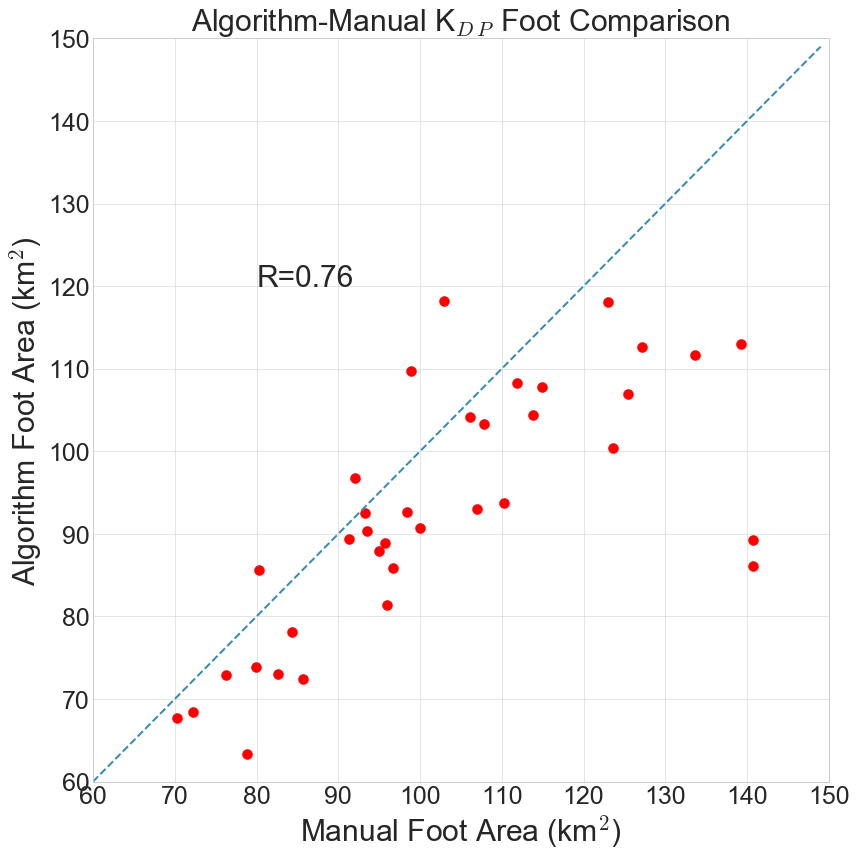

In [109]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
#x = np.arange(0, len(arcshapefiles[1:21]), 1)
#plt.scatter(np.asarray(areasc), storm3_alg_f[0:40], label='3.5 dB Alg')
plt.scatter(np.asarray(footareasc), foot_alg_areas, color='r', s=100, alpha=1.0)
#plt.scatter(np.asarray(areasc), storm5_alg_f[0:40], color='g', s=100, alpha=0.5)

plt.xlim(60,150)
plt.ylim(60,150)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Manual Foot Area (km$^2$)', size=30)
plt.ylabel('Algorithm Foot Area (km$^2$)', size=30)
plt.title('Algorithm-Manual K$_D$$_P$ Foot Comparison', size=30)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
line = np.arange(0, 150, 1)
plt.plot(line, line, linestyle='--', linewidth=2)
plt.text(80, 120, 'R=0.76', size=30)
plt.tight_layout()
plt.savefig('PaperFootScatterVerif.png')
plt.show()

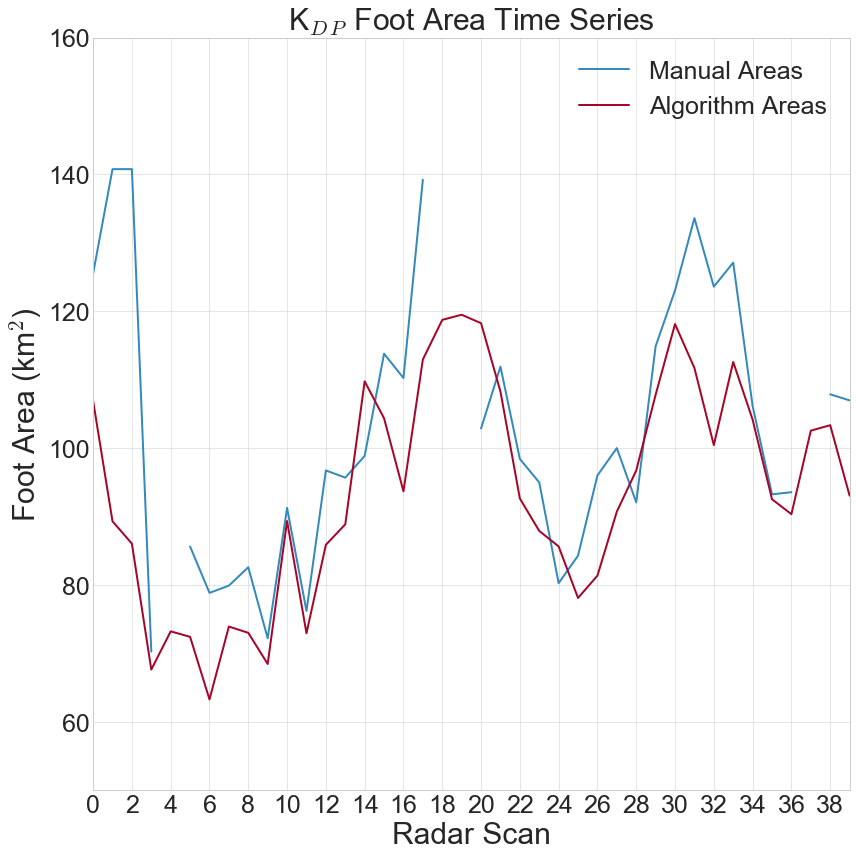

In [111]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
x = np.arange(0, len(footshapefilesc), 1)
x1 = np.arange(0, len(footshapefiles[0:21]), 1)
plt.plot(x, np.asarray(footareasc), label='Manual Areas')
#plt.plot(x1+19, np.asarray(areas[0:21]))
#plt.plot(x1[1:21]+19, storm1_alg_f[0:20])
#plt.plot(x1[1:21]+19, storm2_alg_f[0:20])
#plt.plot(x, storm3_alg_f[0:40])
#plt.plot(x, storm4_alg_f[0:40], label='Algorithm Areas')
plt.plot(x, foot_alg_areas, label='Algorithm Areas')

plt.title('K$_D$$_P$ Foot Area Time Series', size=30)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
plt.xlabel('Radar Scan', size=30)
plt.ylabel('Foot Area (km$^2$)', size=30)
plt.ylim(50, 160)
plt.xlim(0, 39)
plt.xticks(x[::2], size=25)
plt.yticks(size=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig('PaperFootTimeSeries.png')
plt.show()

In [75]:
print(stats.linregress(np.asarray(areasc), storm3_alg_f[0:40]))
print(stats.linregress(np.asarray(areasc), storm4_alg_f[0:40]))
print(stats.linregress(np.asarray(areasc), storm5_alg_f[0:40]))

LinregressResult(slope=0.7190440706223444, intercept=-7.221927165046004, rvalue=0.9434707662001249, pvalue=8.115282328089393e-20, stderr=0.0409789492914374)
LinregressResult(slope=0.9316422725921879, intercept=-5.393334004287716, rvalue=0.9496598530953918, pvalue=9.463296506399497e-21, stderr=0.04985698053197841)
LinregressResult(slope=0.874332865170967, intercept=-2.2330663898318406, rvalue=0.9553078839256949, pvalue=1.0363095792183433e-21, stderr=0.043889908742303356)


In [76]:
arc_outlines = pd.read_pickle('ZDRoutlines2016331KINX.pkl')
arc_outlines2 = pd.read_pickle('ZDRoutlines3502016331KINX.pkl')
arc_outlines3 = pd.read_pickle('ZDRoutlines3502016330KINX.pkl')
arc_outlines4 = pd.read_pickle('ZDRoutlines2016330KINX.pkl')

In [77]:
print(len(arc_outlines4))

40


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


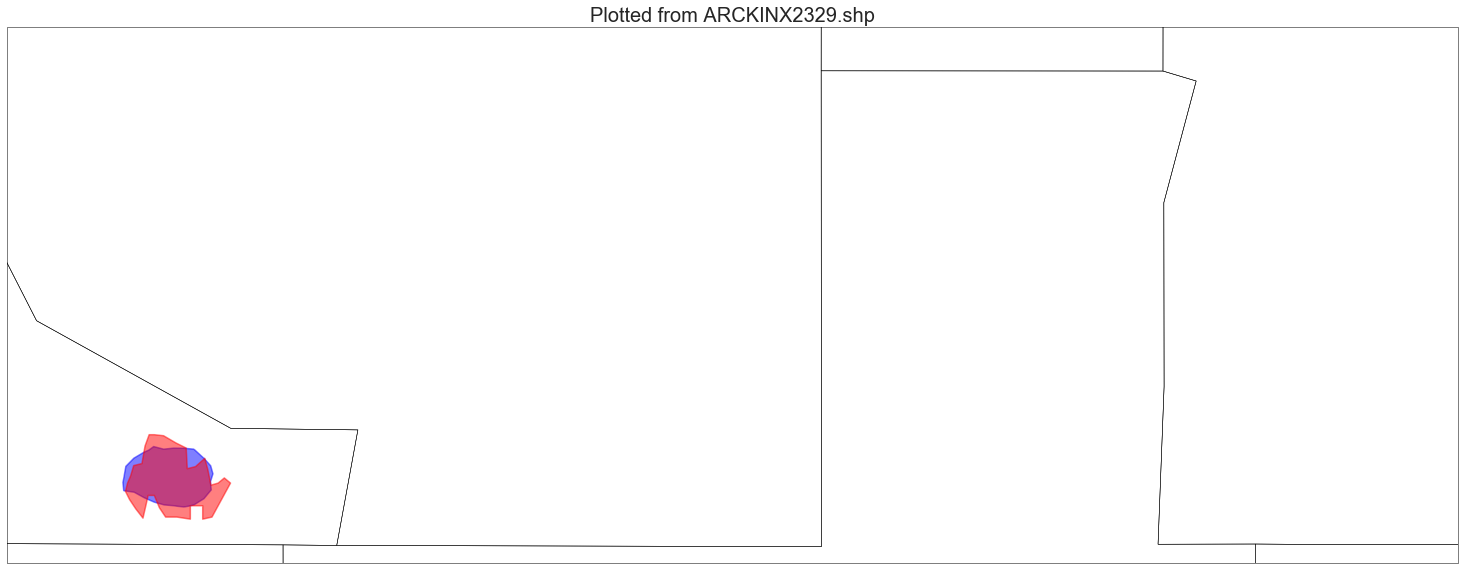

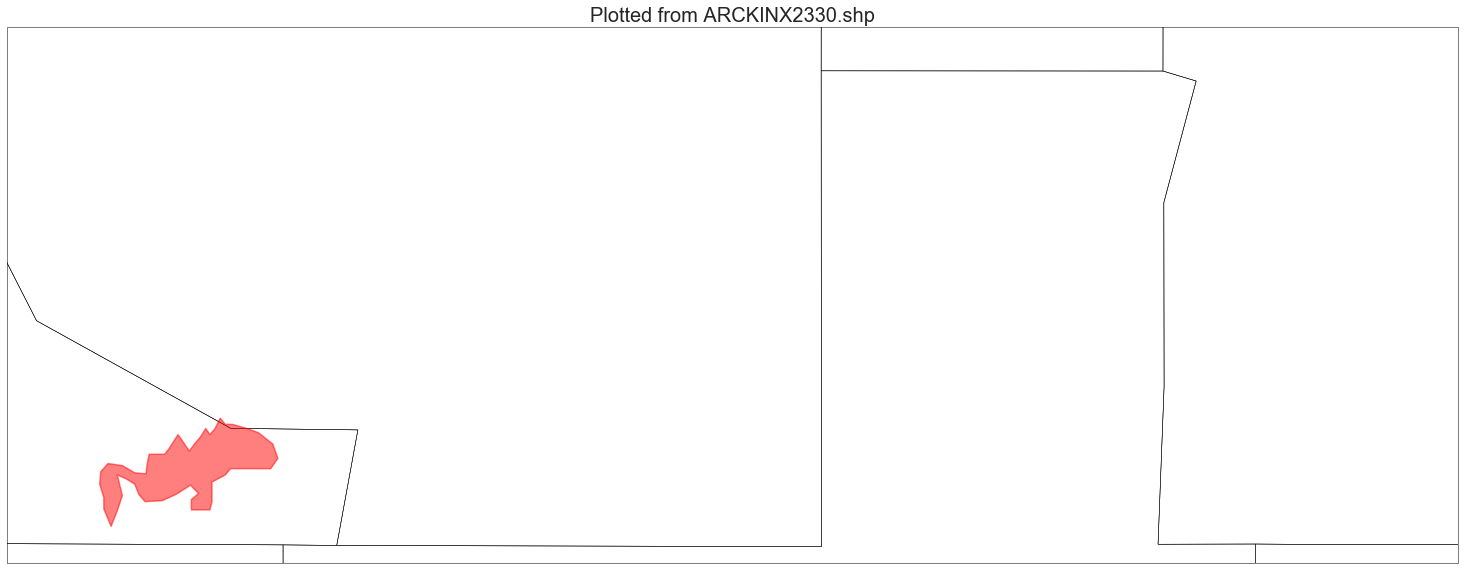

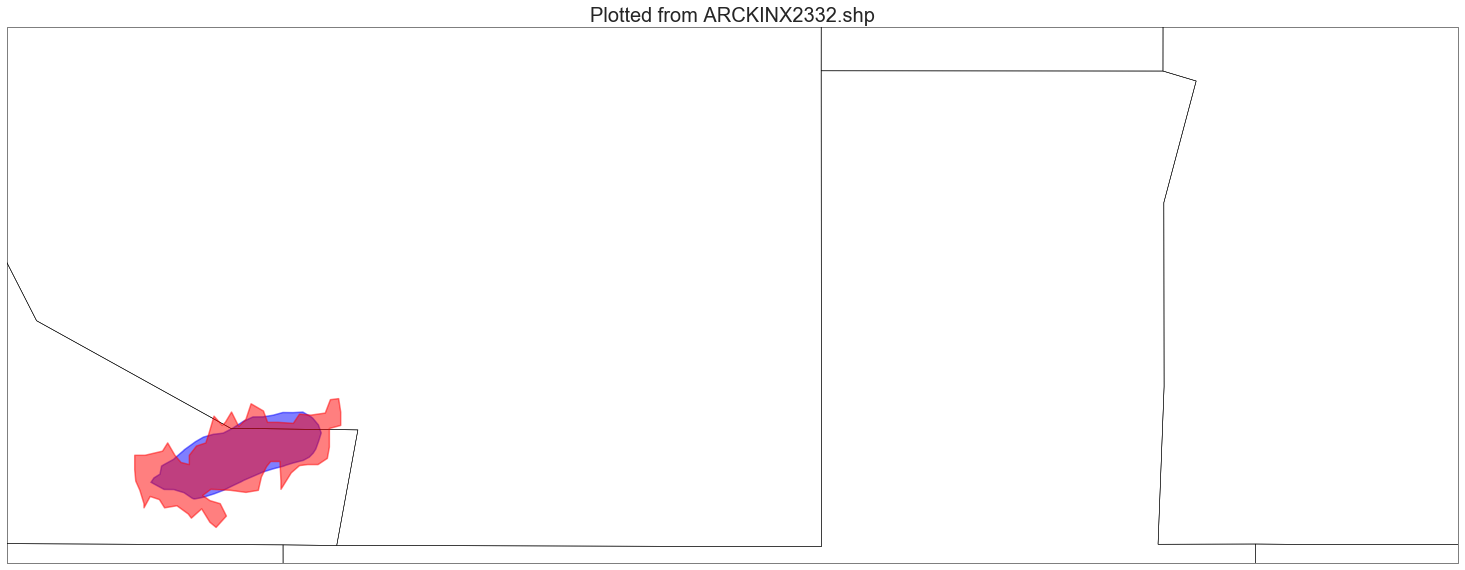

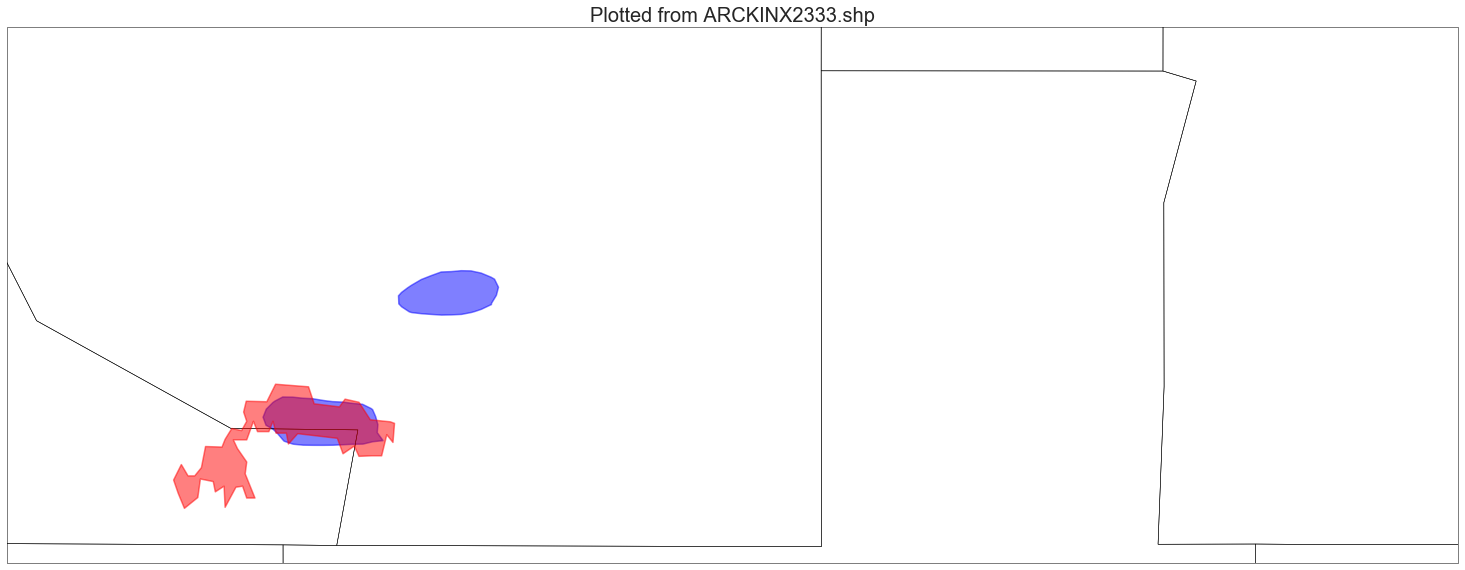

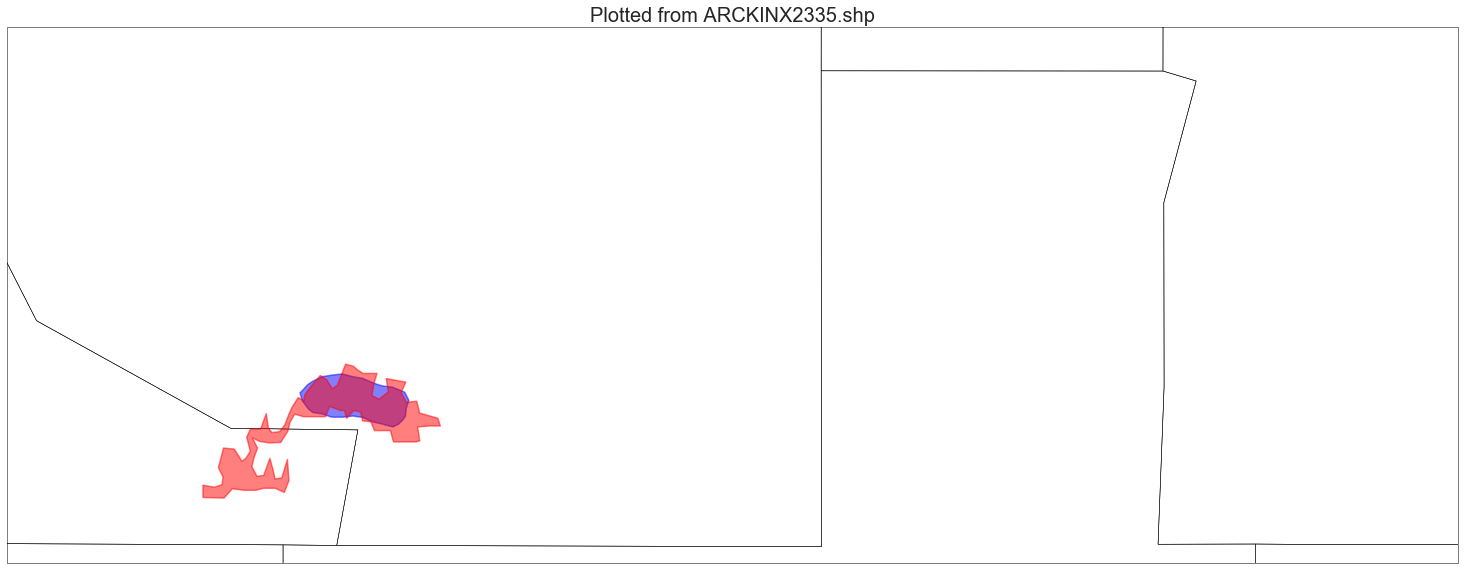

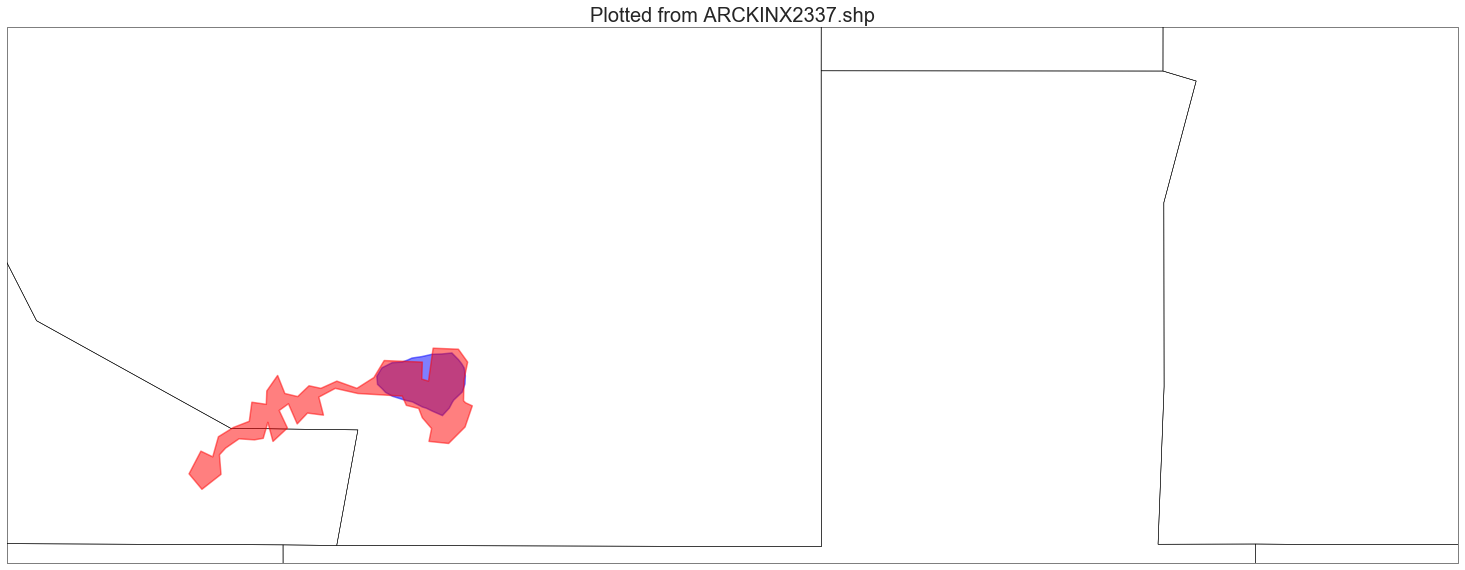

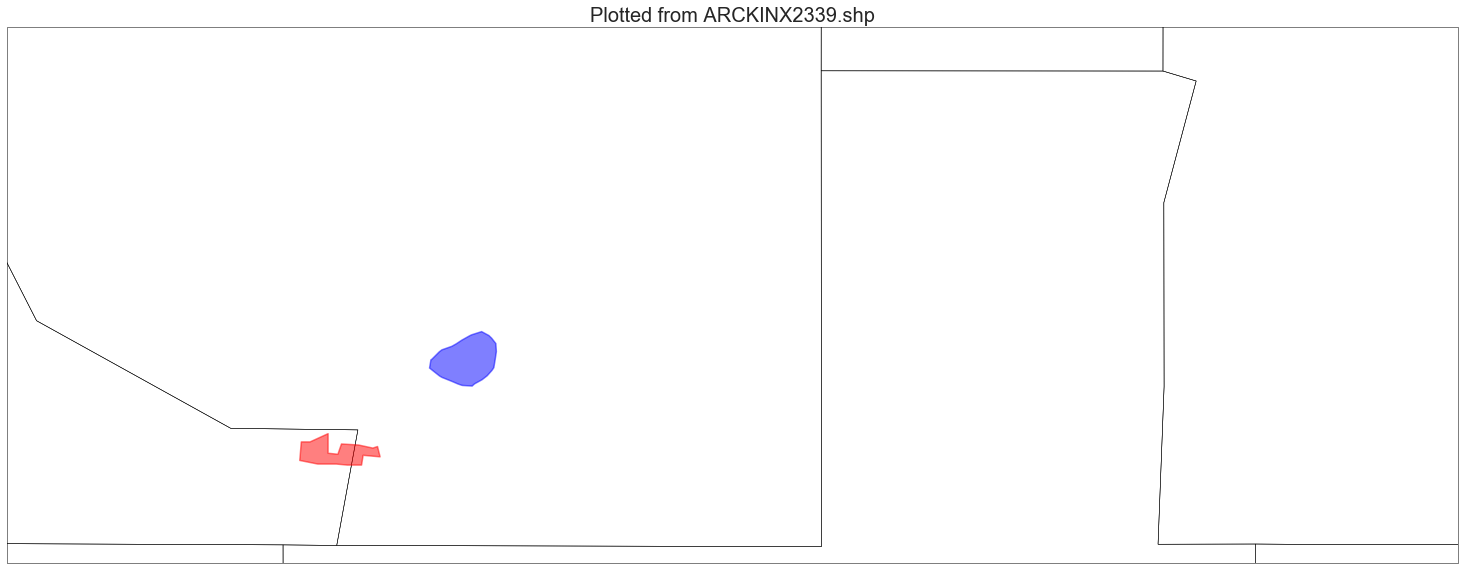

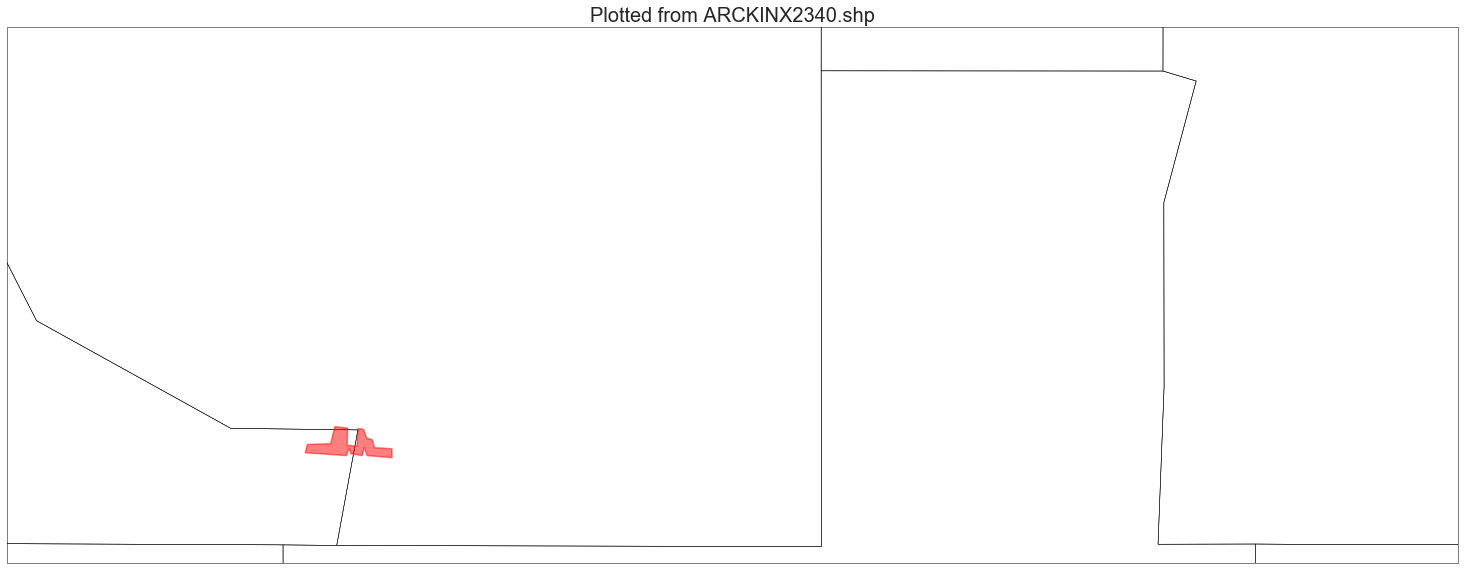

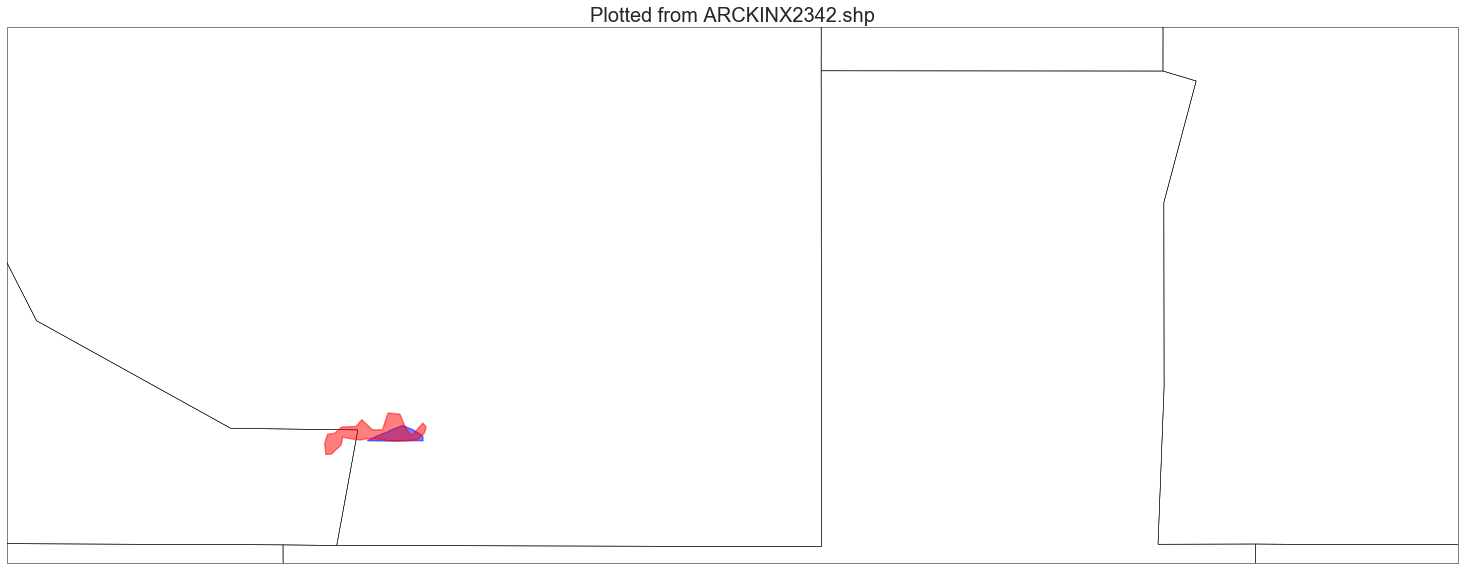

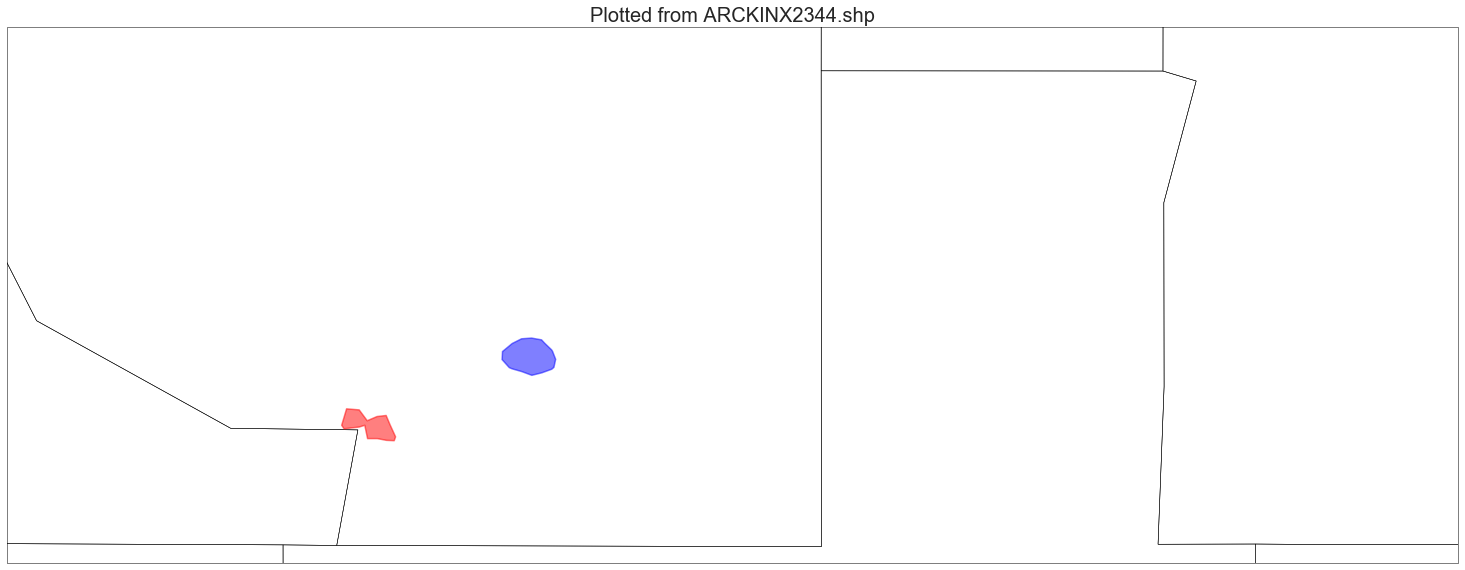

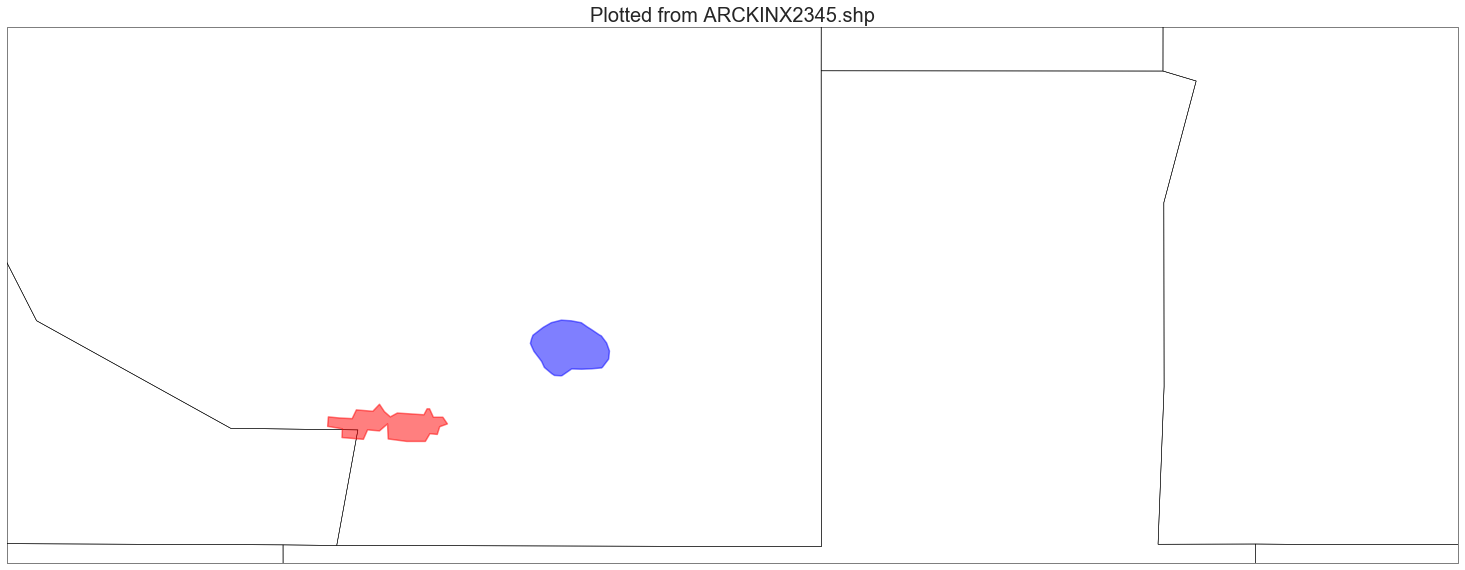

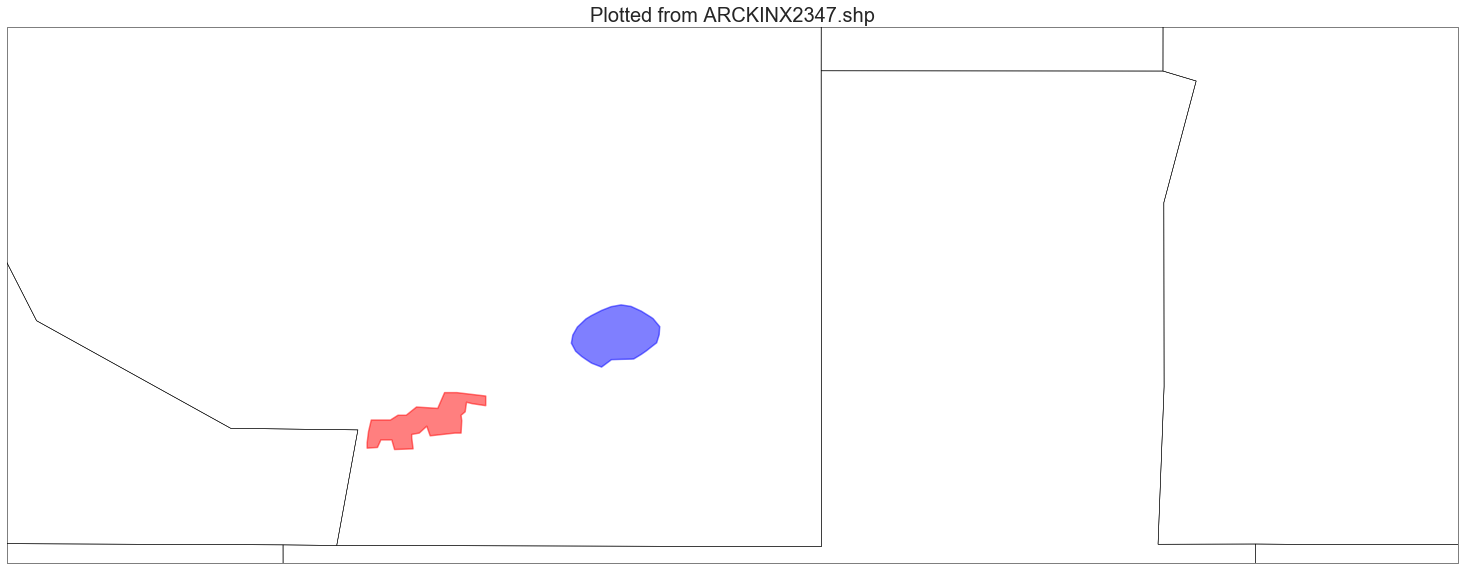

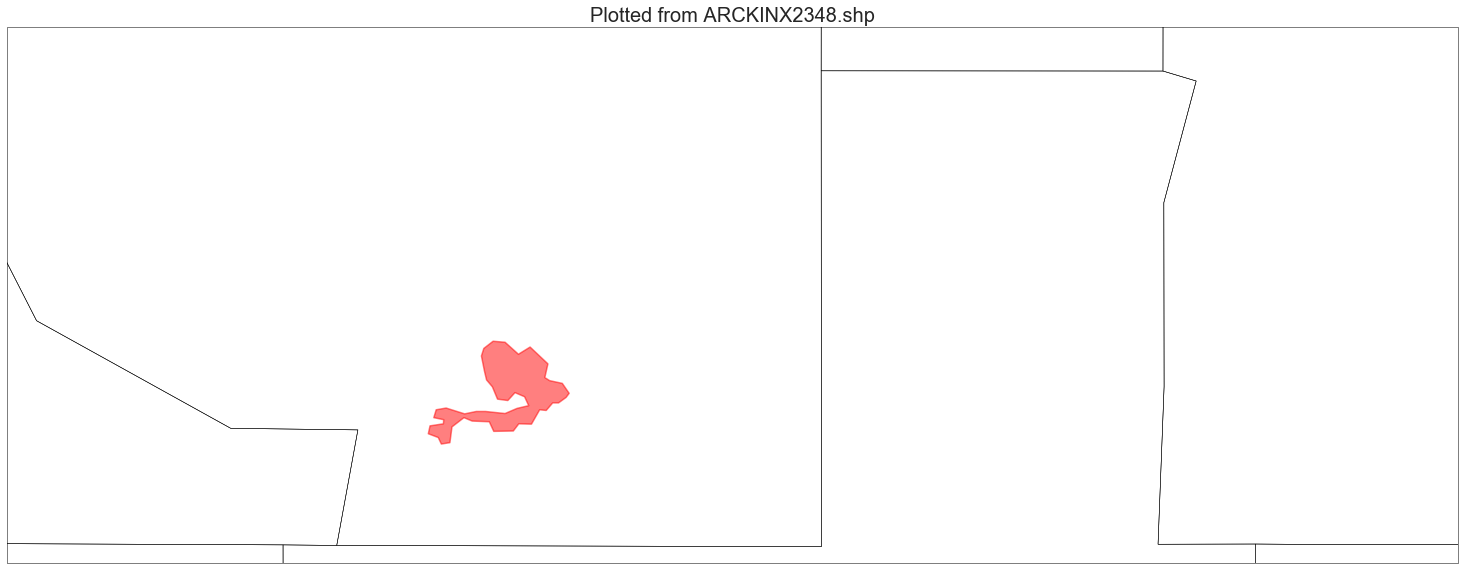

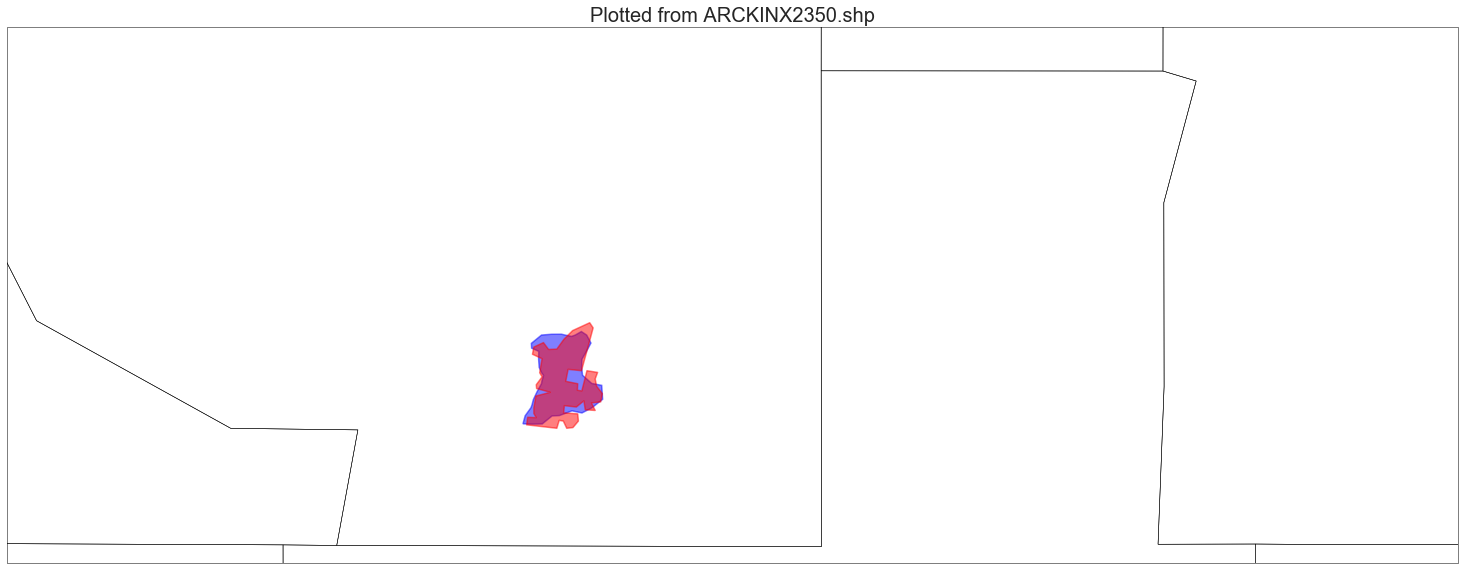

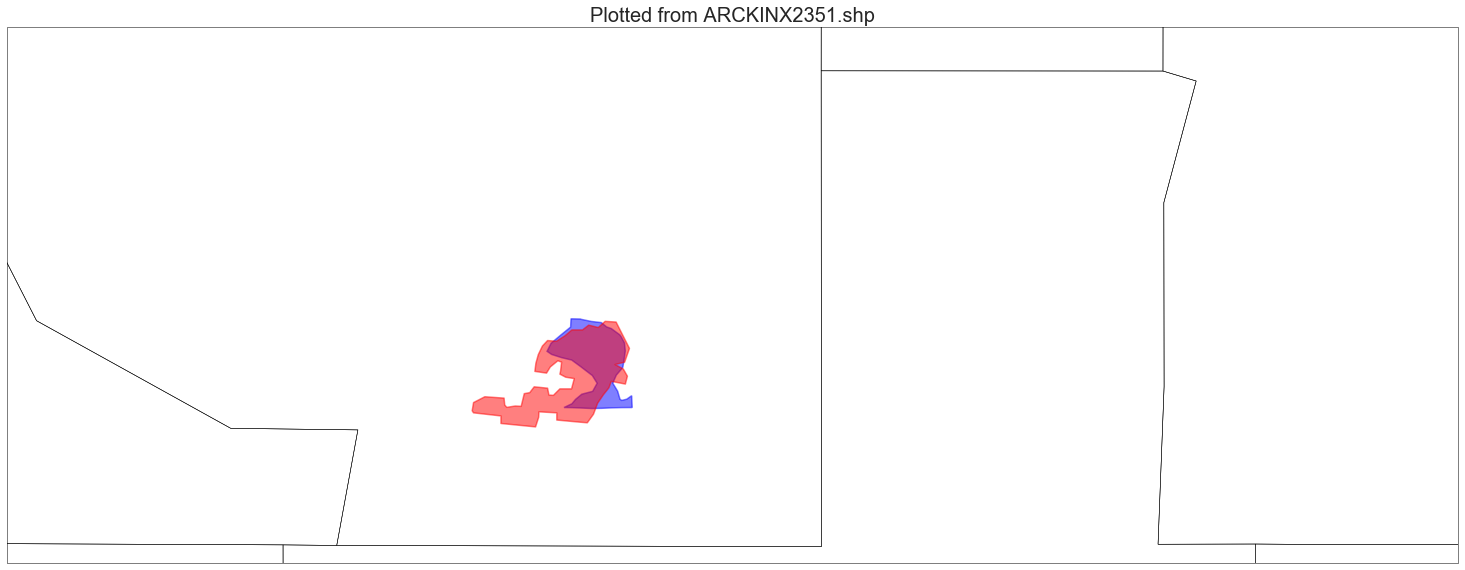

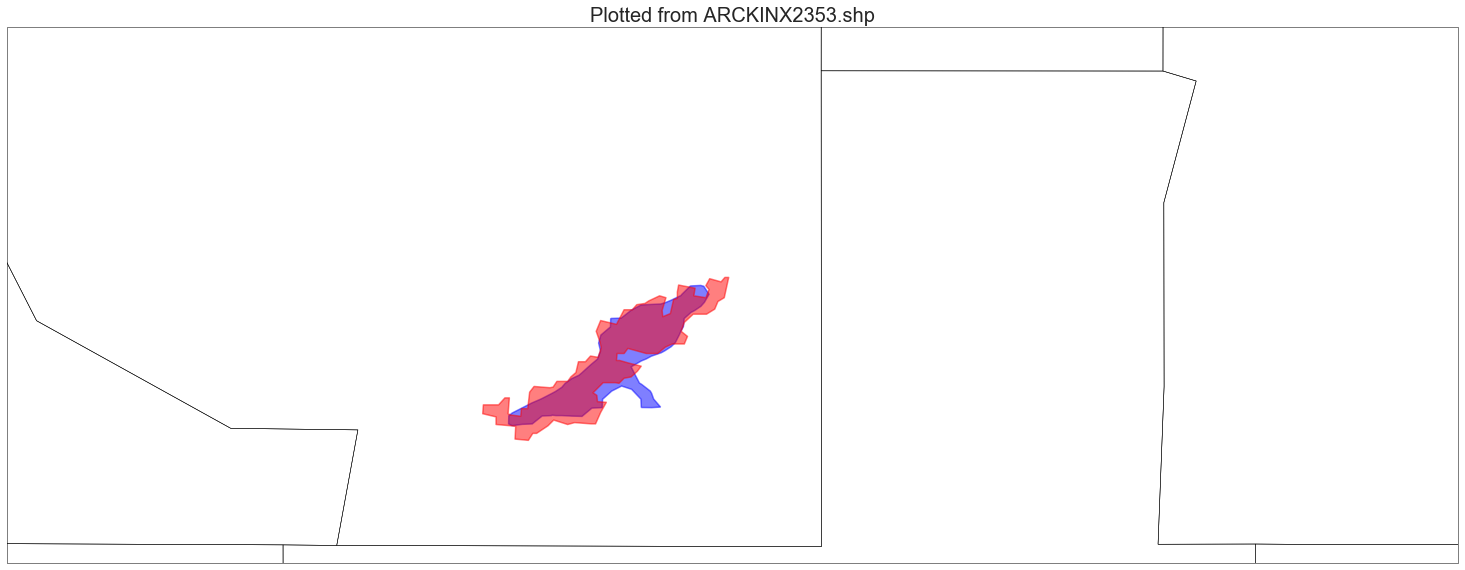

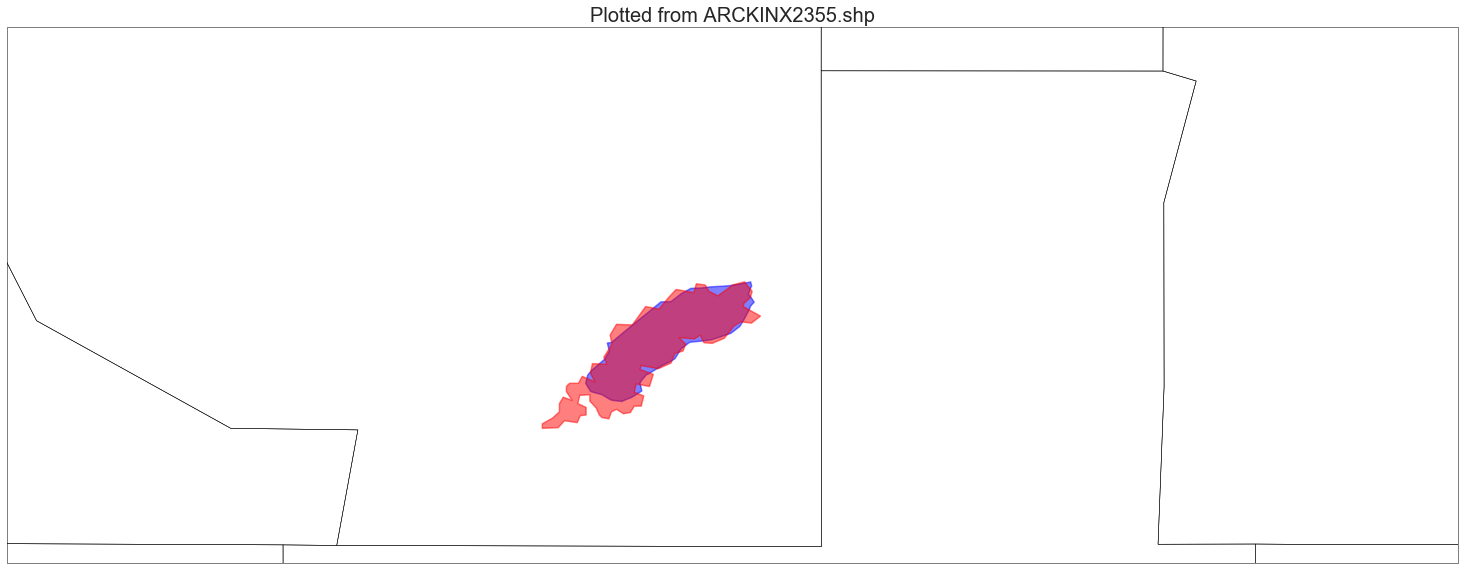

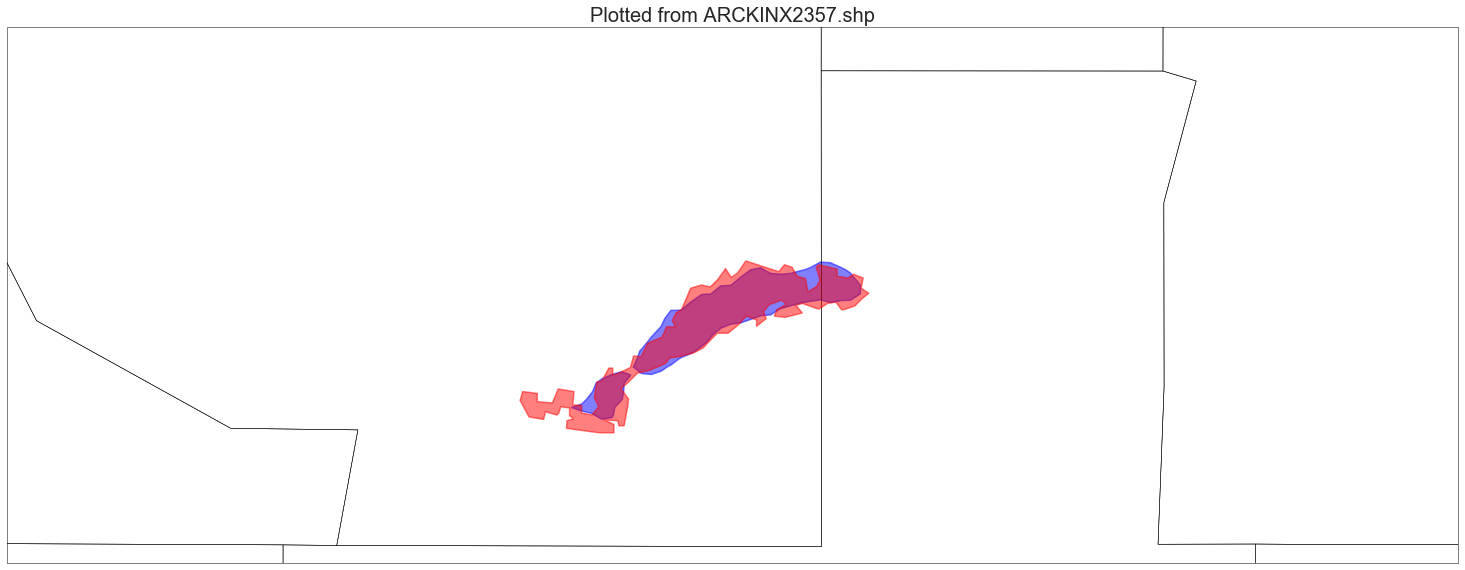

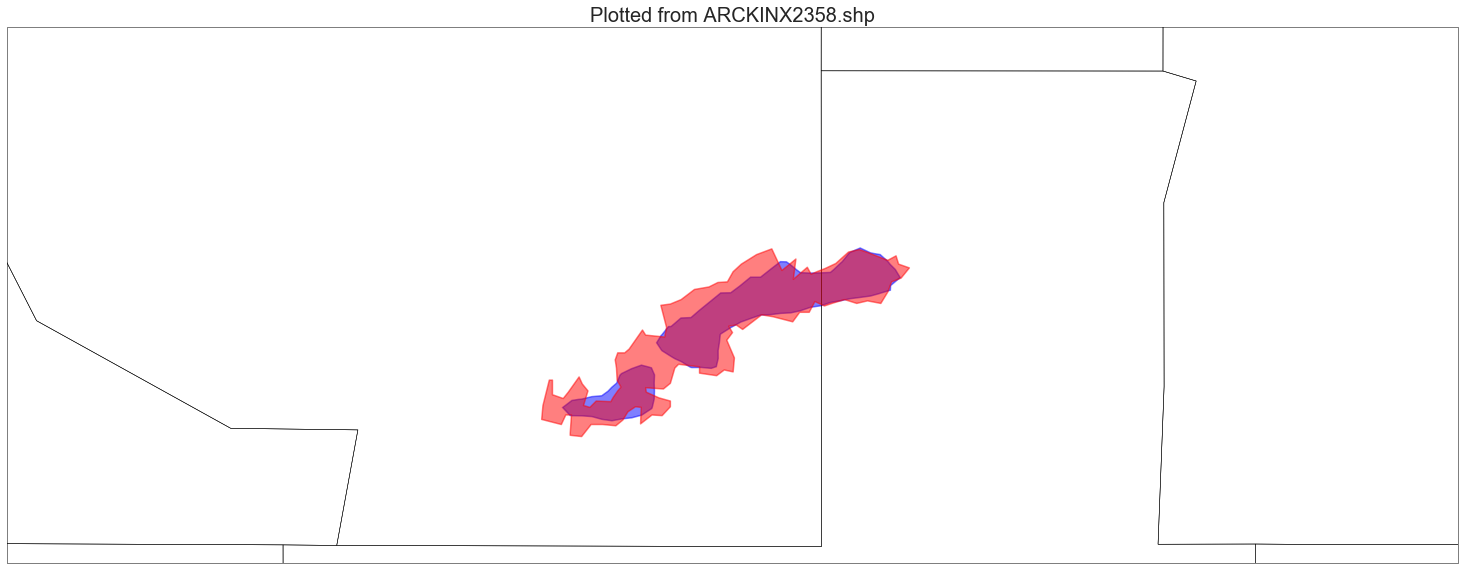

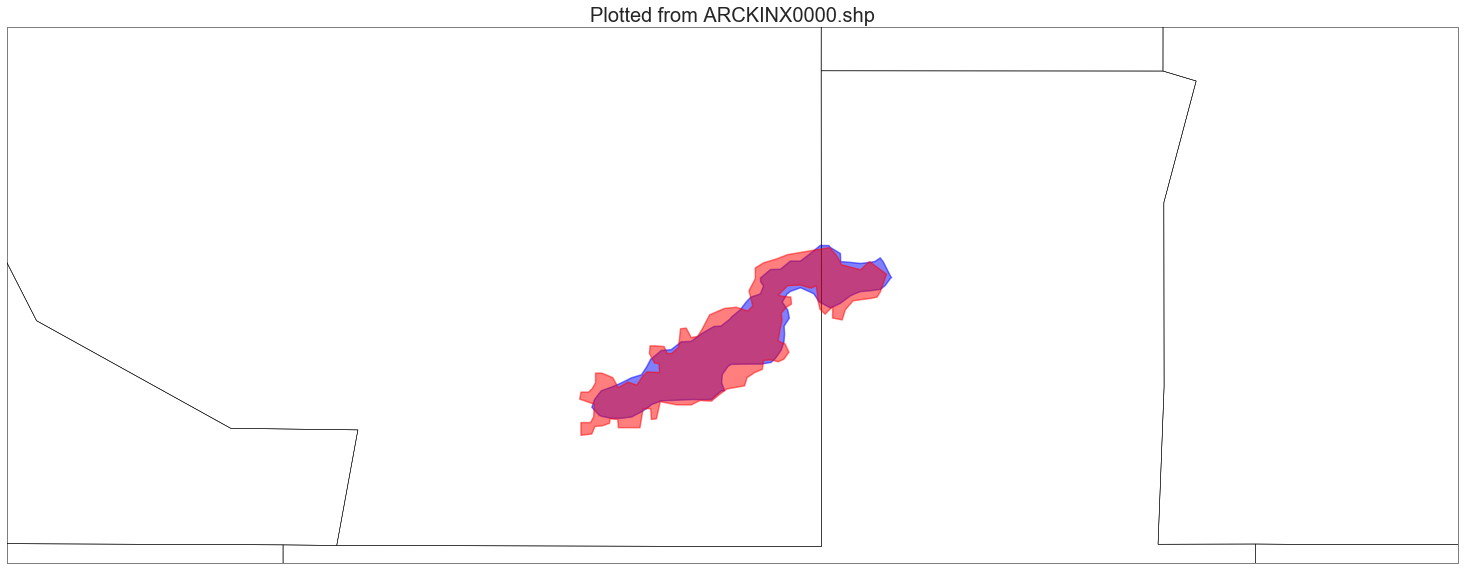

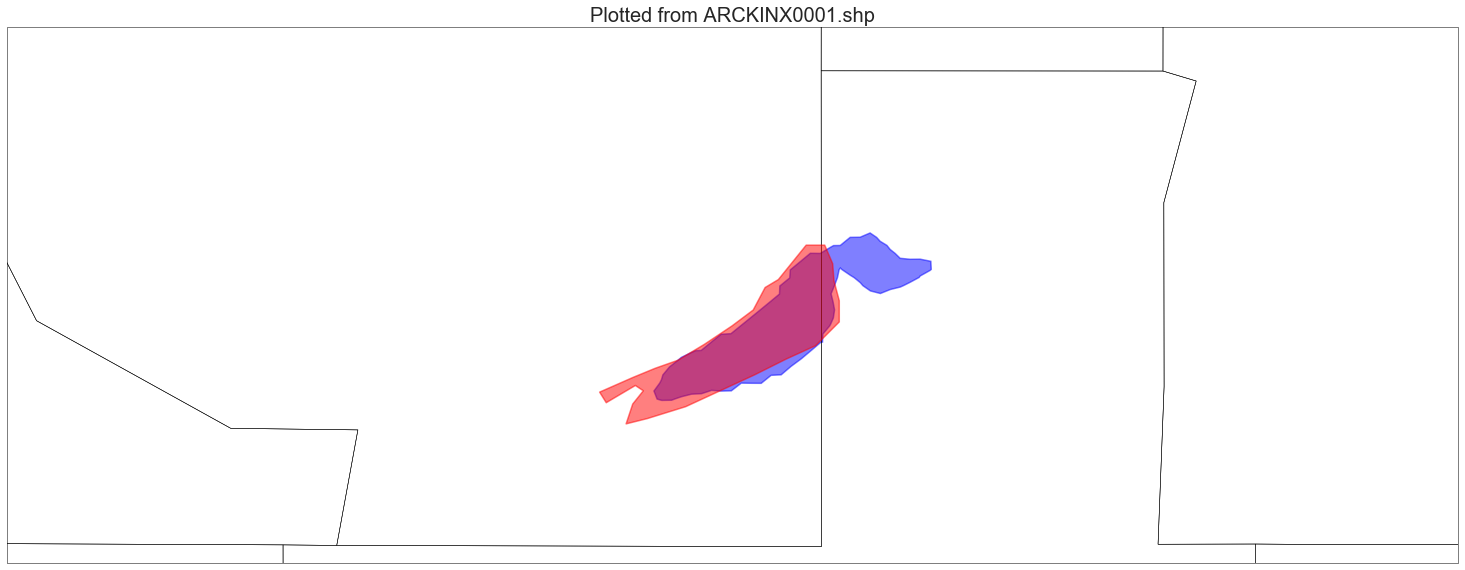

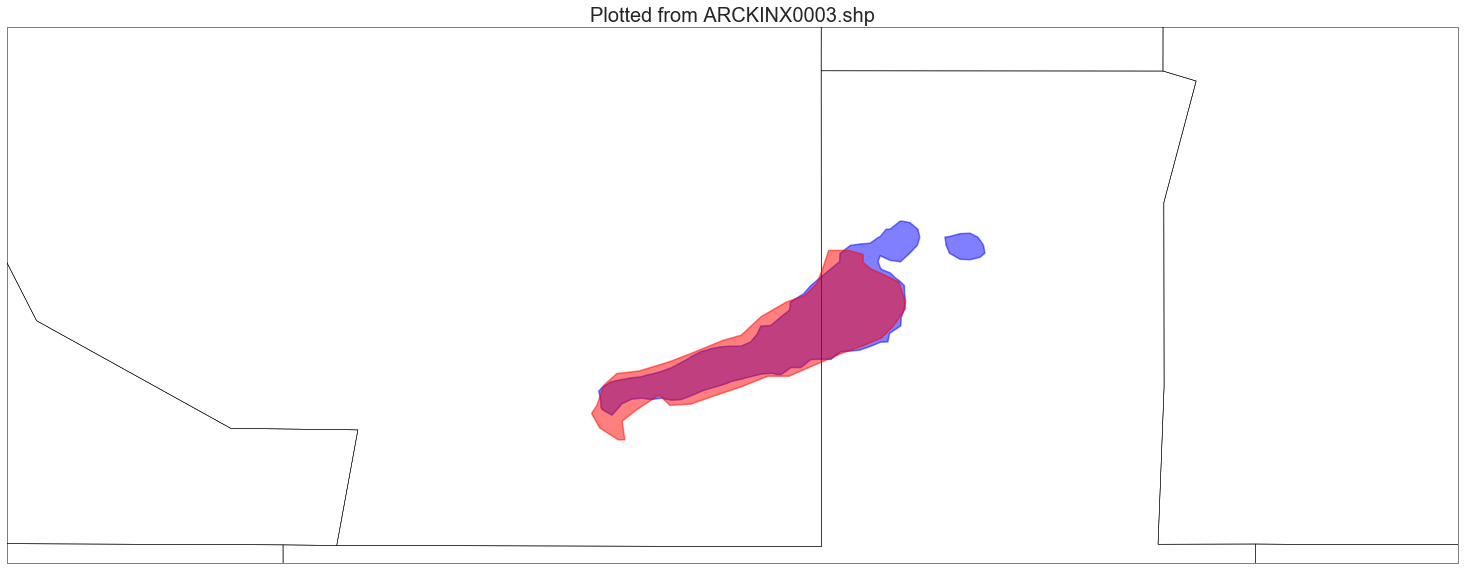

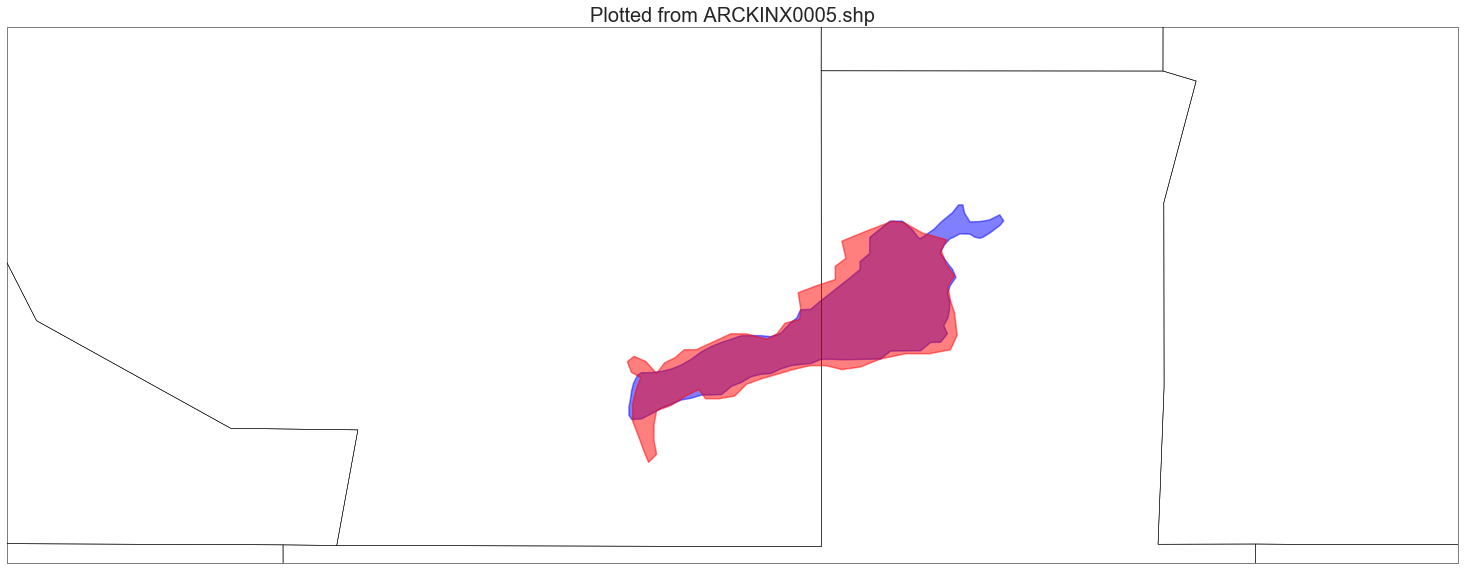

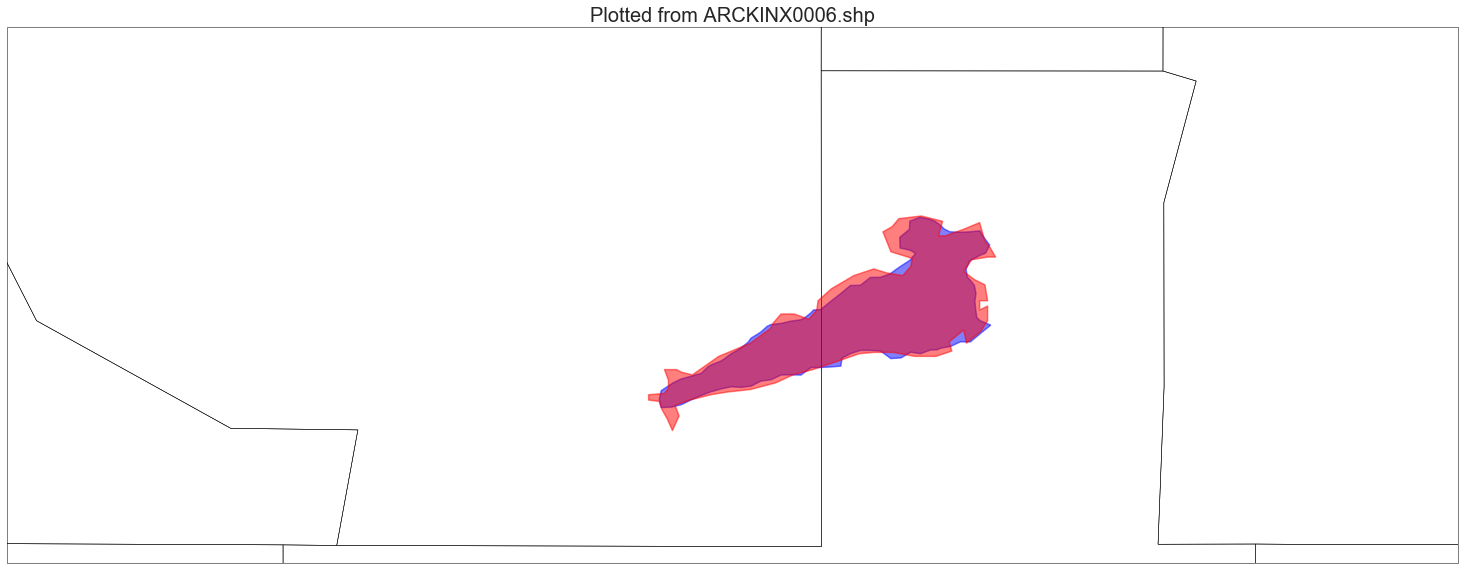

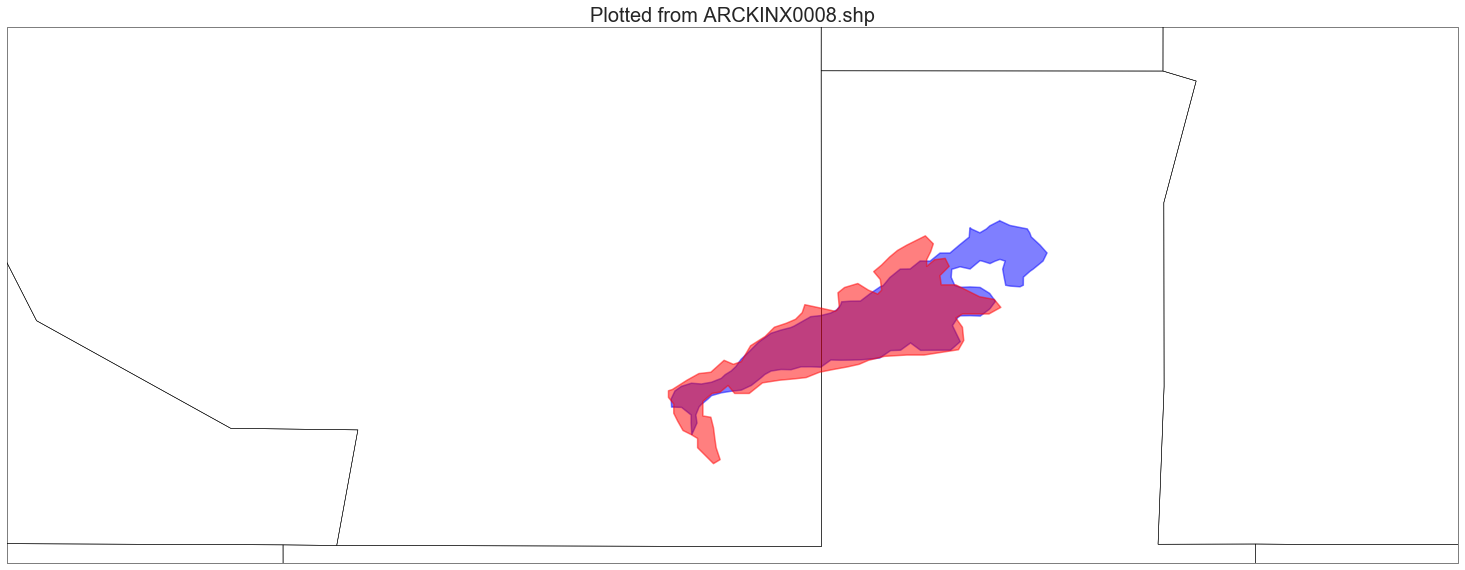

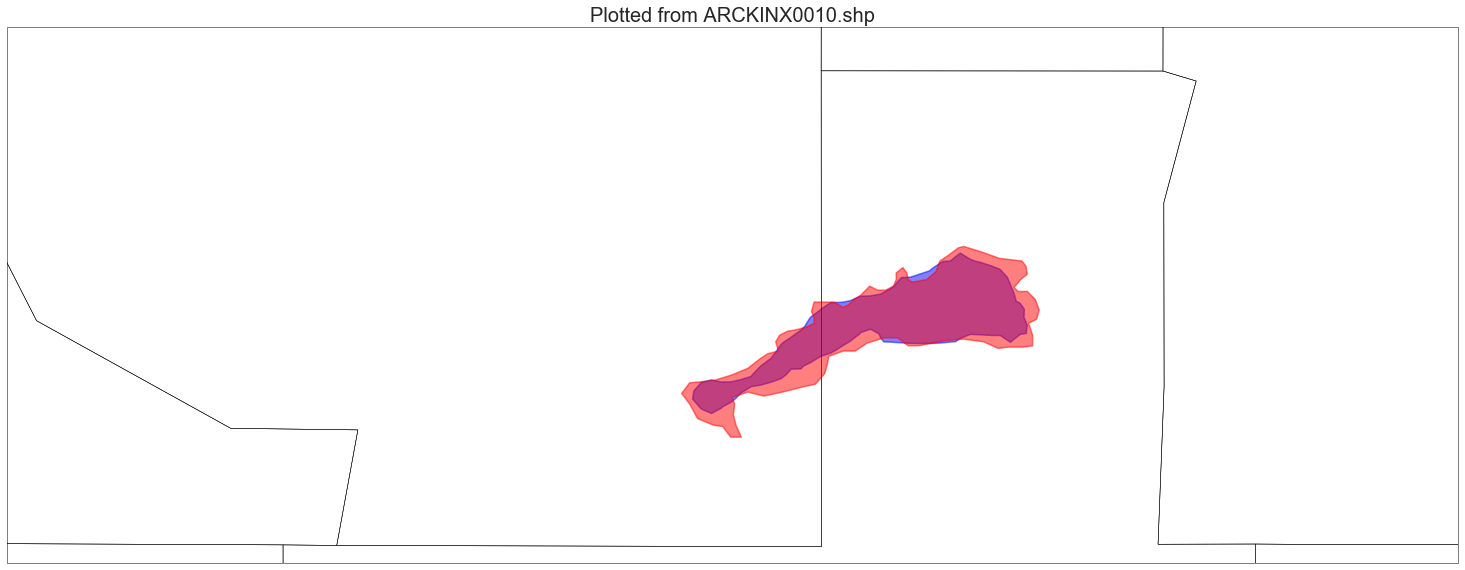

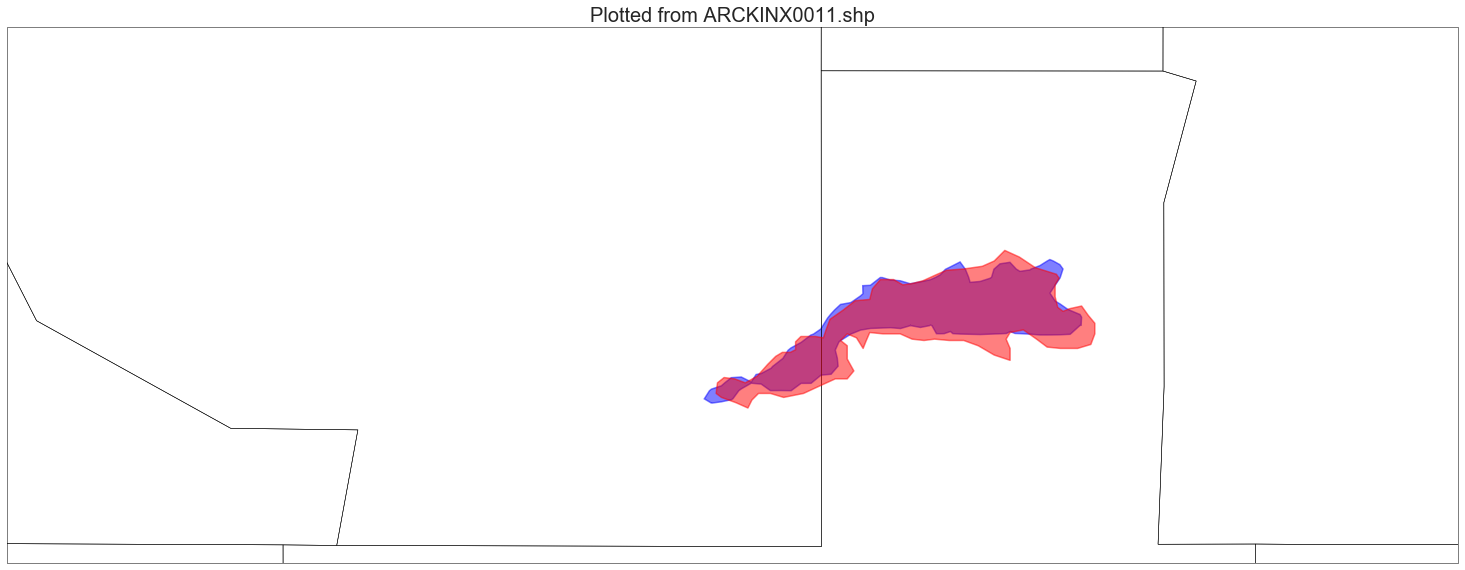

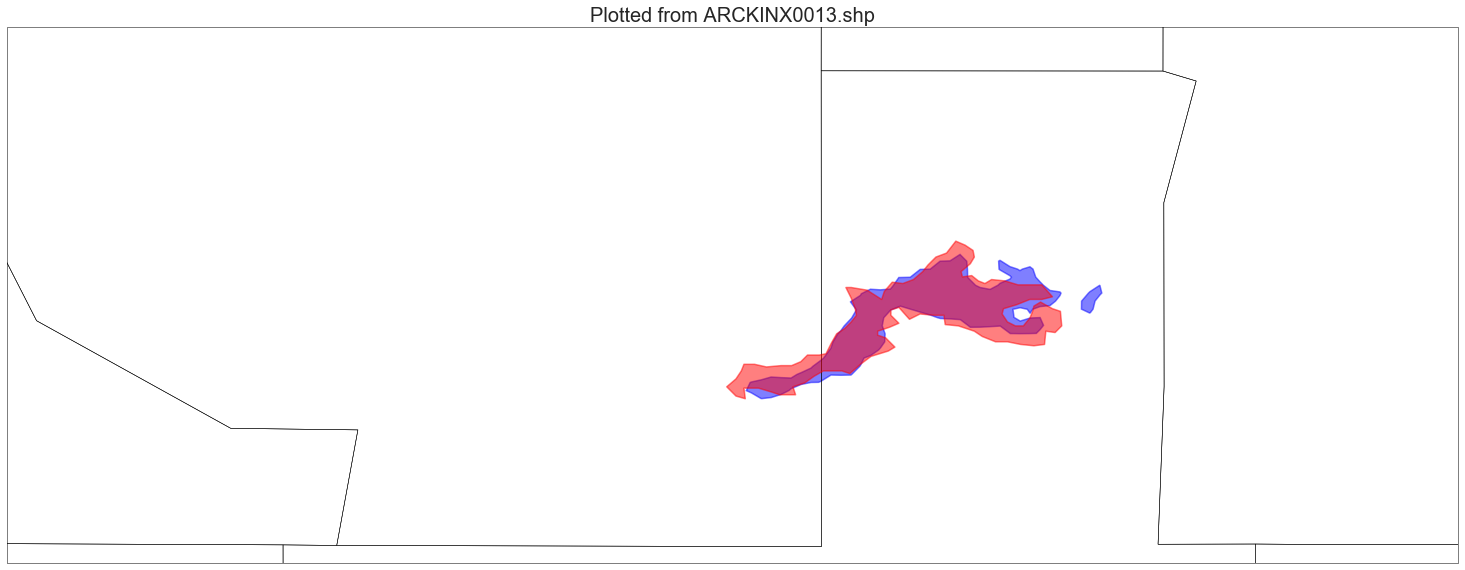

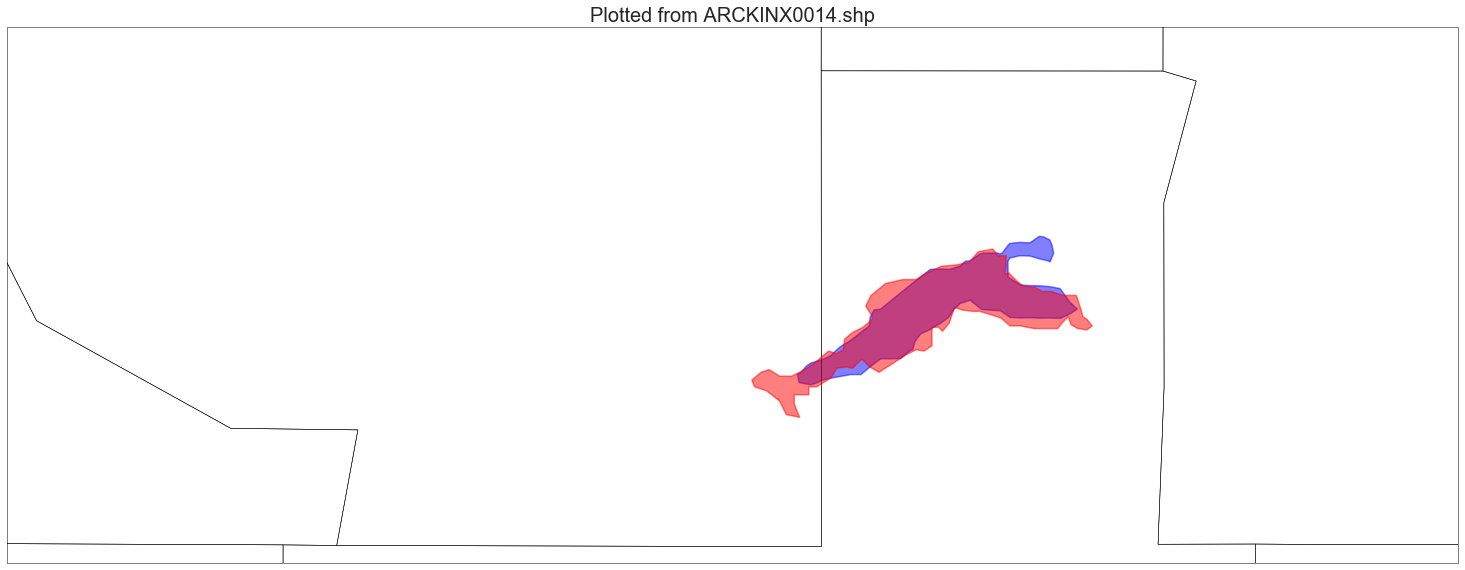

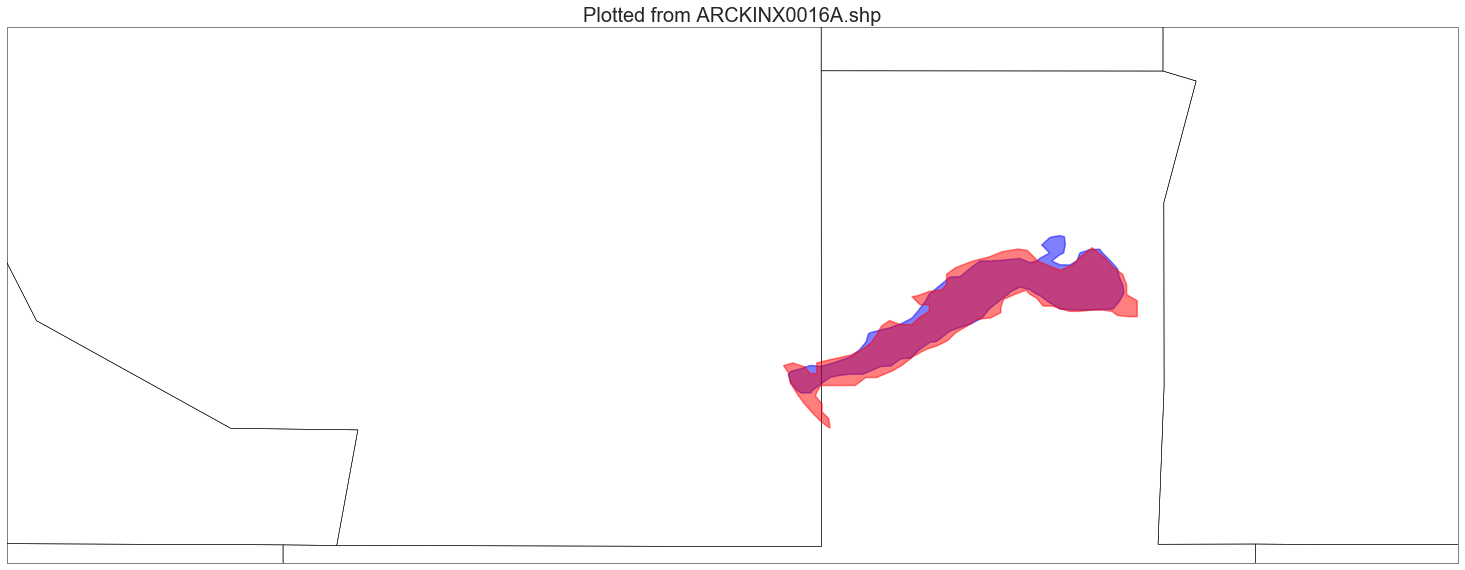

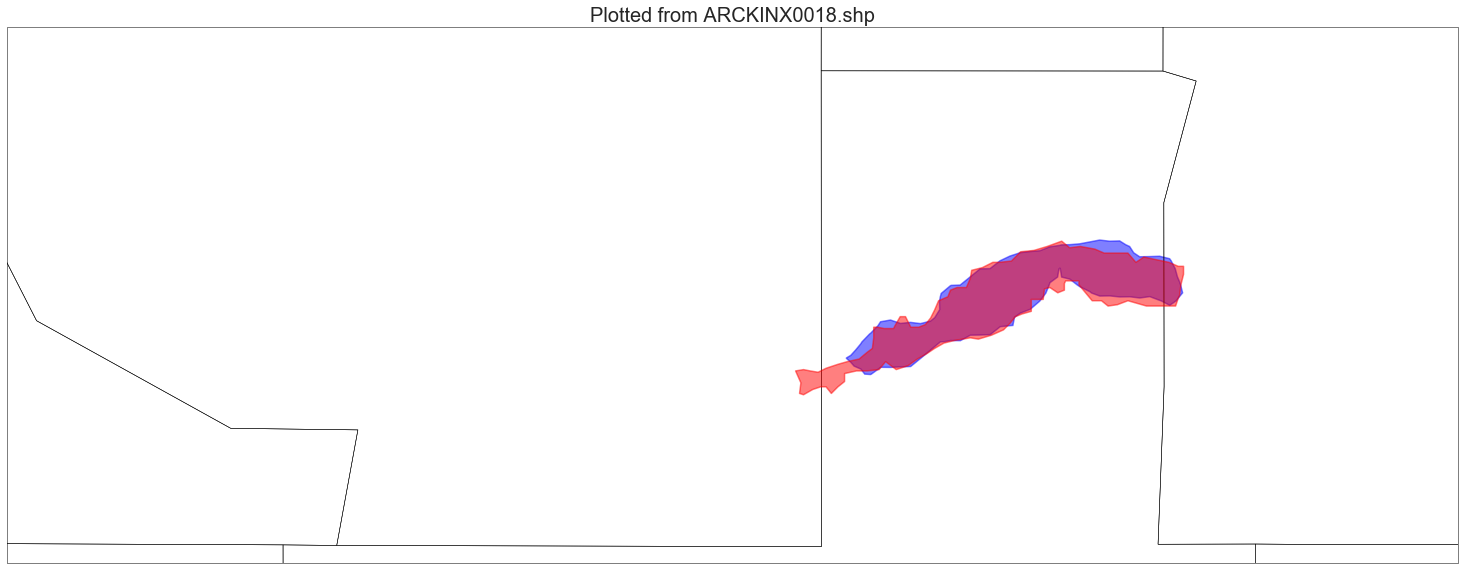

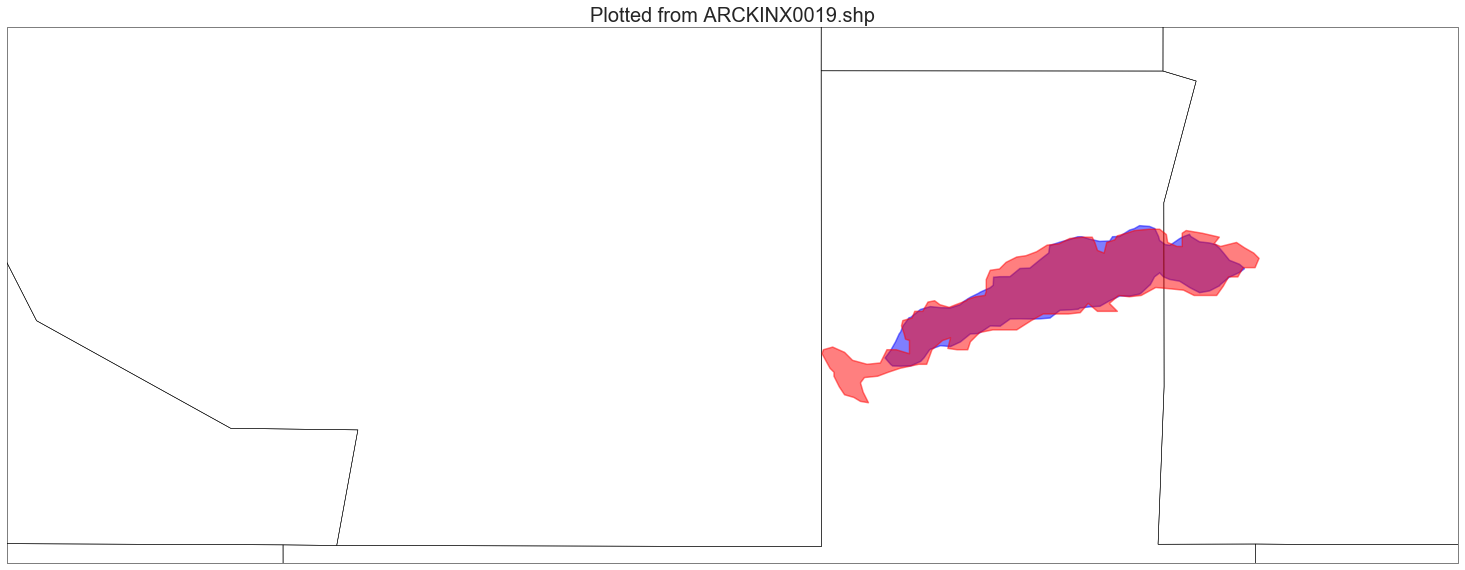

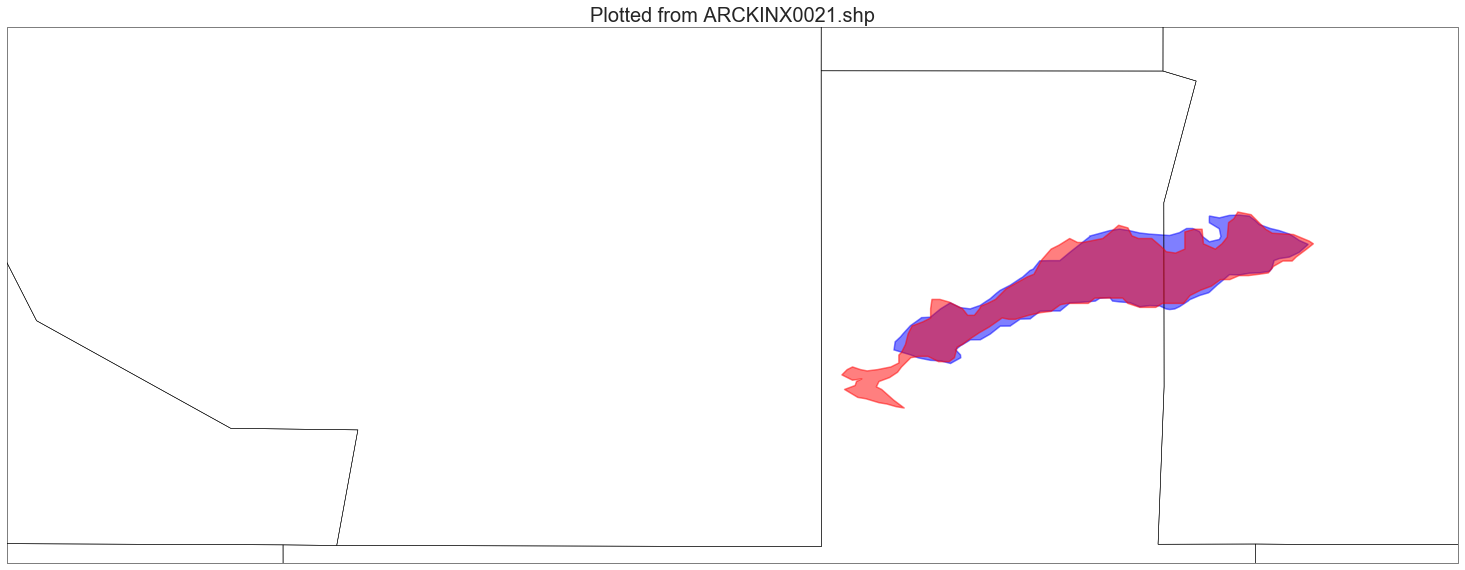

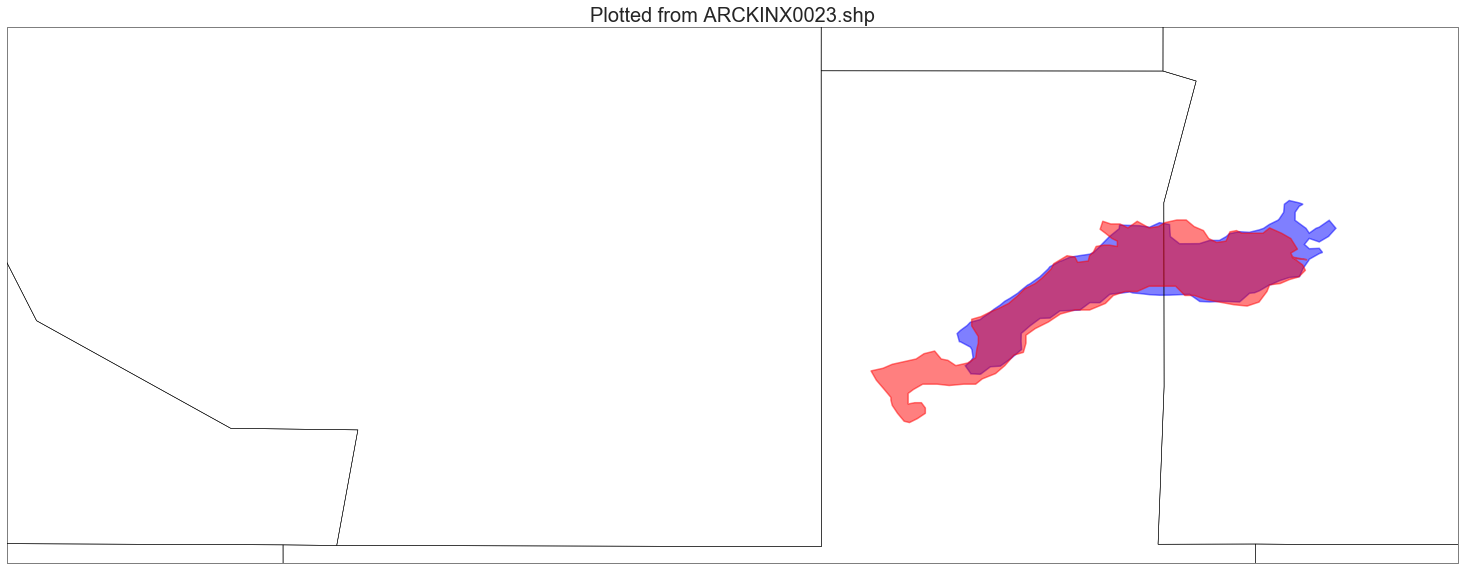

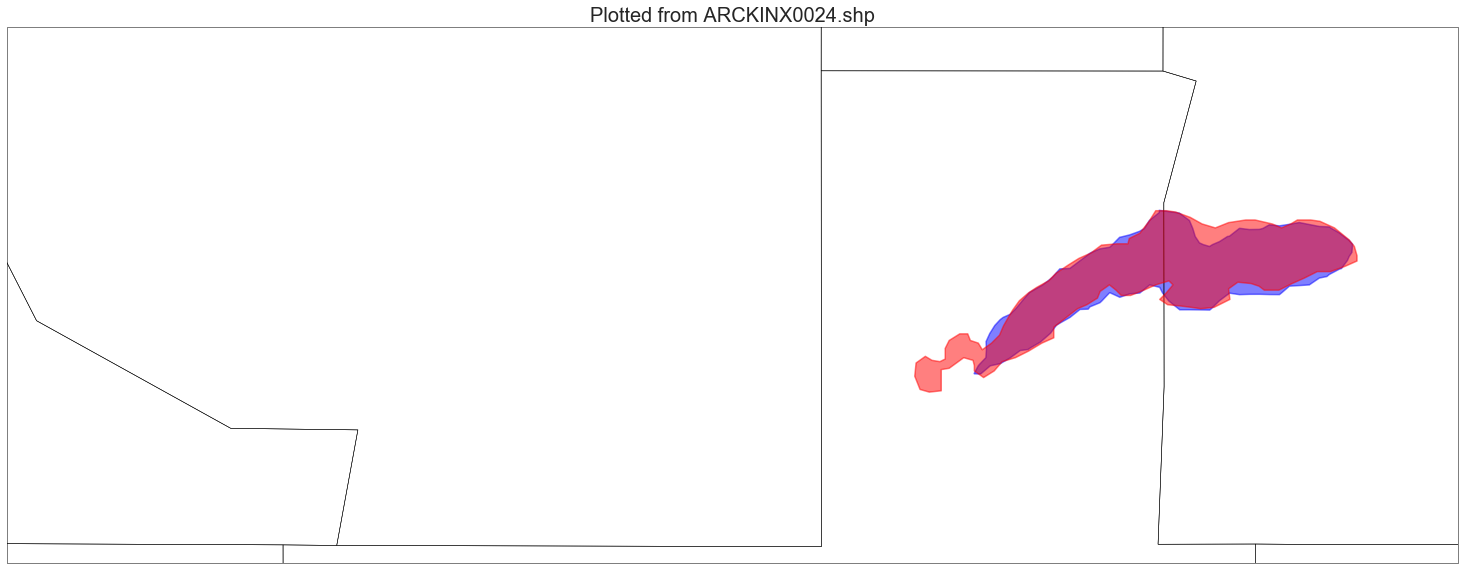

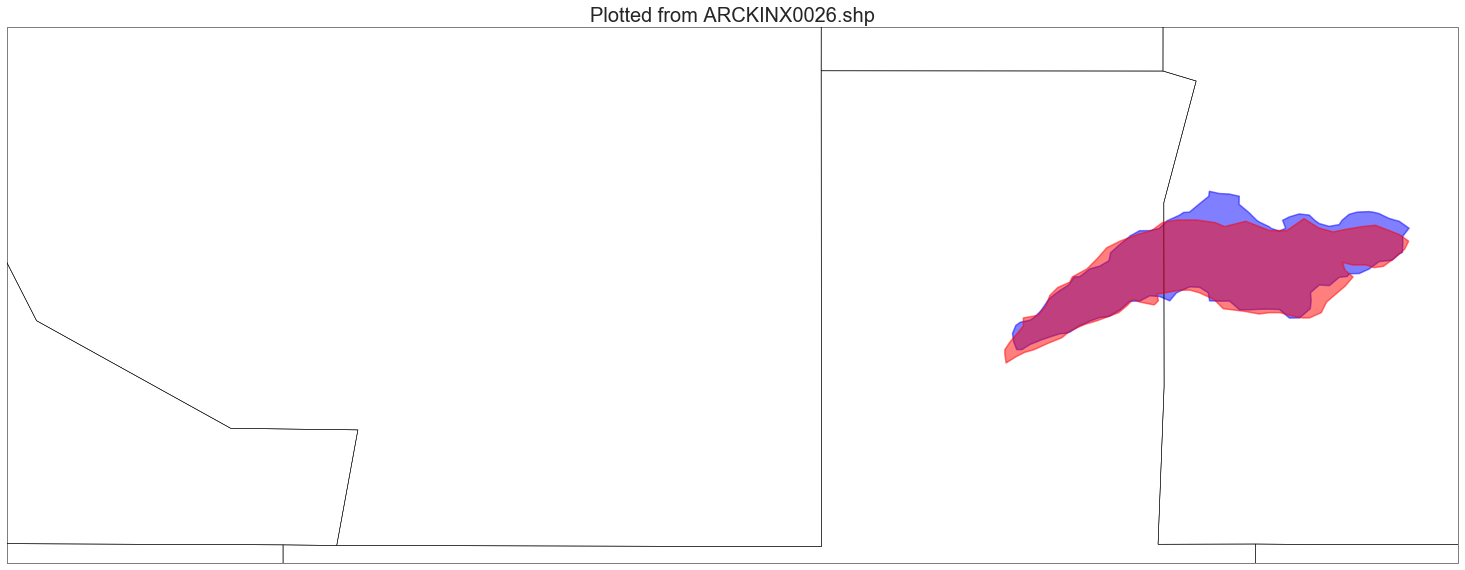

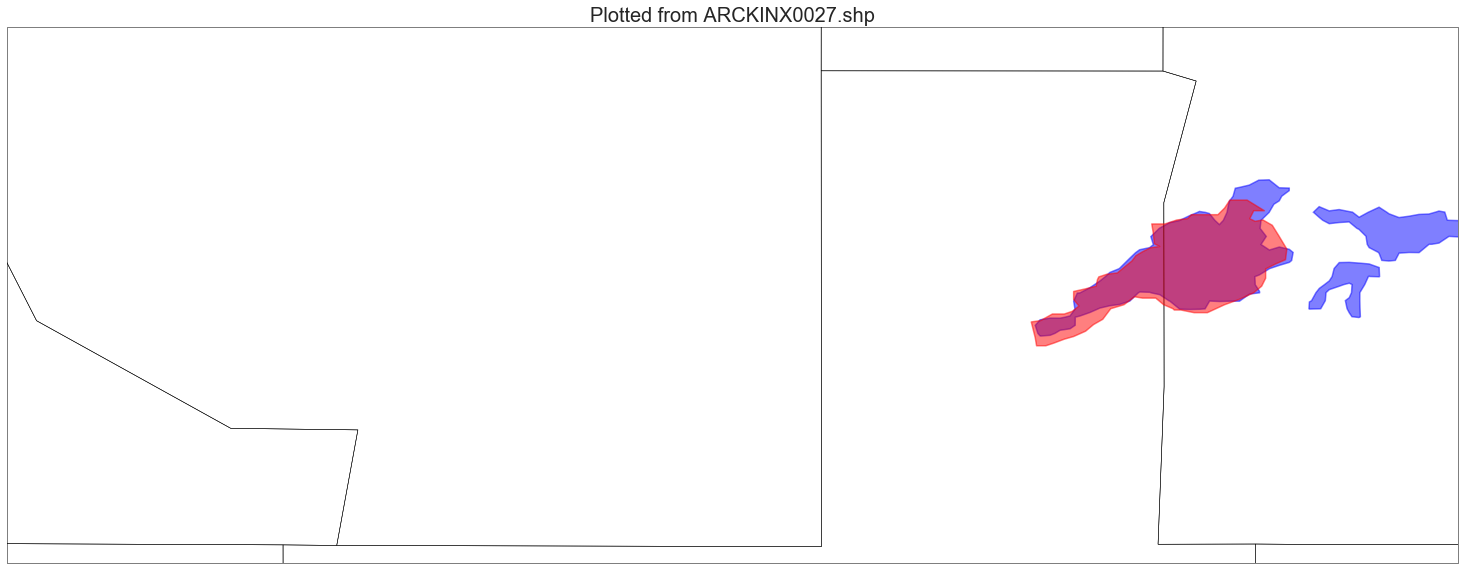

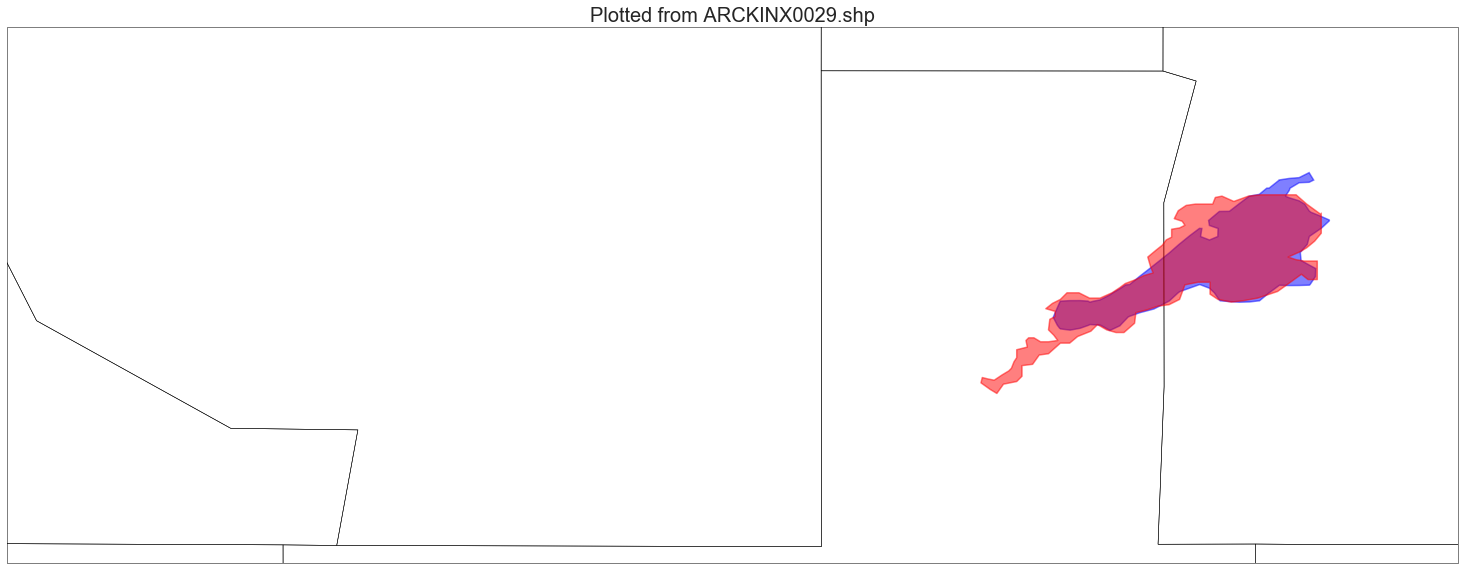

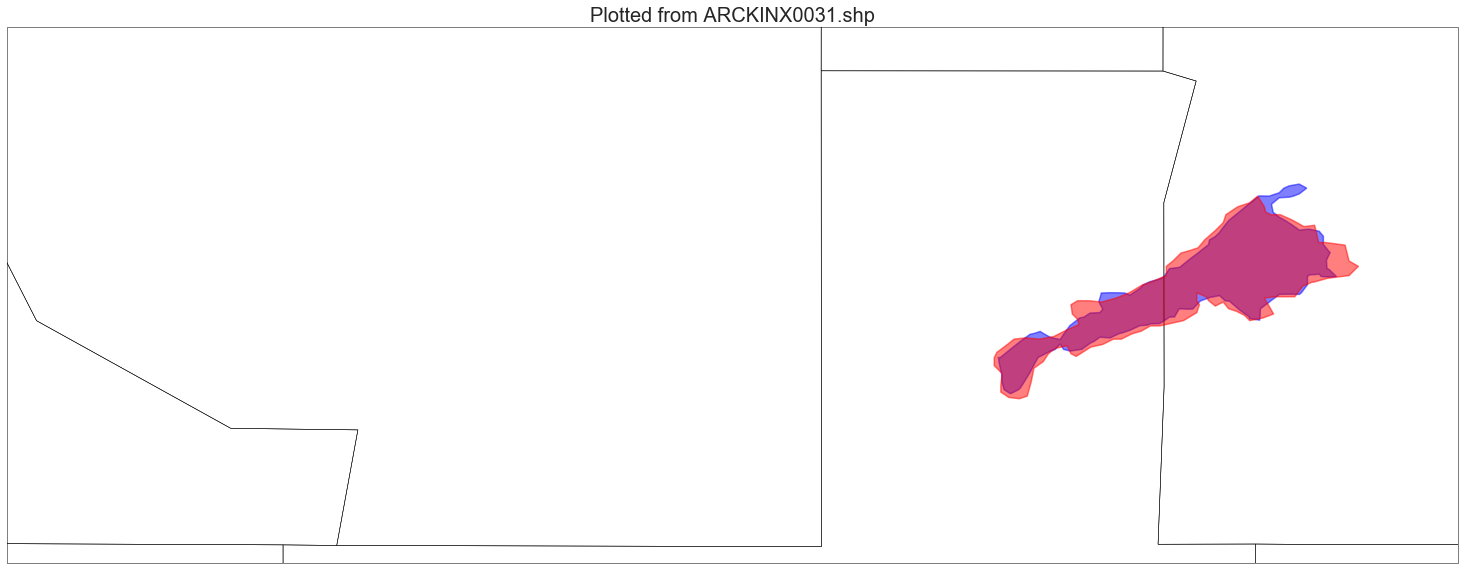

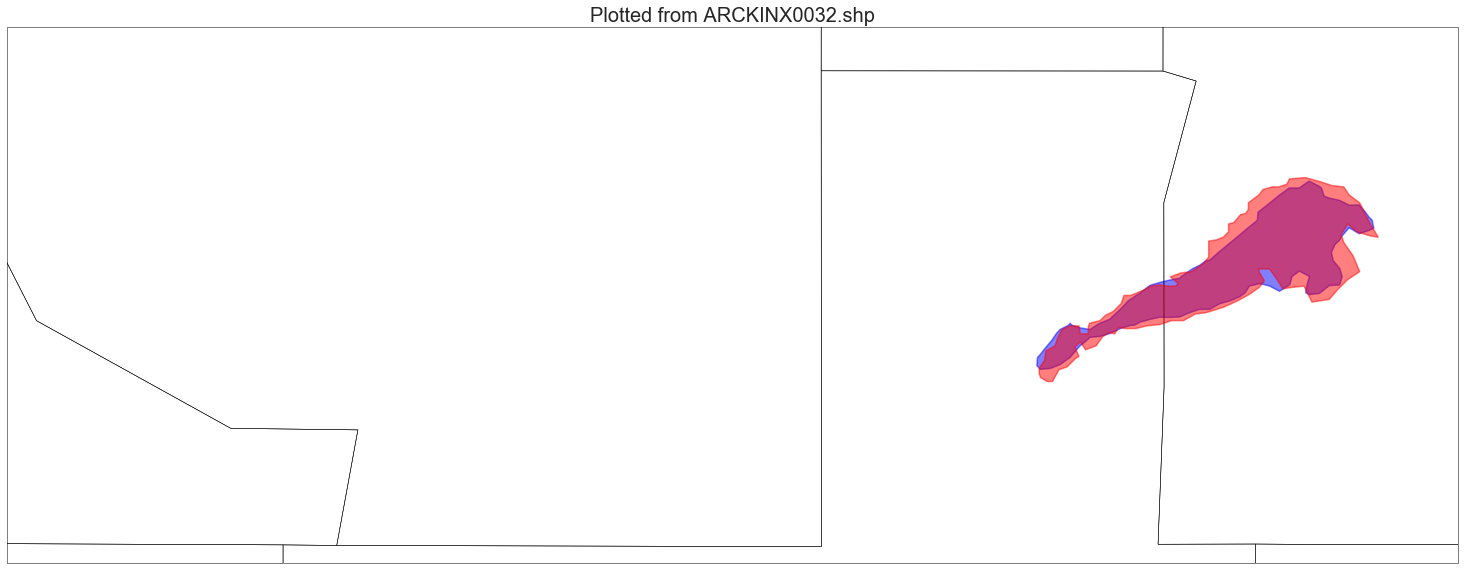

In [78]:
%matplotlib inline
#plt.style.use('bmh')
for l in range(len(arcshapefilesc)):

    fig=plt.figure(l+1,figsize=(26.,17.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
    #polygons = []
    #for i in range(len(arcshapefiles)):
    for i in [l]:
        arc = ax.add_feature(arcshapefilesc[i], edgecolor = 'red', facecolor = 'red', linewidth=1.5, alpha=0.5)
        polygons.append(arc)
    #refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
    #refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

    #ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
    k = 0
    #for i in range(len(arc_outlines)):
    try:
        for i in [l]:
            for j in range(len(arc_outlines4[i])):
                patch = PathPatch(arc_outlines4[i][j], facecolor = 'blue', alpha=0.5, edgecolor='blue', linewidth=1.5)
                ax.add_patch(patch)
                k = k + 1
    except:
        print('oops')
    plt.title('Plotted from '+str(arctextc[l]), size=20)
    plt.tight_layout()
    plt.savefig('AlgObsCompF'+str(l)+'.png')
plt.show()

In [79]:
print(len(arc_outlines4[3]))

2


In [80]:
# %matplotlib inline
# #plt.style.use('bmh')
# for l in range(len(arcshapefiles)):

#     fig=plt.figure(l+1,figsize=(26.,17.))
#     ax = plt.subplot(111,projection=ccrs.PlateCarree())
#     #   ax.set_extent([west long, east long, south lat, north lat])
#     ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
#     ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#     ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
#     ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#     #ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#     #polygons = []
#     #for i in range(len(arcshapefiles)):
#     for i in [l]:
#         arc = ax.add_feature(arcshapefiles[i], edgecolor = 'red', facecolor = 'red', linewidth=1.5, alpha=0.5)
#         polygons.append(arc)
#     #refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#     #refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

#     #ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#     #ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#     #ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#     #ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
#     k = 0
#     #for i in range(len(arc_outlines)):
#     for i in [l]:
#         for j in range(len(arc_outlines2[0])):
#             patch = PathPatch(arc_outlines2[i][j], facecolor = 'green', alpha=0.5, edgecolor='green', linewidth=1.5)
#             ax.add_patch(patch)
#             k = k + 1
#     plt.tight_layout()
#     plt.savefig('AlgObsComp350'+str(l)+'.png')
# plt.show()

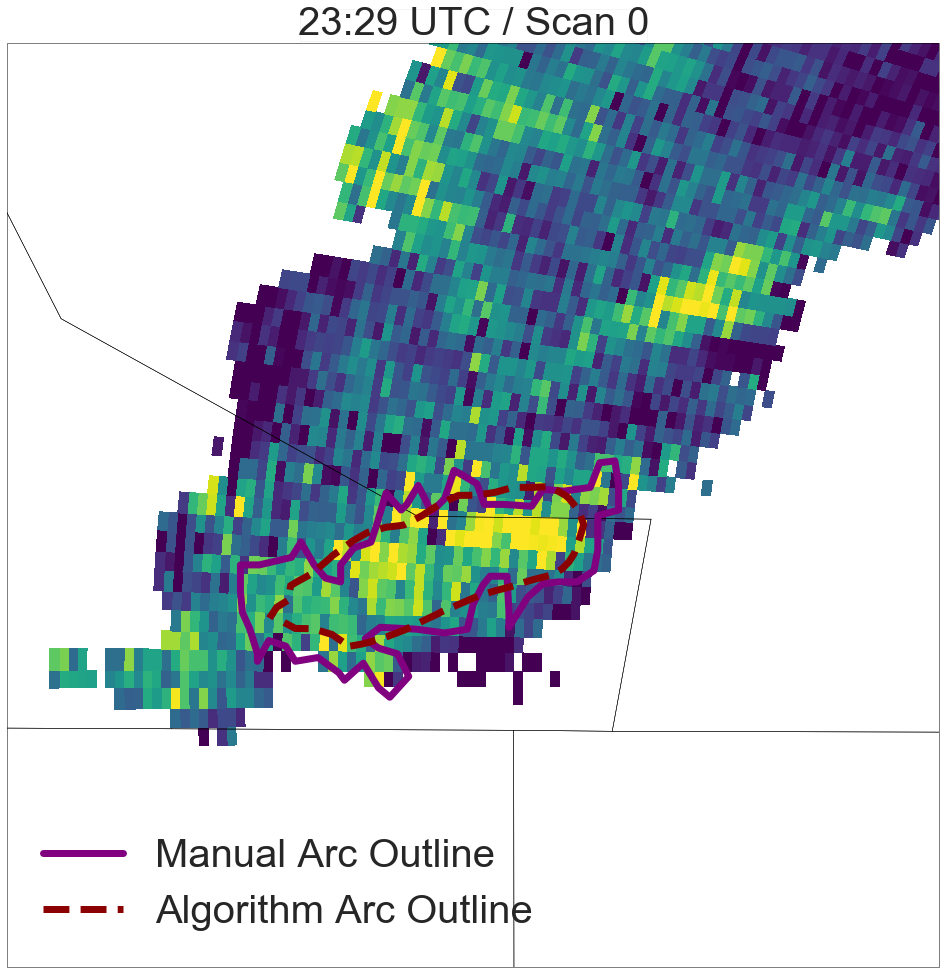

In [81]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.55,cenlat-0.20,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.27,cenlat+0.06,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 2
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], zdr_arrays[time1], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time1], edgecolor = 'purple', facecolor='none', alpha=1.0, linewidth = 7)
for j in range(len(arc_outlines4[time1])):
            patch = PathPatch(arc_outlines4[time1][j], facecolor = 'none', alpha=1.0, edgecolor='darkred', linewidth=7, linestyle='--', zorder=10)
            ax.add_patch(patch)
            
manual = mlines.Line2D([], [], color='purple', linewidth = 7,linestyle = 'solid', label='Manual Arc Outline')
algorithm = mlines.Line2D([], [], color='darkred', linewidth = 7,linestyle = '--', label='Algorithm Arc Outline')
plt.legend(handles=[manual, algorithm], loc = 3, fontsize = 40)
plt.title('23:29 UTC / Scan 0', size = 40, bbox={'facecolor':'white','pad':-2})
# cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
# cg1.ax.tick_params(labelsize=30)
# cg1.set_label("Differential Reflectivity (dB)",size = 45)
#plt.legend()
plt.savefig("PaperArcOutlines0.png")

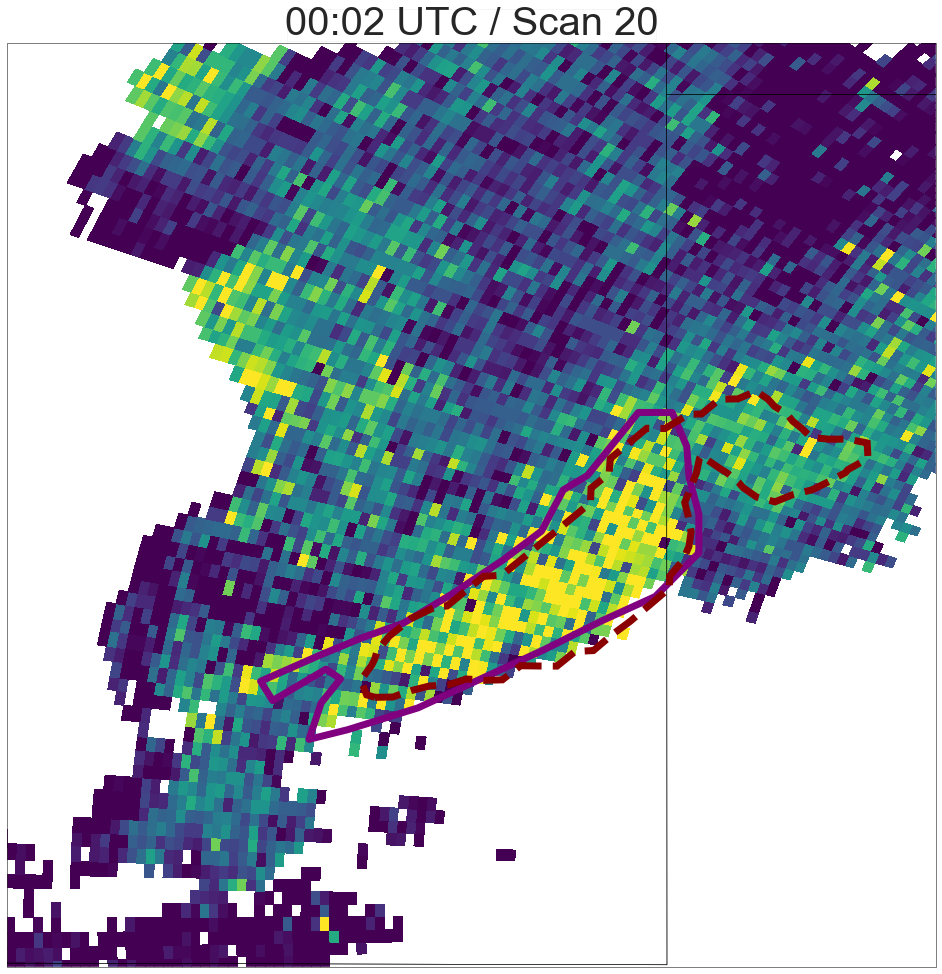

In [82]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.30,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.02,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 20
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], zdr_arrays[time1], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time1], edgecolor = 'purple', facecolor='none', alpha=1.0, linewidth = 7)
for j in range(len(arc_outlines4[time1])):
            patch = PathPatch(arc_outlines4[time1][j], facecolor = 'none', alpha=1.0, edgecolor='darkred', linewidth=7, linestyle='--', zorder=10)
            ax.add_patch(patch)
plt.title('00:02 UTC / Scan 20', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("PaperArcOutlines20.png")

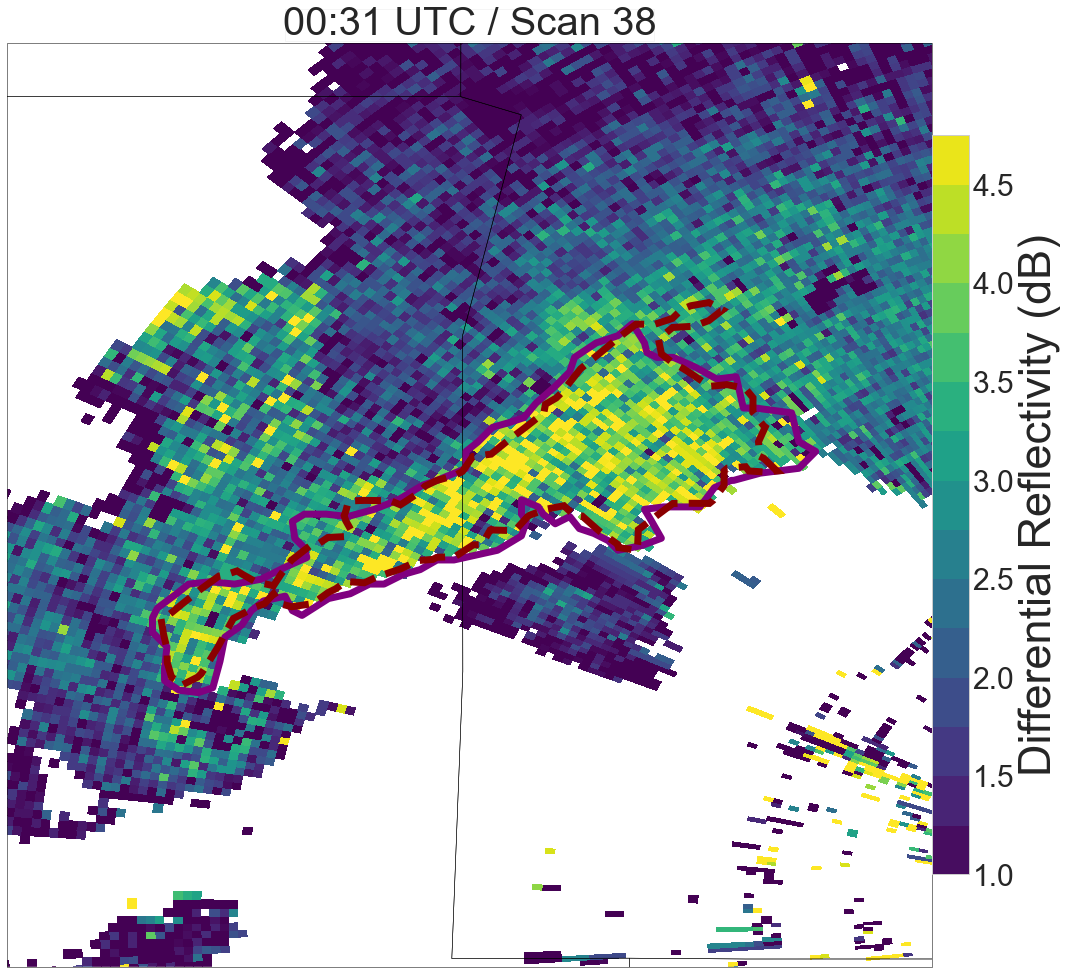

In [83]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.05,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon+0.23,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 38
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], zdr_arrays[time1], cmap=plt.cm.viridis, vmin = 1, vmax = 5)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time1], edgecolor = 'purple', facecolor='none', alpha=1.0, linewidth = 7)
for j in range(len(arc_outlines4[time1])):
            patch = PathPatch(arc_outlines4[time1][j], facecolor = 'none', alpha=1.0, edgecolor='darkred', linewidth=7, linestyle='--', zorder=10)
            ax.add_patch(patch)
cg1 = plt.colorbar(refg, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Differential Reflectivity (dB)",size = 45)
plt.title('00:31 UTC / Scan 38', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("PaperArcOutlines38.png")

0
1


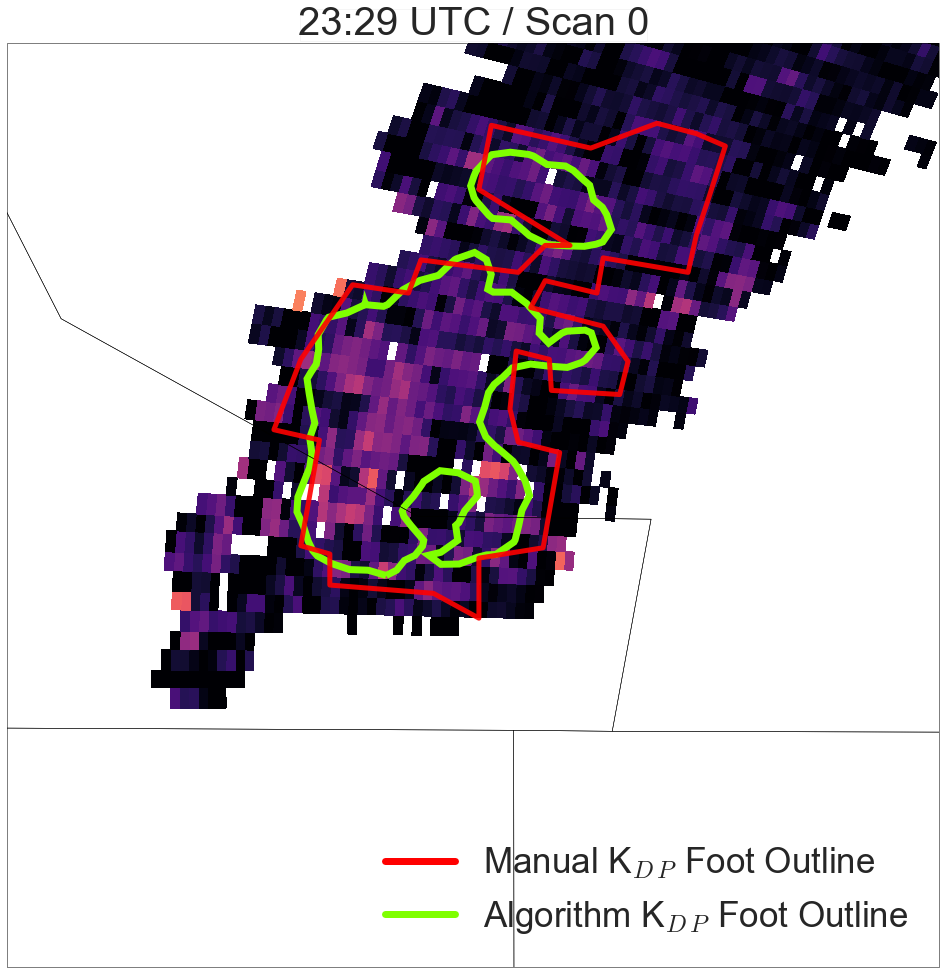

In [84]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.55,cenlat-0.20,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.27,cenlat+0.06,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 2
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], kdp_arrays[time1], cmap=plt.cm.magma, vmin = 0, vmax = 10)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
for i in range(len(foot_outlines1[time1])):
    print(i)
    patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
    ax.add_patch(patch)
#m_arcc = plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', label = 'Manual Arc Centroid', zorder=14)
#m_footc = plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='*', color='red', label = "Manual Foot Centroid", zorder=14)

#a_arcc = plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=800, marker='o', color='gold', label="Algorithm Arc Centroid", zorder=13)
#a_footc = plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=800, marker='o', color='chartreuse', label="Algorithm Foot Centroid", zorder=13)

manual = mlines.Line2D([], [], color='red', linewidth = 7,linestyle = 'solid', label='Manual K$_D$$_P$ Foot Outline')
algorithm = mlines.Line2D([], [], color='chartreuse', linewidth = 7,linestyle = 'solid', label='Algorithm K$_D$$_P$ Foot Outline')
plt.legend(handles=[manual, algorithm], loc = 4, fontsize = 35)
plt.title('23:29 UTC / Scan 0', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewPaperFootOutlines0.png")

0
1
2
3


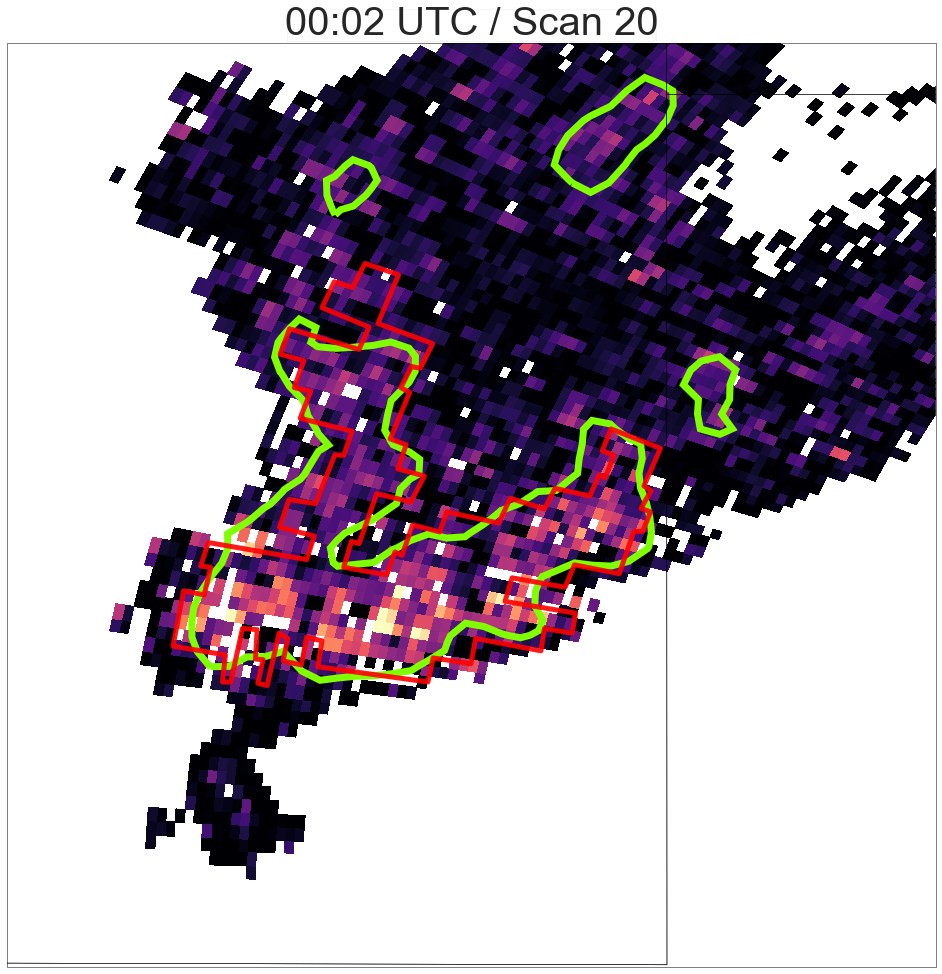

In [85]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.30,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.02,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 20
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], kdp_arrays[time1], cmap=plt.cm.magma, vmin = 0, vmax = 10)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
for i in range(len(foot_outlines1[time1])):
    print(i)
    patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
    ax.add_patch(patch)
#plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', zorder=14)
#plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='*', color='red', zorder=14)

#plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=800, marker='o', color='gold', zorder=13)
#plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=800, marker='o', color='chartreuse', zorder=13)
plt.title('00:02 UTC / Scan 20', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewPaperFootOutlines20.png")

0
1
2


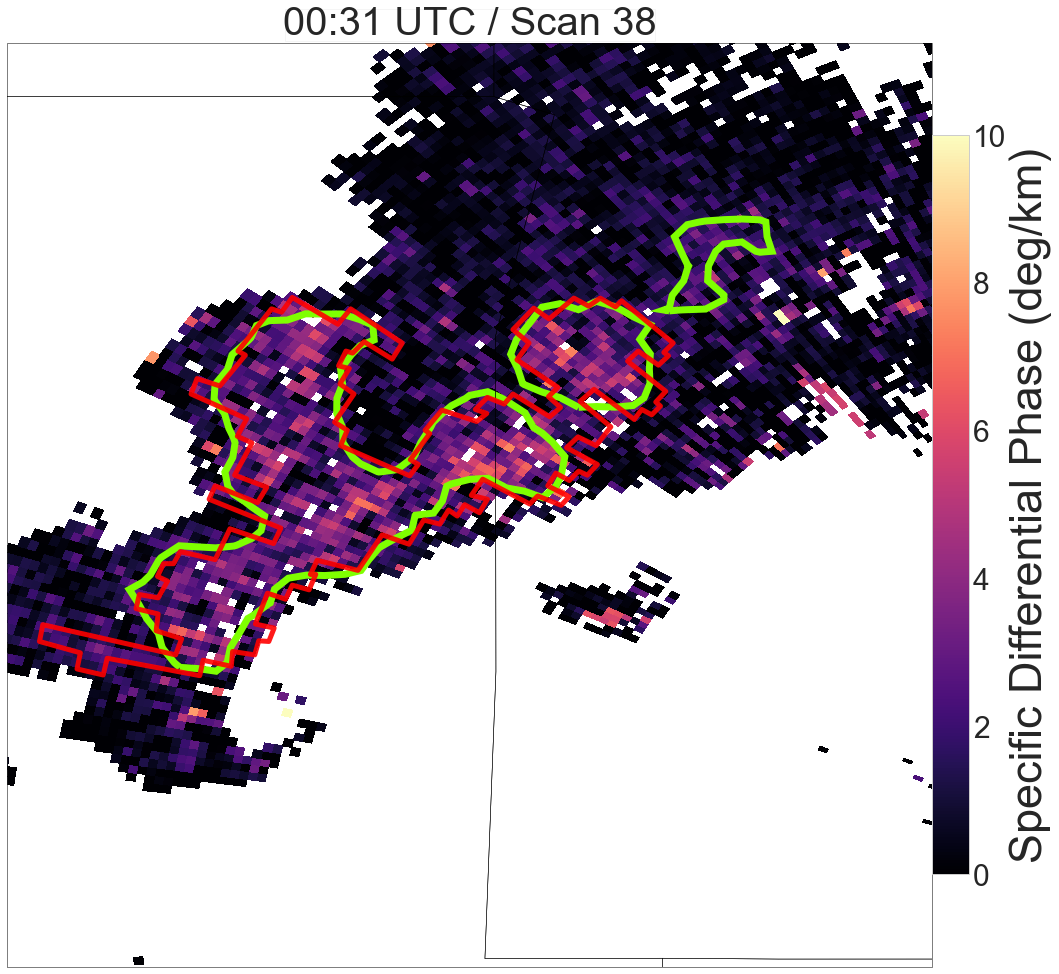

In [86]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.06,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon+0.22,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 38
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], kdp_arrays[time1], cmap=plt.cm.magma, vmin = 0, vmax = 10)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
for i in range(len(foot_outlines1[time1])):
    print(i)
    patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
    ax.add_patch(patch)
#plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', zorder=14)
#plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='*', color='red', zorder=14)

#plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=800, marker='o', color='gold', zorder=13)
#plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=800, marker='o', color='chartreuse', zorder=13)
cg1 = plt.colorbar(refp, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Specific Differential Phase (deg/km)",size = 45)
plt.title('00:31 UTC / Scan 38', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewPaperFootOutlines38.png")

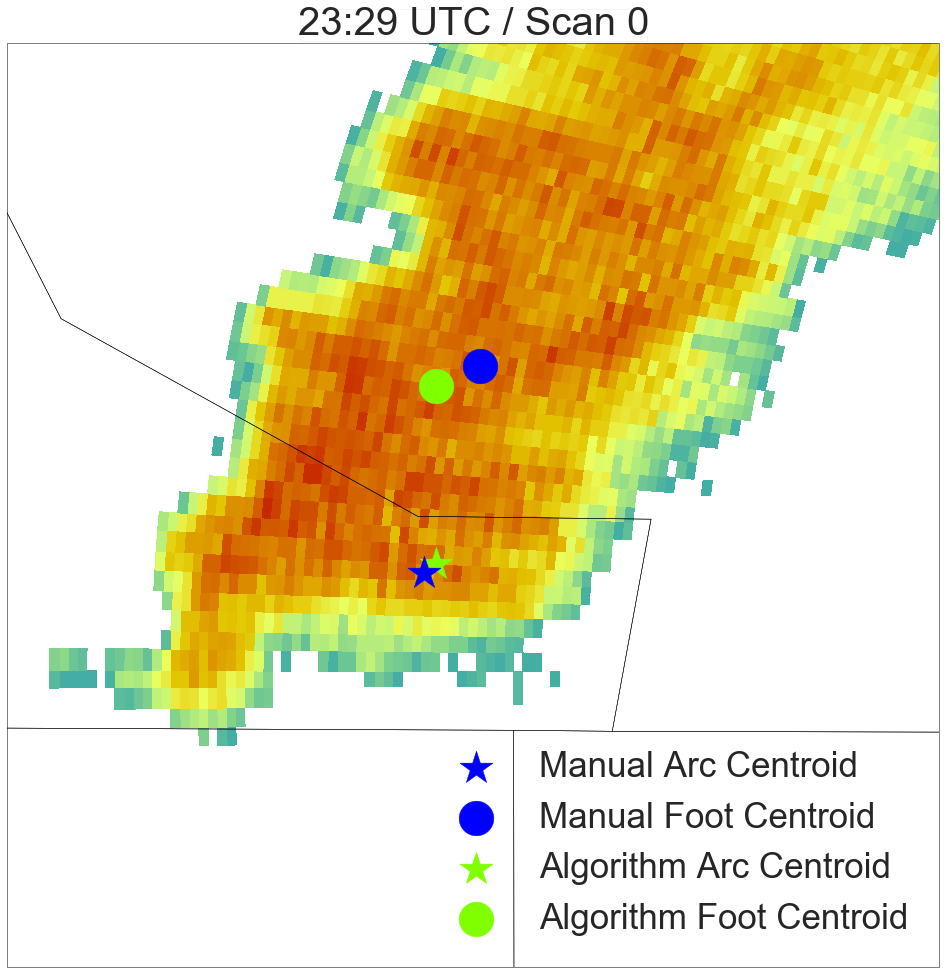

In [87]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.55,cenlat-0.20,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.27,cenlat+0.06,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 2
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin = 10, vmax = 70)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
# arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
# for i in range(len(foot_outlines1[time1])):
#     print(i)
#     patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
#     ax.add_patch(patch)
m_arcc = plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', label = 'Manual Arc Centroid', zorder=14)
m_footc = plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='o', color='blue', label = "Manual Foot Centroid", zorder=14)

a_arcc = plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=1200, marker='*', color='chartreuse', label="Algorithm Arc Centroid", zorder=13)
a_footc = plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=1200, marker='o', color='chartreuse', label="Algorithm Foot Centroid", zorder=13)

#manual = mlines.Line2D([], [], color='red', linewidth = 7,linestyle = 'solid', label='Manual K$_D$$_P$ Foot Outline')
#algorithm = mlines.Line2D([], [], color='chartreuse', linewidth = 7,linestyle = 'solid', label='Algorithm K$_D$$_P$ Foot Outline')
plt.legend(handles=[m_arcc, m_footc, a_arcc, a_footc], loc = 4, fontsize = 35)
plt.title('23:29 UTC / Scan 0', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewCentroidOutlines0.png")

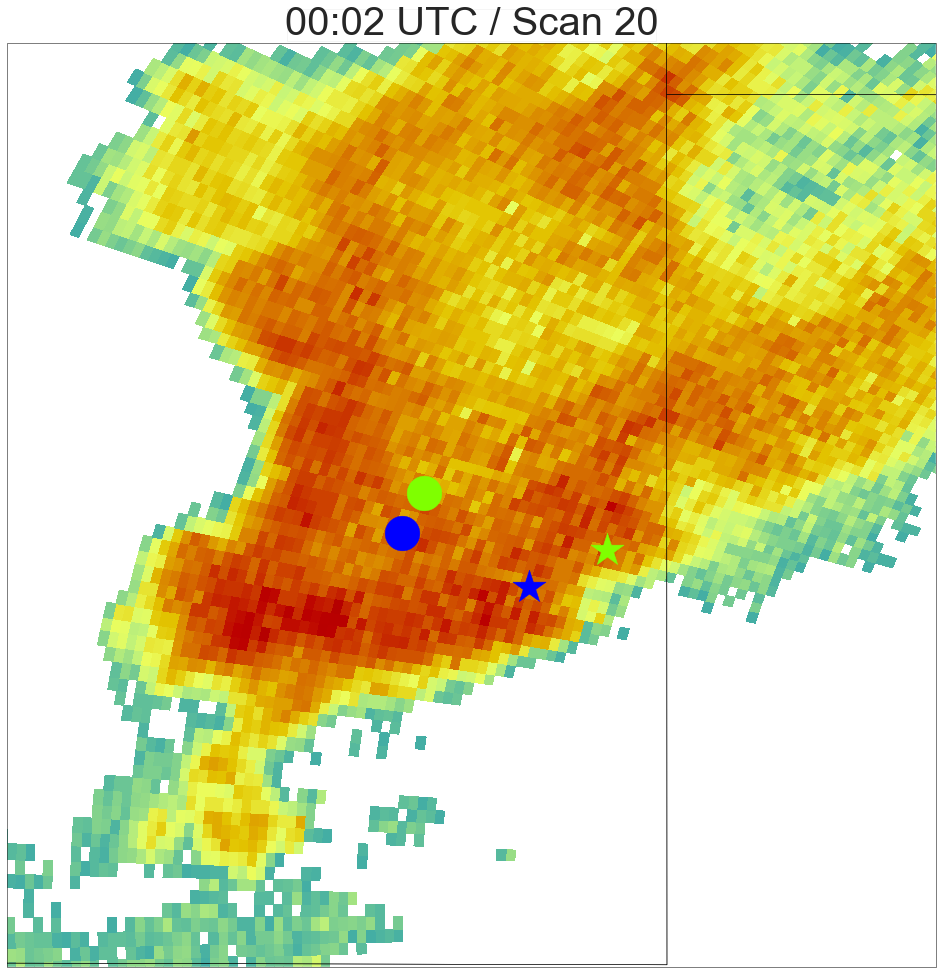

In [88]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.30,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon-0.02,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 20
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin = 10, vmax = 70)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
# arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
# for i in range(len(foot_outlines1[time1])):
#     print(i)
#     patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
#     ax.add_patch(patch)
plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', zorder=14)
plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='o', color='blue', zorder=14)

plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=1200, marker='*', color='chartreuse', zorder=13)
plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=1200, marker='o', color='chartreuse', zorder=13)
plt.title('00:02 UTC / Scan 20', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewCentroidOutlines20.png")

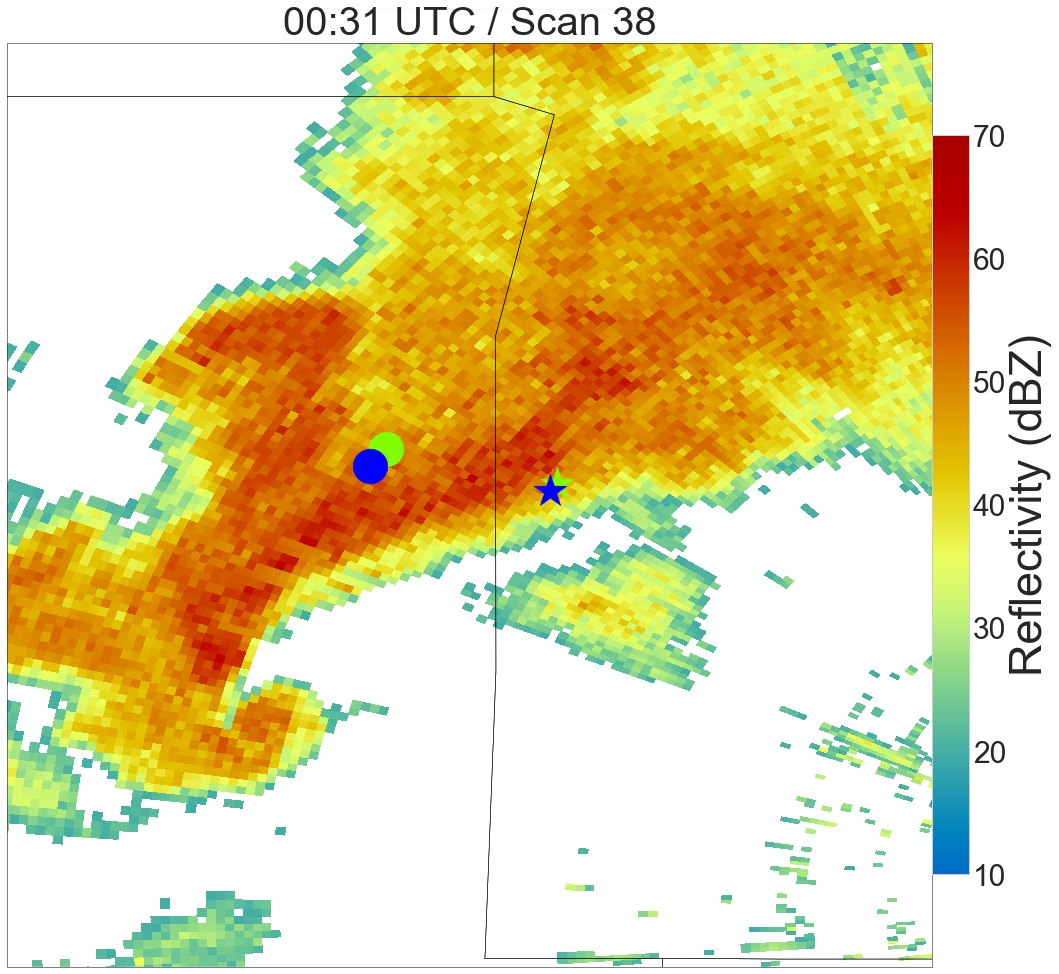

In [89]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
LL2 = crs.transform_point(cenlon-0.06,cenlat-0.13,ccrs.PlateCarree())
UR2 = crs.transform_point(cenlon+0.22,cenlat+0.13,ccrs.PlateCarree())
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL2[0],UR2[0],LL2[1],UR2[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 38
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin = 10, vmax = 70)
#refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
# arc = ax.add_feature(footshapefilesc[time1], edgecolor = 'red', linewidth=5, alpha=0.9)
# for i in range(len(foot_outlines1[time1])):
#     print(i)
#     patch = PathPatch(foot_outlines1[time1][i], facecolor = 'none', edgecolor='chartreuse', linewidth=7)
#     ax.add_patch(patch)
plt.scatter(arc_clonsc[time1], arc_clatsc[time1], s=1200, marker='*', color='blue', zorder=14)
plt.scatter(foot_clonsc[time1], foot_clatsc[time1], s=1200, marker='o', color='blue', zorder=14)

plt.scatter(arc_alg_cenlons[time1], arc_alg_cenlats[time1], s=1200, marker='*', color='chartreuse', zorder=13)
plt.scatter(foot_alg_cenlons[time1], foot_alg_cenlats[time1], s=1200, marker='o', color='chartreuse', zorder=13)
cg1 = plt.colorbar(refp, shrink=0.80, pad=0)
cg1.ax.tick_params(labelsize=30)
cg1.set_label("Reflectivity (dBZ)",size = 45)
plt.title('00:31 UTC / Scan 38', size = 40, bbox={'facecolor':'white','pad':-2})
plt.savefig("NewCentroidOutlines38.png")

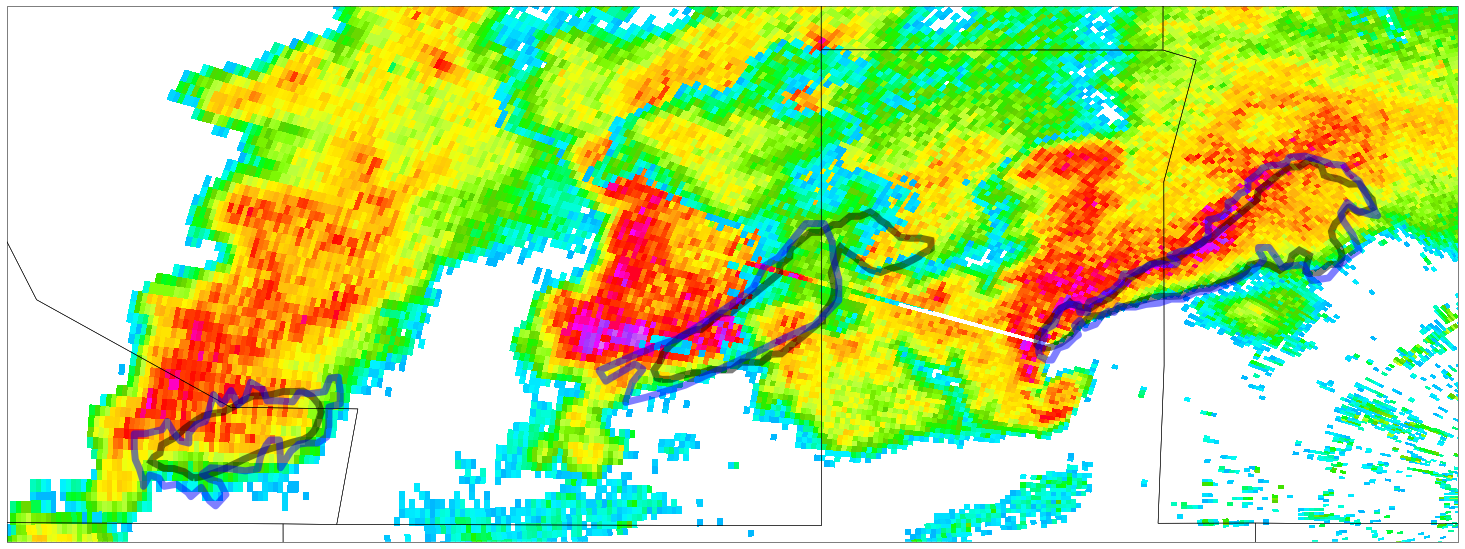

In [90]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
time1 = 2
refp = ax.pcolormesh(lon_arrays[time1], lat_arrays[time1], refl_arrays[time1], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time1], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
for j in range(len(arc_outlines4[time1])):
            patch = PathPatch(arc_outlines4[time1][j], facecolor = 'none', alpha=0.5, edgecolor='k', linewidth=7)
            ax.add_patch(patch)

time2 = 20
refp = ax.pcolormesh(lon_arrays[time2], lat_arrays[time2], refl_arrays[time2], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time2], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
for j in range(len(arc_outlines4[time2])):
            patch = PathPatch(arc_outlines4[time2][j], facecolor = 'none', alpha=0.5, edgecolor='k', linewidth=7)
            ax.add_patch(patch)
            
time3 = 39
refp = ax.pcolormesh(lon_arrays[time3], lat_arrays[time3], refl_arrays[time3], cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
ax.add_feature(arcshapefilesc[time3], edgecolor = 'blue', facecolor='none', alpha=0.5, linewidth = 7)
for j in range(len(arc_outlines4[time3])):
            patch = PathPatch(arc_outlines4[time3][j], facecolor = 'none', alpha=0.5, edgecolor='k', linewidth=7)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [91]:
g = Geod(ellps='sphere')

In [92]:
foot_clonsa = np.asarray(foot_clonsc)
foot_clatsa = np.asarray(foot_clatsc)
arc_clonsa = np.asarray(arc_clonsc)
arc_clatsa = np.asarray(arc_clatsc)

foot_alg_cenlonsa = np.asarray(foot_alg_cenlons)
foot_alg_cenlatsa = np.asarray(foot_alg_cenlats)
arc_alg_cenlonsa = np.asarray(arc_alg_cenlons)
arc_alg_cenlatsa = np.asarray(arc_alg_cenlats)

distance_kdp_zdr_obs = g.inv(foot_clonsa, foot_clatsa, arc_clonsa, arc_clatsa)
dist_kdp_zdr_obs = distance_kdp_zdr_obs[2] / 1000.

distance_kdp_zdr_alg = g.inv(foot_alg_cenlonsa, foot_alg_cenlatsa, arc_alg_cenlonsa, arc_alg_cenlatsa)
dist_kdp_zdr_alg = distance_kdp_zdr_alg[2] / 1000.
print(dist_kdp_zdr_obs)
print(dist_kdp_zdr_alg)

print(dist_kdp_zdr_obs.shape)
print(dist_kdp_zdr_alg.shape)

back_kobs = distance_kdp_zdr_obs[1]
#print('Raw back angle', back[i])
for i in range(back_kobs.shape[0]):
    #print('loop is ok')
    if distance_kdp_zdr_obs[1][i] < 0:
        #print('if is ok')
        back_kobs[i] = distance_kdp_zdr_obs[1][i] + 360
print(back_kobs)

back_kalg = distance_kdp_zdr_alg[1]
#print('Raw back angle', back[i])
for i in range(back_kalg.shape[0]):
    #print('loop is ok')
    if distance_kdp_zdr_alg[1][i] < 0:
        #print('if is ok')
        back_kalg[i] = distance_kdp_zdr_alg[1][i] + 360
print(back_kalg)

[7.92386519 8.2526212  7.07546455 4.38028538        nan 4.79308701
 6.22463856 6.32732887 6.50024013 6.04311027 6.56115955 6.41592313
 3.82008413 3.90874488 3.90226233 3.51740693 3.99776036 4.73249054
        nan        nan 3.87756778 2.788455   4.68511512 5.41946738
 3.97162715 5.34927169 6.27472587 3.83591728 2.92230409 3.45428405
 3.30483017 3.04596356 3.49439978 3.65501932 6.29733859 7.71566028
 5.03496218        nan 4.95392554 5.40008615]
[7.35492159        nan 5.92883285 5.75203236 4.48309707 6.15503631
 7.59204122        nan 6.0178675  6.60575255 7.47615633 8.90530877
        nan 4.16251586 4.34981023 4.32855864 4.51554067 5.67878551
 5.92557607 4.35442821 5.2990671  4.23049785 5.07279682 5.79599484
 5.42546266 5.63400832 6.41173173 4.68318737 3.77086838 4.01624888
 3.54296846 3.79057924 4.804013   5.3348545  6.50210175 8.08660746
 8.38398115 6.11240269 4.79587027 5.42099715]
(40,)
(40,)
[ 11.00756473  26.41929273  12.17211026 338.73339233          nan
 340.59127659 355.35187181

In [93]:
print(back_kobs[20])
print(back_kalg[20])

sep_obs = back_kobs - 259
sep_alg = back_kalg - 259
print(sep_obs)
print(sep_alg)

sep_obs[sep_obs < -180] = (sep_obs[sep_obs < -180] * -1) - 180 
sep_alg[sep_alg < -180] = (sep_alg[sep_alg < -180] * -1) - 180 

print(sep_obs)
print(sep_alg)


297.8061889147326
291.26881463984574
[-247.99243527 -232.58070727 -246.82788974   79.73339233           nan
   81.59127659   96.35187181 -258.10892253 -256.90970414 -241.88562371
 -240.42528173 -246.52026264   87.18610068   60.18610196   62.83850309
   57.44468643   51.29760635   43.57475929           nan           nan
   38.80618891   41.18514819   11.88823473   13.71739376   29.46294281
   24.82976727   27.32192512   33.09427181   37.46075887   35.35166487
   36.94961492   42.35967222   33.98551325   34.3460812     9.82532696
   12.34953852   12.50943902           nan   20.77506836   13.23233175]
[-250.39157914           nan -258.97341309   16.03295567   59.1150107
   29.55833904   14.42037857           nan   83.23336949   19.98077857
   22.72482115   17.59160749           nan   53.97158994   48.21082161
   58.95188888   30.99101067   38.90512676   40.2529243    43.58444189
   32.26881464   31.38828027   12.01023936   12.0326332    18.56095005
   20.85043229   22.69093362   23.363122

C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


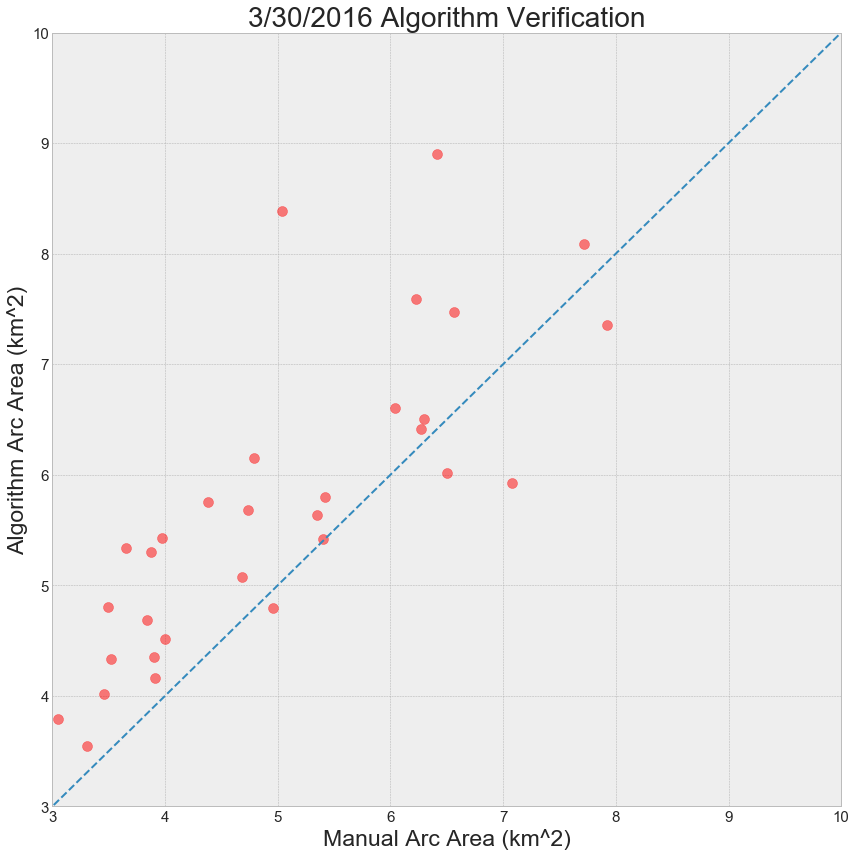

In [94]:
plt.style.use('bmh')
fig = plt.figure(1, (12, 12))
#x = np.arange(0, len(arcshapefiles[1:21]), 1)
#plt.scatter(np.asarray(areasc), storm3_alg_f[0:40], label='3.5 dB Alg')
plt.scatter(dist_kdp_zdr_obs, dist_kdp_zdr_alg, color='r', s=100, alpha=0.5)
#plt.scatter(np.asarray(areasc), storm5_alg_f[0:40], color='g', s=100, alpha=0.5)

plt.xlim(3,10)
plt.ylim(3,10)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Manual Arc Area (km^2)', size=23)
plt.ylabel('Algorithm Arc Area (km^2)', size=23)
plt.title('3/30/2016 Algorithm Verification', size=28)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
line = np.arange(0, 150, 1)
plt.plot(line, line, linestyle='--', linewidth=2)
#plt.text(100, 120, 'R=0.94', size=20)
plt.tight_layout()
#plt.savefig('AlgScatterVerif.png')
plt.show()

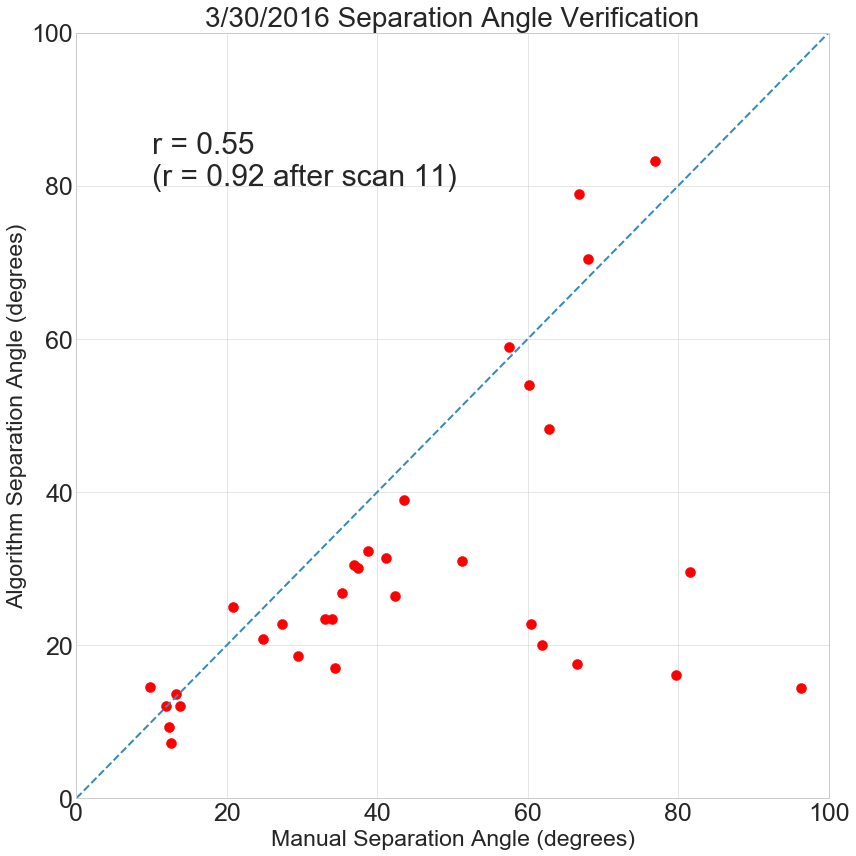

In [113]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
#x = np.arange(0, len(arcshapefiles[1:21]), 1)
#plt.scatter(np.asarray(areasc), storm3_alg_f[0:40], label='3.5 dB Alg')
plt.scatter(sep_obs, sep_alg, color='r', s=100, alpha=1.0)
#plt.scatter(sep_obs[10:], sep_alg[10:], color='k', s=100, alpha=0.5)

#plt.scatter(np.asarray(areasc), storm5_alg_f[0:40], color='g', s=100, alpha=0.5)

plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('Manual Separation Angle (degrees)', size=23)
plt.ylabel('Algorithm Separation Angle (degrees)', size=23)
plt.title('3/30/2016 Separation Angle Verification', size=28)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
line = np.arange(0, 150, 1)
plt.plot(line, line, linestyle='--', linewidth=2)
plt.text(10, 80, 'r = 0.55 \n(r = 0.92 after scan 11)', size=30)
plt.tight_layout()
plt.savefig('AlgAngleVerif.png')
plt.show()

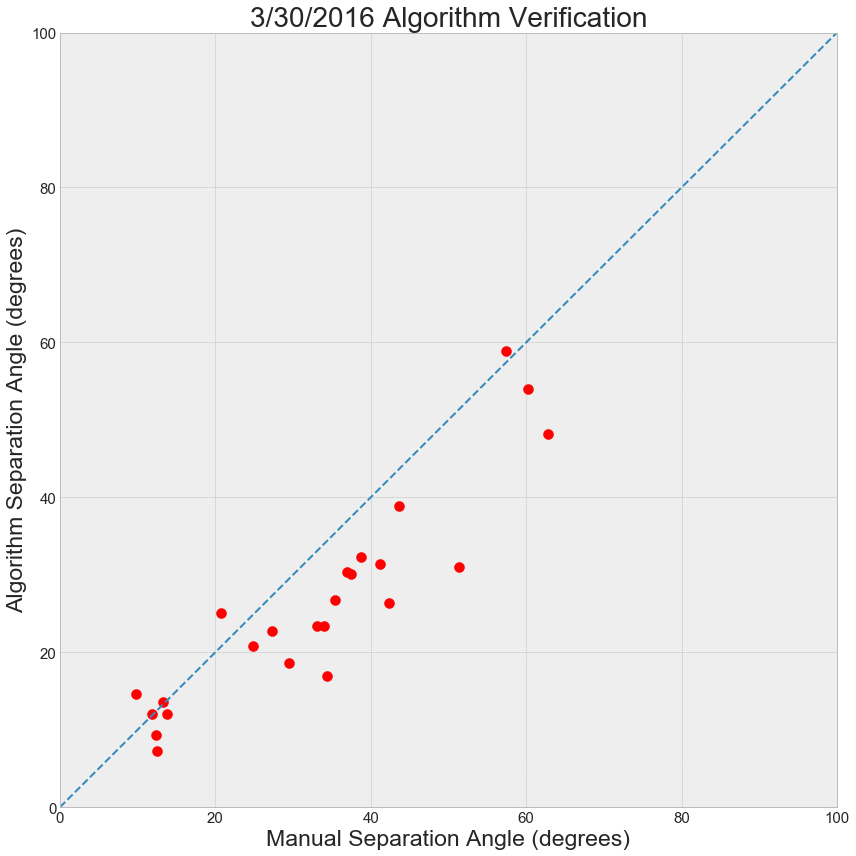

In [96]:
plt.style.use('bmh')
fig = plt.figure(1, (12, 12))
#x = np.arange(0, len(arcshapefiles[1:21]), 1)
#plt.scatter(np.asarray(areasc), storm3_alg_f[0:40], label='3.5 dB Alg')
plt.scatter(sep_obs[13:], sep_alg[13:], color='r', s=100, alpha=1.0)
#plt.scatter(sep_obs[10:], sep_alg[10:], color='k', s=100, alpha=0.5)

#plt.scatter(np.asarray(areasc), storm5_alg_f[0:40], color='g', s=100, alpha=0.5)

plt.xlim(0,100)
plt.ylim(0,100)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Manual Separation Angle (degrees)', size=23)
plt.ylabel('Algorithm Separation Angle (degrees)', size=23)
plt.title('3/30/2016 Algorithm Verification', size=28)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
line = np.arange(0, 150, 1)
plt.plot(line, line, linestyle='--', linewidth=2)
#plt.text(100, 120, 'R=0.94', size=20)
plt.tight_layout()
#plt.savefig('AlgAngleVerif.png')
plt.show()

In [97]:
ind_s = 13
sep_obs_s = sep_obs[ind_s:]
sep_alg_s = sep_alg[ind_s:]
sep_obs1s = sep_obs_s[~np.isnan(sep_obs_s)]
sep_alg1s = sep_alg_s[~np.isnan(sep_obs_s)]
sep_obs2s = sep_obs1s[~np.isnan(sep_alg1s)]
sep_alg2s = sep_alg1s[~np.isnan(sep_alg1s)]


sep_obs1 = sep_obs[~np.isnan(sep_obs)]
sep_alg1 = sep_alg[~np.isnan(sep_obs)]
sep_obs2 = sep_obs1[~np.isnan(sep_alg1)]
sep_alg2 = sep_alg1[~np.isnan(sep_alg1)]

sep_spr = stats.spearmanr(sep_obs2, sep_alg2)
sep_sprs = stats.spearmanr(sep_obs2s, sep_alg2s)

print(sep_spr)
print(sep_sprs)

SpearmanrResult(correlation=0.5544786096256685, pvalue=0.0008127468344176202)
SpearmanrResult(correlation=0.9226086956521738, pvalue=1.4324486487633293e-10)


In [98]:
dist_kdp_zdr_obs1 = dist_kdp_zdr_obs[~np.isnan(dist_kdp_zdr_obs)]
dist_kdp_zdr_alg1 = dist_kdp_zdr_alg[~np.isnan(dist_kdp_zdr_obs)]
dist_kdp_zdr_obs2 = dist_kdp_zdr_obs1[~np.isnan(dist_kdp_zdr_alg1)]
dist_kdp_zdr_alg2 = dist_kdp_zdr_alg1[~np.isnan(dist_kdp_zdr_alg1)]

dist_kdp_zdr_spr = stats.spearmanr(dist_kdp_zdr_obs2, dist_kdp_zdr_alg2)
print(dist_kdp_zdr_spr)

SpearmanrResult(correlation=0.8709893048128343, pvalue=4.369697303418974e-11)


In [99]:
sepdiff = sep_obs - sep_alg

print(np.nanmean(np.abs(sepdiff)))
print(np.nanmedian(np.abs(sepdiff)))

15.937966641149204
7.38809810282612


In [100]:
print(arc_alg_cenlats)
print(np.nanmean(sep_alg[12:27]))
print(np.nanmedian(sep_alg[12:27]))

[36.199908208298794, nan, 36.21235159327094, 36.26037486122373, 36.24242887713967, 36.25266811975792, 36.26412100931929, nan, 36.222650460746536, 36.26611222610778, 36.27112192316827, 36.27792713161443, nan, 36.25403984812665, 36.263579957386085, 36.264744797113856, 36.27709661369736, 36.28601040002945, 36.28417456120164, 36.27813160562656, 36.28634526603493, 36.284331971520196, 36.286871164943264, 36.287176949555466, 36.28866235965763, 36.28532954937045, 36.28731263242788, 36.28891009115813, 36.29237730682779, 36.2937959924877, 36.29882834567282, 36.30470513770991, 36.30839880322858, 36.30977245134028, 36.31138794553454, 36.31692354389816, 36.32142643876049, 36.31882828790991, 36.30638019383416, 36.315998851774616]
33.19072053562356
31.82854745553911


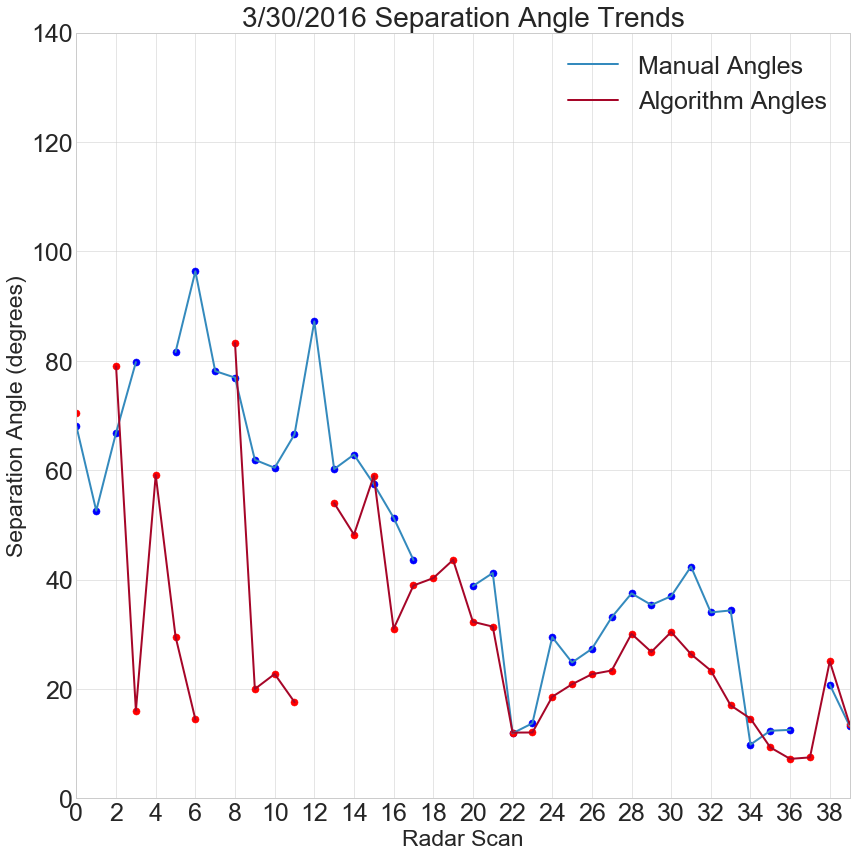

In [114]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(1, (12, 12))
x = np.arange(0, len(arcshapefilesc), 1)
x1 = np.arange(0, len(arcshapefiles[0:21]), 1)
plt.plot(x, sep_obs, label='Manual Angles')
plt.scatter(x, sep_obs, color='blue', s=50)

#plt.plot(x1+19, np.asarray(areas[0:21]))
#plt.plot(x1[1:21]+19, storm1_alg_f[0:20])
#plt.plot(x1[1:21]+19, storm2_alg_f[0:20])
#plt.plot(x, storm3_alg_f[0:40])
plt.plot(x, sep_alg, label='Algorithm Angles')
plt.scatter(x, sep_alg, color='red', s=50)

#plt.plot(x, storm5_alg_f[0:40], label='Algorithm Areas')

plt.title('3/30/2016 Separation Angle Trends', size=28)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
plt.xlabel('Radar Scan', size=23)
plt.ylabel('Separation Angle (degrees)', size=23)
plt.ylim(0, 140)
plt.xlim(0, 39)
plt.xticks(x[::2], size=25)
plt.yticks(size=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig('SeparationAngleSeries.png')
plt.show()

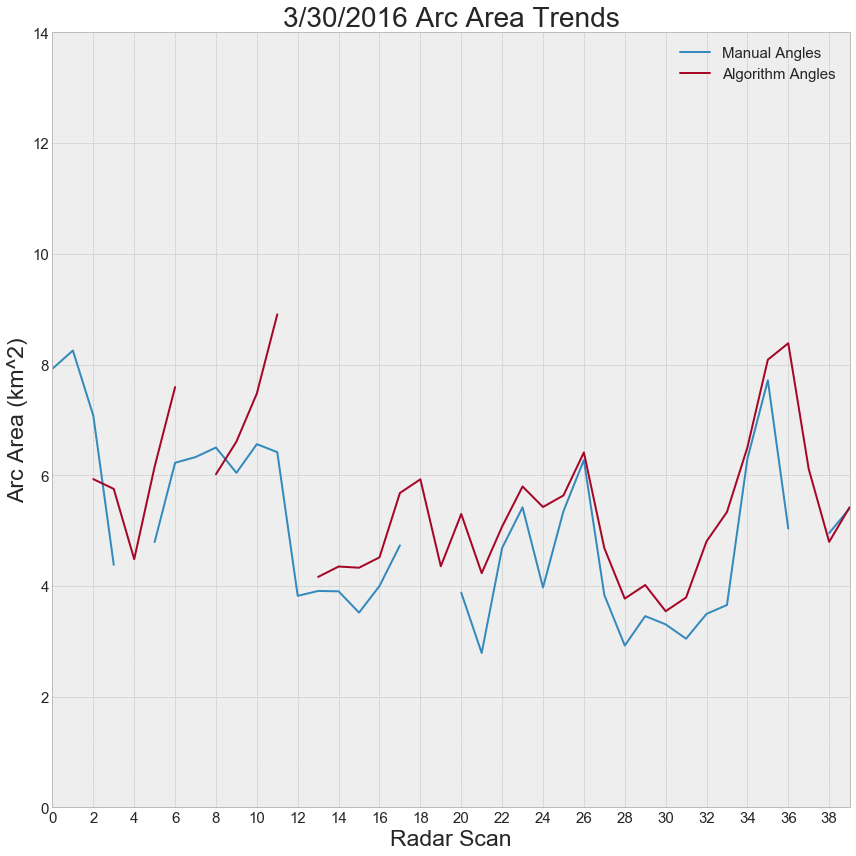

In [102]:
plt.style.use('bmh')
fig = plt.figure(1, (12, 12))
x = np.arange(0, len(arcshapefilesc), 1)
x1 = np.arange(0, len(arcshapefiles[0:21]), 1)
plt.plot(x, dist_kdp_zdr_obs, label='Manual Angles')
#plt.plot(x1+19, np.asarray(areas[0:21]))
#plt.plot(x1[1:21]+19, storm1_alg_f[0:20])
#plt.plot(x1[1:21]+19, storm2_alg_f[0:20])
#plt.plot(x, storm3_alg_f[0:40])
plt.plot(x, dist_kdp_zdr_alg, label='Algorithm Angles')
#plt.plot(x, storm5_alg_f[0:40], label='Algorithm Areas')

plt.title('3/30/2016 Arc Area Trends', size=28)
#plt.plot(x[::4], np.asarray(areas)[::4])
#plt.plot(x[1::4], np.asarray(areas)[1::4])
plt.xlabel('Radar Scan', size=23)
plt.ylabel('Arc Area (km^2)', size=23)
plt.ylim(0, 14)
plt.xlim(0, 39)
plt.xticks(x[::2], size=15)
plt.yticks(size=15)
plt.legend(fontsize=15)
plt.tight_layout()
#plt.savefig('ArcTimeSeries.png')
plt.show()

In [103]:
print(sepdiff)

[ -2.39914387          nan -12.14552335  63.70043666          nan
  52.03293755  81.93149323          nan  -6.32366535  41.90484514
  37.70046058  48.92865515          nan   6.21451202  14.62768147
  -1.50720244  20.30659567   4.66963253          nan          nan
   6.53737427   9.79686792  -0.12200463   1.68476056  10.90199275
   3.97933498   4.6309915    9.73114971   7.3880981    8.59222547
   6.54012875  16.00928651  10.63033233  17.35182396  -4.74590204
   3.04718488   5.30024481          nan  -4.25495322  -0.31545773]


C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\matts\AppData\Local\Continuum\anaconda3\envs\radar\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([17.,  8.,  2.,  0.,  1.,  2.,  1.,  1.,  0.,  1.]),
 array([ 0.12200463,  8.30295349, 16.48390235, 24.66485121, 32.84580007,
        41.02674893, 49.20769779, 57.38864665, 65.56959551, 73.75054437,
        81.93149323]),
 <a list of 10 Patch objects>)

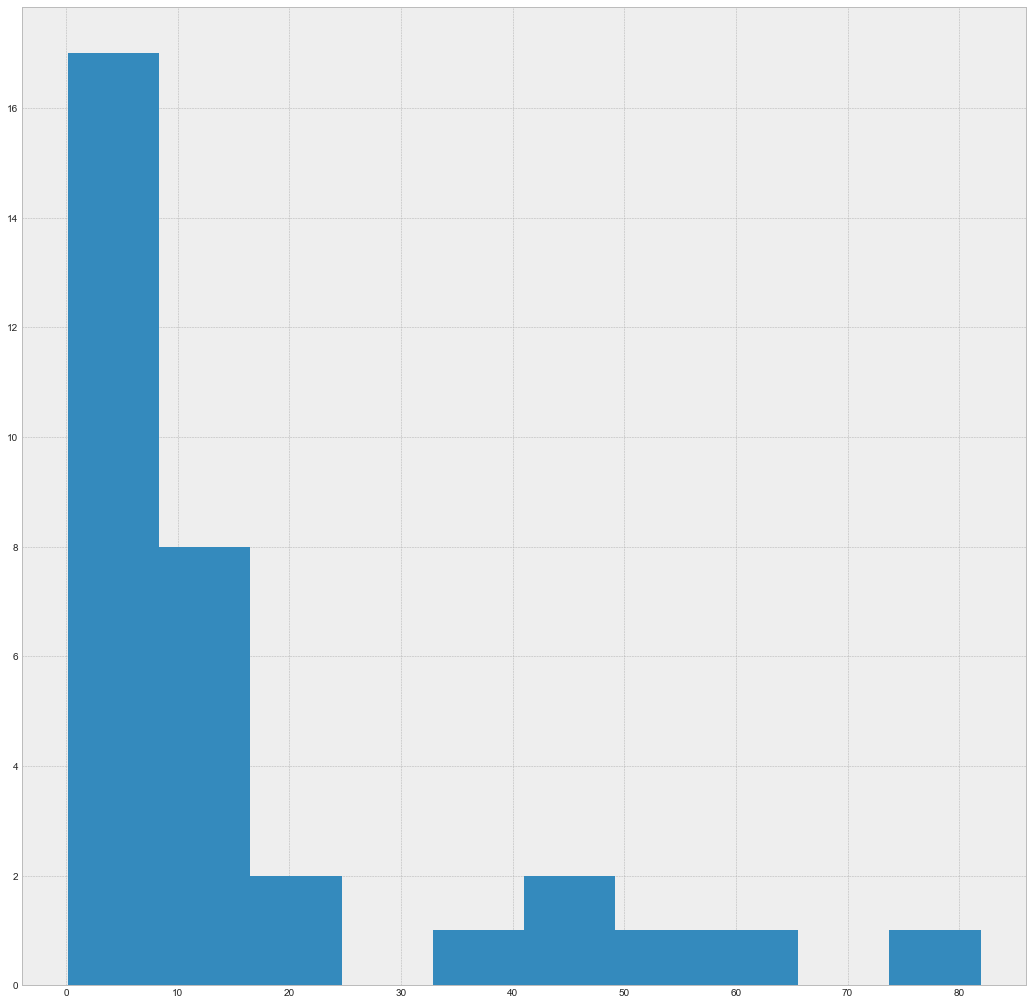

In [104]:
plt.figure(1, figsize=(18,18))
plt.hist(np.abs(sepdiff))

ValueError: Colormap HomeyerRainbow is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, pyart_BlueBrown10, pyart_BlueBrown10_r, pyart_BlueBrown11, pyart_BlueBrown11_r, pyart_BrBu10, pyart_BrBu10_r, pyart_BrBu12, pyart_BrBu12_r, pyart_Bu10, pyart_Bu10_r, pyart_Bu7, pyart_Bu7_r, pyart_BuDOr12, pyart_BuDOr12_r, pyart_BuDOr18, pyart_BuDOr18_r, pyart_BuDRd12, pyart_BuDRd12_r, pyart_BuDRd18, pyart_BuDRd18_r, pyart_BuGr14, pyart_BuGr14_r, pyart_BuGy8, pyart_BuGy8_r, pyart_BuOr10, pyart_BuOr10_r, pyart_BuOr12, pyart_BuOr12_r, pyart_BuOr8, pyart_BuOr8_r, pyart_BuOrR14, pyart_BuOrR14_r, pyart_Carbone11, pyart_Carbone11_r, pyart_Carbone17, pyart_Carbone17_r, pyart_Carbone42, pyart_Carbone42_r, pyart_Cat12, pyart_Cat12_r, pyart_EWilson17, pyart_EWilson17_r, pyart_GrMg16, pyart_GrMg16_r, pyart_Gray5, pyart_Gray5_r, pyart_Gray9, pyart_Gray9_r, pyart_HomeyerRainbow, pyart_HomeyerRainbow_r, pyart_LangRainbow12, pyart_LangRainbow12_r, pyart_NWSRef, pyart_NWSRef_r, pyart_NWSVel, pyart_NWSVel_r, pyart_NWS_SPW, pyart_NWS_SPW_r, pyart_PD17, pyart_PD17_r, pyart_RRate11, pyart_RRate11_r, pyart_RdYlBu11b, pyart_RdYlBu11b_r, pyart_RefDiff, pyart_RefDiff_r, pyart_SCook18, pyart_SCook18_r, pyart_StepSeq25, pyart_StepSeq25_r, pyart_SymGray12, pyart_SymGray12_r, pyart_Theodore16, pyart_Theodore16_r, pyart_Wild25, pyart_Wild25_r, pyart_balance, pyart_balance_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

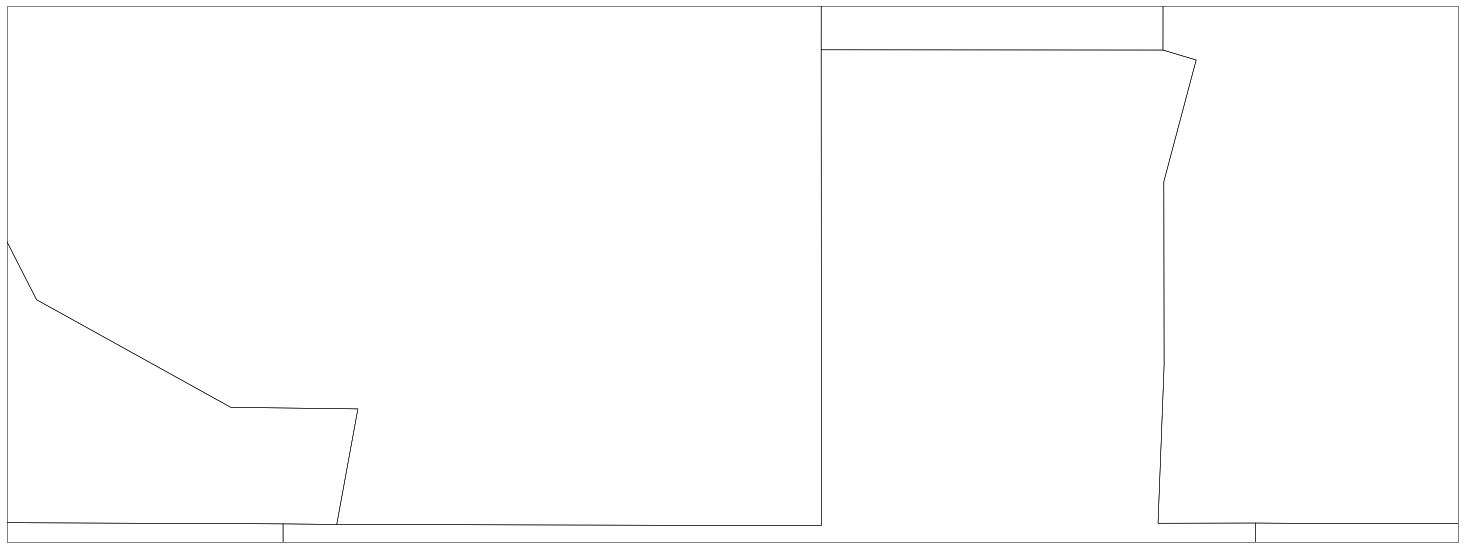

In [105]:
%matplotlib inline
#plt.style.use('bmh')
ri = 16
for l in range(len(arcshapefilesc)):

    fig=plt.figure(l+1,figsize=(26.,17.))
    ax = plt.subplot(111,projection=ccrs.PlateCarree())
    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
    ax.coastlines('50m',edgecolor='black',linewidth=0.75)
    ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
    ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
    #polygons = []
    #for i in range(len(arcshapefiles)):
    refp = ax.pcolormesh(lon_arrays[ri], lat_arrays[ri], refl_arrays[ri], cmap='HomeyerRainbow', vmin = 10, vmax = 73)
    for i in [l]:
        arc = ax.add_feature(arcshapefilesc[i], edgecolor = 'purple', facecolor = 'purple', linewidth=1.5, alpha=0.5)
        polygons.append(arc)
    #refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
    #refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)

    #ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
    #ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
    k = 0
    #for i in range(len(arc_outlines)):
    for i in [l]:
        for j in range(len(arc_outlines4[l])):
            patch = PathPatch(arc_outlines4[i][j], facecolor = 'red', alpha=0.5, edgecolor='red', linewidth=1.5, zorder=10)
            ax.add_patch(patch)
            k = k + 1
    plt.tight_layout()
    plt.savefig('AlgObsCompR'+str(l)+'.png')
    ri = ri + 1
plt.show()

In [ ]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.viridis(i*12), facecolor = plt.cm.viridis(i*12), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)

#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#for i in range(len(arc_outlines)):
for l in range(len(arcshapefiles)):
    for i in [l]:
        for j in range(len(arc_outlines[0])):
            patch = PathPatch(arc_outlines[i][j], facecolor = plt.cm.viridis(l*12), alpha=0.5, edgecolor=plt.cm.viridis(l*12), linewidth=1.5, zorder=10)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [ ]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.viridis(i*12), facecolor = plt.cm.viridis(i*12), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)

#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#for i in range(len(arc_outlines)):
for l in range(len(arcshapefiles)):
    for i in [l]:
        for j in range(len(arc_outlines[0])):
            patch = PathPatch(arc_outlines2[i][j], facecolor = plt.cm.viridis(l*12), alpha=0.5, edgecolor=plt.cm.viridis(l*12), linewidth=1.5, zorder=10)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [ ]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
#for i in range(len(arcshapefiles)):
#    arc = ax.add_feature(arcshapefiles[i], edgecolor = plt.cm.viridis(i*12), facecolor = plt.cm.viridis(i*12), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)

#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#for i in range(len(arc_outlines)):
for l in range(len(arcshapefilesc)):
    for i in [l]:
        for j in range(len(arc_outlines4[l])):
            patch = PathPatch(arc_outlines4[i][j], facecolor = plt.cm.viridis(l*7), alpha=0.5, edgecolor=plt.cm.viridis(l*7), linewidth=1.5, zorder=10)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [ ]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
for i in range(len(arcshapefilesc)):
    arc = ax.add_feature(arcshapefilesc[i], edgecolor = plt.cm.magma(i*7), facecolor = plt.cm.magma(i*7), linewidth=1.5, alpha=0.5)
#    polygons.append(arc)

#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#for i in range(len(arc_outlines)):
for l in range(len(arcshapefilesc)):
    for i in [l]:
        for j in range(len(arc_outlines4[l])):
            patch = PathPatch(arc_outlines4[i][j], facecolor = plt.cm.viridis(l*7), alpha=0.5, edgecolor=plt.cm.viridis(l*7), linewidth=1.5, zorder=10)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()

In [ ]:
%matplotlib inline
#plt.style.use('bmh')
# Choose Forecast Hour (FH), FH = 0 is the first hour of dataset
# You can change and rerun this cell to get the different forecast hour
FH = 0
fig=plt.figure(1,figsize=(26.,17.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([LL[0],UR[0],LL[1],UR[1]],crs)
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
#ax.add_feature(arcshapefiles[20], edgecolor = 'green', linewidth = 1.5)
#polygons = []
for i in range(len(arcshapefilesc)):
    arc = ax.add_feature(arcshapefilesc[i], edgecolor = 'b', facecolor = 'b', linewidth=1.5, alpha=0.4)
#    polygons.append(arc)

#refp = ax.pcolormesh(ungrid_lons, ungrid_lats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73, alpha=0.5, zorder=10)
#refp = ax.pcolormesh(tlons, tlats, ref_c, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 73)
#for i in range(len(arc_outlines)):
for l in range(len(arcshapefilesc)):
    for i in [l]:
        for j in range(len(arc_outlines4[l])):
            patch = PathPatch(arc_outlines4[i][j], facecolor = 'r', alpha=0.4, edgecolor= 'r', linewidth=1.5, zorder=10)
            ax.add_patch(patch)
#ax.add_feature(arcshapefiles[0], edgecolor = 'green', linewidth = 1.5)
#ax.add_feature(arcshapefiles[2], edgecolor = 'red', linewidth = 1.5)
#ax.add_feature(arcshapefiles[9], edgecolor = 'gold', linewidth = 1.5)
#ax.add_feature(arcshapefiles[15], edgecolor = 'blue', linewidth = 1.5)
plt.show()